In [1]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [2]:
L = 5 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [4]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
b = np.zeros(2*l+1)
for i in range(2*l+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [9]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []
interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])
    quartic_term.append([[(x[4])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1]])
    quintic_term.append([[(x[5])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1]])
    sextic_term.append([[(x[6])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],
        ["+zzzz", quartic_term[i]],
        ["+zzzzz", quintic_term[i]],
        ["+zzzzzz", sextic_term[i]],

    ])

    interaction_m.append([
        ["-", const_term[i]],
        ["-z", linear_term[i]],
        ["-zz", quadratic_term[i]],
        ["-zzz", cubic_term[i]],
        ["-zzzz", quartic_term[i]],
        ["-zzzzz", quintic_term[i]],
        ["-zzzzzz", sextic_term[i]],

    ])

const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]
H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

G=0
for i in range(L+1):
    G += 0.12*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term
#print(full_ham_matrix)

In [10]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])
print(eigenvec[:,0])

[-1.0416023  -0.34551385 -0.34551385]
[-3.69697090e-03-1.80884340e-03j  1.78632055e-17+4.88254930e-18j
 -3.13762992e-18+1.62658766e-18j -1.38325948e-02-6.76797265e-03j
  2.58580619e-02+1.26517590e-02j  1.75144058e-18-1.88889584e-17j
 -1.11395909e-17-3.03471171e-17j  9.49559838e-18-7.34374675e-18j
 -6.91362599e-18+6.26697877e-18j -2.01193044e-19-7.05190521e-18j
 -2.09066632e-19+1.86263797e-18j  1.21922551e-18-7.66580575e-18j
  5.91793514e-18+8.02097933e-18j  2.76203573e-17-2.53057384e-17j
 -3.52786291e-18+5.36693818e-18j  8.19061874e-18-2.49804833e-18j
 -5.52088366e-18+9.56972065e-18j  1.73258184e-17-1.99790901e-18j
  5.26386755e-20+2.29438949e-18j -6.96172534e-18+2.03999113e-18j
 -5.46313563e-18-1.05713926e-17j -2.24486186e-17-1.08451363e-17j
  8.01440975e-18+4.65975544e-18j  6.66971470e-18-7.03357090e-18j
 -8.52004161e-19+8.37234164e-19j -9.98547329e-18-1.41791328e-18j
  3.30917592e-18-7.39720369e-18j -1.38325948e-02-6.76797265e-03j
  6.77999146e-18-8.34542643e-19j -6.39963283e-18-4.2

In [11]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian with the local contstaints
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [12]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.0416023  -0.0142565   0.15174042]
(0.0026688808507018907-0.0031331427239518713j)|2 2 2 2 2>
(0.009985890738579027-0.011722974032928143j)|2 2 2 1 2>
(-0.018667197570225523+0.02191442687609788j)|2 2 2 1 1>
(0.009985890738579044-0.011722974032928171j)|2 1 2 2 2>
(0.047398850714554776-0.055644059269612356j)|2 1 2 1 2>
(-0.09237017297582387+0.10843831237099574j)|2 1 2 1 1>
(-0.09310454974120208+0.10930043673989721j)|2 1 1 1 2>
(0.20362485775109487-0.2390461684757487j)|2 1 1 1 1>
(-0.07677845366121497+0.09013435477333111j)|2 1 1 0 1>
(-0.018667197570225533+0.021914426876097962j)|1 1 2 2 2>
(-0.0923701729758238+0.10843831237099598j)|1 1 2 1 2>
(0.18137154817699613-0.2129218119097372j)|1 1 2 1 1>
(0.2036248577510947-0.23904616847574925j)|1 1 1 1 2>
(-0.44701386621350997+0.5247736114049967j)|1 1 1 1 1>
(0.17130004087566297-0.20109832799058816j)|1 1 1 0 1>
(-0.07677845366121483+0.0901343547733314j)|1 0 1 1 2>
(0.1713000408756629-0.2010983279905883j)|1 0 1 1 1>
(-0.07288077166031048+0.0855586

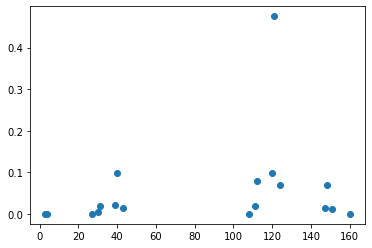

In [13]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")

In [14]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [15]:
#cost function of the initial state
expt_value = 0
matvec_h = full_ham_matrix@psi_0
matvec_c = constraint_full_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*(matvec_h[i]+matvec_c[i])
print(np.real(expt_value))

0.0


In [16]:
expt_value = 0
matvec = full_ham_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*matvec[i]
print(expt_value)

0j


In [17]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms(k,i,j,phi,theta):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    power_matrix = scipy.sparse.kron(sigma,sparse.identity(2*l+1))+scipy.sparse.kron(sparse.identity(2*l+1),sigma)
    rot_matrix = scipy.sparse.linalg.expm(-1j*power_matrix@power_matrix*theta/4)
    if k == 0:
        tensprod = rot_matrix
        for i in range(L-2):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+2,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms_e(i,j,phi,theta):
    ms_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        ms_e = rot_ms(2*k,i,j,phi,theta)@ms_e
    return(ms_e)

def rot_ms_o(i,j,phi,theta):
    ms_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)-1):
        ms_o = rot_ms(2*k+1,i,j,phi,theta)@ms_o
    return(ms_o)

def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_all(i,j,phi,theta):
    sigma_all = sparse.identity(basis.Ns,dtype = complex)
    for k in range(L):
        sigma_all = rot_sigma(k,i,j,phi,theta)@sigma_all
    return(sigma_all)

In [18]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    sigma_big = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        sigma_big[k] = tensprod
    for k in range(L):
        for kk in range(k,L):
            summe += 1./(1+(k-kk)**2)*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    

In [19]:
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
b = rot_sigma_e(0,1,0,np.pi)
print(datetime.datetime.now())
a@b
print(datetime.datetime.now())

2022-05-12 16:11:06.380139
2022-05-12 16:11:06.386045
2022-05-12 16:11:06.393277
2022-05-12 16:11:06.394309


In [20]:

def sigma_sigma(m,n,theta):
    sigma_sigma = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    temp1 = np.cos(theta/2)
    temp2 = -1j*np.sin(theta/2)
    for i in range(basis.Ns):
        sigma_sigma[i,i] = 1.
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

            
    return sigma_sigma

def id_id(m,theta):
    id_id = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        id_id[i,i] = 1.
        
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4))
            
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4)) 
            
    return id_id


def ms_global_sparse(theta):
    ms_global = sparse.identity(basis.Ns)
    for m in range(L):
        ms_global = id_id(m,theta)@ms_global
        for n in range(m+1,L):
            ms_global = sigma_sigma(m,n,theta)@ms_global
    return ms_global

#print(np.allclose(ms_global_sparse(np.pi/4).toarray(),ms_gate_global(np.pi/4), atol= 1e-3,rtol=1e-3))
#print(np.allclose(ms_global_sparse(np.pi/3).toarray().conj().T@ms_global_sparse(np.pi/3).toarray(),np.identity(basis.Ns), atol= 1e-8,rtol=1e-8))

%time sigma_sigma(0,1,np.pi/3)

CPU times: user 16.6 ms, sys: 37 µs, total: 16.7 ms
Wall time: 16.1 ms


<243x243 sparse matrix of type '<class 'numpy.complex128'>'
	with 351 stored elements in List of Lists format>

In [21]:
#import timeit
#print(timeit.timeit('[ms_gate_global(0,2,np.pi)]', globals=globals()))
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
print(np.size(a))


2022-05-12 16:11:07.419104
2022-05-12 16:11:07.423880
59049


In [22]:
def cost_function_sigma(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

import datetime

print(datetime.datetime.now())
a = cost_function_sigma(np.pi*np.ones(5*N))
print(datetime.datetime.now())

2022-05-12 16:11:07.898289
2022-05-12 16:11:08.116031


In [23]:
opt_params = []
function_values = []
def callback_function(x,fun,context):
    opt_params.append(x)
    function_values.append(fun)


In [24]:
full_ham_matrix = sparse.csc_matrix(full_ham_matrix)

In [25]:
Energy = np.zeros(5)
Fidelity = np.zeros(5)

In [27]:
import optuna
n_iter = 3000
theta = np.zeros(5*N)

trials = []
iterations = []
energies = []


#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+0", -3*np.pi, 3*np.pi)
        theta[5*i+1] = trial.suggest_float("5*"+str(i)+"+1", -3*np.pi, 3*np.pi)
        theta[5*i+2] = trial.suggest_float("5*"+str(i)+"+2", -3*np.pi, 3*np.pi)
        theta[5*i+3] = trial.suggest_float("5*"+str(i)+"+3", -3*np.pi, 3*np.pi)
        theta[5*i+4] = trial.suggest_float("5*"+str(i)+"+4", -3*np.pi, 3*np.pi)


        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

for i in range(1):

    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(sampler=sampler)
    study.optimize(cost_function_sigma, n_trials=n_iter)

    trials.append(study.trials_dataframe())    
    iterations.append(trials[i].loc[:,"number"].to_numpy())
    energies.append(trials[i].loc[:,"value"].to_numpy())

    theta = np.zeros(5*N)
    i=0
    for value in study.best_trial.params.items():
        theta[i] = value[1]
        i+=1

    psi_var = psi_0
    for i in range(N):

        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var
    


    #f = open("M=0.1,L=3.txt", "a")
    #f.write(str(N)+" "+" "+str(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)+" "+str(np.real(np.conj(psi_var)@full_ham_matrix@psi_var))+"\n")
    #f.close()

[I 2022-05-12 16:12:17,921] A new study created in memory with name: no-name-40888472-7c7f-4fe9-8881-0a79574513ea
[I 2022-05-12 16:12:18,130] Trial 0 finished with value: 3.640384767558382 and parameters: {'5*0+0': -1.9377140313909038, '5*0+1': -7.96354180202232, '5*0+2': 0.8446587142826942, '5*0+3': 5.638305086262141, '5*0+4': -5.639852042024076, '5*1+0': 8.563626038827053, '5*1+1': -8.752452777009383, '5*1+2': 1.6955362206792408, '5*1+3': -5.160098391277591, '5*1+4': 7.67069305035599, '5*2+0': 7.2946803576708525, '5*2+1': 3.1989125619479992, '5*2+2': -0.6793086902740839, '5*2+3': -1.619746224648627, '5*2+4': 7.463186766050406, '5*3+0': -9.079495912970765, '5*3+1': 8.399811061077912, '5*3+2': -6.204222227366157, '5*3+3': -0.2921734584943021, '5*3+4': -9.221640621258935}. Best is trial 0 with value: 3.640384767558382.
[I 2022-05-12 16:12:18,330] Trial 1 finished with value: 3.3178366751367125 and parameters: {'5*0+0': -2.9432493099532393, '5*0+1': 3.53922042254817, '5*0+2': -0.75218158

[I 2022-05-12 16:12:20,032] Trial 11 finished with value: 2.395575044606207 and parameters: {'5*0+0': 1.2842908767656553, '5*0+1': -1.2600805478573607, '5*0+2': -2.171560624167431, '5*0+3': 6.406635759480327, '5*0+4': -4.178430997175581, '5*1+0': -0.8279761677206872, '5*1+1': -0.5377402114977857, '5*1+2': 0.21677796541285282, '5*1+3': -3.7455717321141324, '5*1+4': 3.4808117517145725, '5*2+0': 2.294014206890175, '5*2+1': 2.7531023267259265, '5*2+2': 1.5748674626183947, '5*2+3': 3.662380437664617, '5*2+4': 1.611872644732709, '5*3+0': -2.9696288204005628, '5*3+1': -1.5533498743613454, '5*3+2': 3.0787593578249464, '5*3+3': -0.5840208866514217, '5*3+4': -1.2126796114844773}. Best is trial 10 with value: 2.180276727209857.
[I 2022-05-12 16:12:20,193] Trial 12 finished with value: 2.4976230351963054 and parameters: {'5*0+0': 4.017527471851855, '5*0+1': -0.07688840383817816, '5*0+2': -0.027165472309232486, '5*0+3': 1.011363446805436, '5*0+4': -4.847621399155968, '5*1+0': -1.979918014131006, '5

[I 2022-05-12 16:12:22,288] Trial 23 finished with value: 6.920170753425802 and parameters: {'5*0+0': -0.9692767647676214, '5*0+1': 0.14481248898591148, '5*0+2': 2.1747812521271044, '5*0+3': 6.5850937571153665, '5*0+4': -2.199263333424397, '5*1+0': -1.281668984295327, '5*1+1': 0.37037484975174806, '5*1+2': -2.9710915648358442, '5*1+3': 0.9535050801253666, '5*1+4': -0.9170404610065842, '5*2+0': 2.3127678097887125, '5*2+1': 6.155789606875047, '5*2+2': -2.260229702913532, '5*2+3': -2.719965488193186, '5*2+4': -2.810486346083745, '5*3+0': -5.5339650267700335, '5*3+1': -2.519907892809066, '5*3+2': -0.8502306066484224, '5*3+3': 2.3392293978064114, '5*3+4': 1.672590513127009}. Best is trial 10 with value: 2.180276727209857.
[I 2022-05-12 16:12:22,501] Trial 24 finished with value: 2.8762139219452605 and parameters: {'5*0+0': -0.99508628593084, '5*0+1': -1.5220316920270478, '5*0+2': 7.028404553729644, '5*0+3': 2.9566147746208546, '5*0+4': -2.361899521037851, '5*1+0': 0.4694787885142939, '5*1+1

[I 2022-05-12 16:12:25,442] Trial 35 finished with value: 6.4025163749820955 and parameters: {'5*0+0': -1.4144635656896374, '5*0+1': 1.2983553059807678, '5*0+2': 3.9794481369134784, '5*0+3': 5.655662592948104, '5*0+4': -3.606523756922899, '5*1+0': 0.051773269191004, '5*1+1': 6.312074658745285, '5*1+2': 4.726043241305593, '5*1+3': -9.362848933251813, '5*1+4': 0.9261028327558076, '5*2+0': -3.641686774785293, '5*2+1': 5.235245886322794, '5*2+2': 4.832349087518916, '5*2+3': 2.5946139849920518, '5*2+4': 2.47930963753242, '5*3+0': -2.149672936536188, '5*3+1': -2.2588584219792813, '5*3+2': 4.091875349070615, '5*3+3': -1.3512561638673108, '5*3+4': -1.4902920419700325}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:25,710] Trial 36 finished with value: 4.737158937873423 and parameters: {'5*0+0': 1.4797062553976998, '5*0+1': 0.08605309648817605, '5*0+2': 0.7040697029376943, '5*0+3': 4.817548186833468, '5*0+4': -2.160947261109262, '5*1+0': -6.104180875670461, '5*1+1': 4.682

[I 2022-05-12 16:12:28,607] Trial 47 finished with value: 7.260727633865548 and parameters: {'5*0+0': 1.655832250785368, '5*0+1': 2.4017165083503094, '5*0+2': 2.8837439435727155, '5*0+3': 1.3493807837070975, '5*0+4': 1.6755306750654482, '5*1+0': -3.9616376605645574, '5*1+1': 1.8423820556349195, '5*1+2': -4.7061087680300115, '5*1+3': 0.8217867156677621, '5*1+4': -0.7843243101034754, '5*2+0': 1.3260525565088797, '5*2+1': 1.535931183237826, '5*2+2': -3.7812305051455977, '5*2+3': 6.964225040165736, '5*2+4': -5.251248961808618, '5*3+0': 2.53938484813418, '5*3+1': 6.21039471667797, '5*3+2': 6.458597846092574, '5*3+3': -0.18505210628821245, '5*3+4': 0.707455515370021}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:28,867] Trial 48 finished with value: 1.0642665432364817 and parameters: {'5*0+0': 3.3622437900118967, '5*0+1': -1.5207496357540216, '5*0+2': 4.341178806195583, '5*0+3': 2.197435098747193, '5*0+4': -7.09279461484892, '5*1+0': 4.298911857587765, '5*1+1': 5.8806

[I 2022-05-12 16:12:31,837] Trial 59 finished with value: 3.2311044904113038 and parameters: {'5*0+0': -2.114224347240186, '5*0+1': -0.7806299569191146, '5*0+2': 2.9388875972894146, '5*0+3': 5.530073739622545, '5*0+4': -6.608397067661919, '5*1+0': -2.3504684440637575, '5*1+1': 3.295480060673812, '5*1+2': 6.7226481571997, '5*1+3': 0.2765700503883317, '5*1+4': -7.832459861094694, '5*2+0': 4.5830937870821105, '5*2+1': -3.1657359029968424, '5*2+2': -0.6236212301326293, '5*2+3': 1.444031414206289, '5*2+4': 6.182188745377985, '5*3+0': -1.45142286732125, '5*3+1': 3.972613752141883, '5*3+2': 1.1700334821283898, '5*3+3': -3.2030854655890817, '5*3+4': -5.654198511376699}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:32,071] Trial 60 finished with value: 2.7280165441246345 and parameters: {'5*0+0': -3.4055036532536063, '5*0+1': -6.683816748900987, '5*0+2': 7.029040233068856, '5*0+3': 3.0688103805128155, '5*0+4': -4.12523812195785, '5*1+0': 0.46143222234474723, '5*1+1': -0.

[I 2022-05-12 16:12:34,695] Trial 71 finished with value: 8.676237062227628 and parameters: {'5*0+0': -3.141303094770821, '5*0+1': -4.684133245909309, '5*0+2': 4.927641649123547, '5*0+3': 3.3983401338688877, '5*0+4': -3.7190020719728203, '5*1+0': 4.224152063353473, '5*1+1': 2.733461885621735, '5*1+2': 1.9406224464380142, '5*1+3': 3.436582853196833, '5*1+4': 1.133643004651958, '5*2+0': 1.644444106281211, '5*2+1': -2.783258844948816, '5*2+2': -0.31187855836238354, '5*2+3': -3.133754680691535, '5*2+4': 1.061292417356948, '5*3+0': 1.9212966063940793, '5*3+1': 3.8599738853130767, '5*3+2': 4.958510243704887, '5*3+3': -4.524261619620864, '5*3+4': 1.0853154597326427}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:34,932] Trial 72 finished with value: 2.7656049847212305 and parameters: {'5*0+0': -0.7131040917856545, '5*0+1': -7.673213063816928, '5*0+2': 5.801368431506605, '5*0+3': 2.485991574152048, '5*0+4': -0.7879988088242649, '5*1+0': -2.3945749424454656, '5*1+1': 1.18

[I 2022-05-12 16:12:37,785] Trial 83 finished with value: 3.445317125544075 and parameters: {'5*0+0': -1.1074300991612716, '5*0+1': -2.7026910912356152, '5*0+2': 7.214401338393465, '5*0+3': 1.2499036718290581, '5*0+4': -1.4013265144983866, '5*1+0': 0.309208236619273, '5*1+1': 5.634676374501568, '5*1+2': 3.1435703595301567, '5*1+3': -4.726996587180416, '5*1+4': -1.1662371149237192, '5*2+0': 7.254771945398726, '5*2+1': 2.6993483123373463, '5*2+2': 2.7236897511284246, '5*2+3': -6.567669747217064, '5*2+4': -0.8906787824936298, '5*3+0': 3.134961149533299, '5*3+1': -6.471424623706795, '5*3+2': 7.748697760888392, '5*3+3': -2.814919294532438, '5*3+4': -0.2711653042272209}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:38,024] Trial 84 finished with value: 3.46231523737572 and parameters: {'5*0+0': -3.1760935564217623, '5*0+1': -5.794011989799514, '5*0+2': 5.044427804787118, '5*0+3': 5.714542985528872, '5*0+4': -2.890737349791177, '5*1+0': 1.3660626044866908, '5*1+1': 7.9

[I 2022-05-12 16:12:40,759] Trial 95 finished with value: 2.9082241584605755 and parameters: {'5*0+0': 0.03231546700603832, '5*0+1': -1.9410363542874394, '5*0+2': 7.084502886958484, '5*0+3': 6.288211133197518, '5*0+4': 1.5924575011493518, '5*1+0': 3.9519523724472556, '5*1+1': 0.38570483894305285, '5*1+2': 5.221825124405338, '5*1+3': -1.0546041907168595, '5*1+4': -1.6630778142489444, '5*2+0': 2.245005434739728, '5*2+1': 2.2603501856825687, '5*2+2': -0.6123504237227426, '5*2+3': 8.470567709392228, '5*2+4': -1.6702458095445436, '5*3+0': 1.172019052135646, '5*3+1': -5.261802043175274, '5*3+2': 7.475924441264631, '5*3+3': -7.304385144908243, '5*3+4': -0.9831371896805208}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:41,002] Trial 96 finished with value: 7.083259236312276 and parameters: {'5*0+0': 0.4471564825672508, '5*0+1': -5.7276330493398975, '5*0+2': 5.370421231558897, '5*0+3': 0.4717444323198854, '5*0+4': -3.878862196671867, '5*1+0': 1.4022950038918034, '5*1+1':

[I 2022-05-12 16:12:43,745] Trial 107 finished with value: 7.122190542981304 and parameters: {'5*0+0': 0.35831995505113745, '5*0+1': -0.7336216246220713, '5*0+2': 7.7118121493925305, '5*0+3': 5.163366577860309, '5*0+4': -0.6230762781393616, '5*1+0': 3.5442416037169364, '5*1+1': 8.310889530661424, '5*1+2': 8.524025325091653, '5*1+3': 1.1812971559233212, '5*1+4': -1.8276772905774423, '5*2+0': 2.9034117199052014, '5*2+1': 6.700839913542133, '5*2+2': -0.17049651787666037, '5*2+3': 7.1311708923364385, '5*2+4': 1.506484519770773, '5*3+0': -1.2229202624381599, '5*3+1': -4.646937842620019, '5*3+2': 4.960459232980044, '5*3+3': -5.105111568230518, '5*3+4': -6.375463076987014}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:43,984] Trial 108 finished with value: 2.6227396948899884 and parameters: {'5*0+0': -3.586161006053347, '5*0+1': -6.62327057307336, '5*0+2': 7.477244822168359, '5*0+3': -0.31710132999361607, '5*0+4': -3.603014894750504, '5*1+0': -0.46663420745746986, '5*1

[I 2022-05-12 16:12:46,945] Trial 119 finished with value: 5.504209972186516 and parameters: {'5*0+0': 1.1994508570406937, '5*0+1': -4.630401572068622, '5*0+2': 5.31259966905579, '5*0+3': 3.6711593884282, '5*0+4': 6.3986880446605365, '5*1+0': 2.950930705700295, '5*1+1': 5.038680036640213, '5*1+2': 5.587372569873142, '5*1+3': 3.1078658981837384, '5*1+4': -2.137203869127561, '5*2+0': 2.2249434425172407, '5*2+1': 4.339736443287206, '5*2+2': 0.9320241498611392, '5*2+3': 4.276135328638028, '5*2+4': 1.3855478036006827, '5*3+0': -0.11972403474961091, '5*3+1': -4.4432739628658515, '5*3+2': 2.7374642862412566, '5*3+3': -5.447565875277719, '5*3+4': 0.35874713654697266}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:47,256] Trial 120 finished with value: 3.1730984318767437 and parameters: {'5*0+0': 0.9701319468869102, '5*0+1': -5.495320092102045, '5*0+2': 4.279423624747284, '5*0+3': 3.0351708992030018, '5*0+4': -1.7914461023548953, '5*1+0': 2.8471349111158184, '5*1+1': 3.97

[I 2022-05-12 16:12:50,037] Trial 131 finished with value: 4.381300856034285 and parameters: {'5*0+0': -3.033786985319214, '5*0+1': -6.857877911727247, '5*0+2': 4.7238062350323915, '5*0+3': 2.7911996061450597, '5*0+4': -2.030618655638821, '5*1+0': 0.8758252899966485, '5*1+1': 3.168297240831177, '5*1+2': 6.394894243323169, '5*1+3': 3.075165369319336, '5*1+4': -7.146427051665315, '5*2+0': -0.3958171693583008, '5*2+1': 2.289146564952639, '5*2+2': -5.531773003281881, '5*2+3': 2.526190704564442, '5*2+4': 0.6962243528105503, '5*3+0': -3.5555421347756404, '5*3+1': -4.603029364351132, '5*3+2': -0.35996349958384233, '5*3+3': -5.705234142400108, '5*3+4': -0.5347897646939579}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:50,286] Trial 132 finished with value: 3.2973614709726657 and parameters: {'5*0+0': -7.251282496922187, '5*0+1': -4.868166349090322, '5*0+2': 4.2576538651005995, '5*0+3': 4.003132104147081, '5*0+4': 0.9784813484517572, '5*1+0': -0.8441420952474803, '5*1+1'

[I 2022-05-12 16:12:53,155] Trial 143 finished with value: 3.916960884718093 and parameters: {'5*0+0': -0.4154353436955533, '5*0+1': -2.0647291310390017, '5*0+2': -1.996315659881554, '5*0+3': 5.399959014841044, '5*0+4': -5.987056847792823, '5*1+0': -3.898388462419647, '5*1+1': 3.3477380946712008, '5*1+2': 0.8071949921154129, '5*1+3': 3.9254900556110686, '5*1+4': -3.8644936098406024, '5*2+0': -1.8421236013177955, '5*2+1': 2.610624275409865, '5*2+2': 0.15217416079162738, '5*2+3': 6.330288428409074, '5*2+4': -3.7914589441122537, '5*3+0': 2.005024971630995, '5*3+1': -3.7021812132756096, '5*3+2': 1.7245136414323219, '5*3+3': -4.9163846762760555, '5*3+4': 1.889514422729295}. Best is trial 25 with value: 0.5368787288861514.
[I 2022-05-12 16:12:53,467] Trial 144 finished with value: 3.668999982470474 and parameters: {'5*0+0': -2.414741793740666, '5*0+1': 1.239932237424306, '5*0+2': -0.9522084463755238, '5*0+3': 8.764916105262209, '5*0+4': -7.842122215564727, '5*1+0': 2.341100438116732, '5*1+1'

[I 2022-05-12 16:12:56,611] Trial 155 finished with value: 3.790605656828397 and parameters: {'5*0+0': 1.7884849745377407, '5*0+1': 2.496510025063488, '5*0+2': 2.1724577498088866, '5*0+3': 2.035272534492072, '5*0+4': 0.47800433325880987, '5*1+0': -1.4733338457683778, '5*1+1': 2.347477140071888, '5*1+2': 3.1533275793462705, '5*1+3': 0.45064697863018743, '5*1+4': -3.1900518913432276, '5*2+0': 2.3013736296752834, '5*2+1': 8.952510654685245, '5*2+2': -0.38421955598548607, '5*2+3': 8.00768217192471, '5*2+4': -5.783285421308394, '5*3+0': 0.3164962087375936, '5*3+1': -8.500587027469699, '5*3+2': 4.866636754081395, '5*3+3': -2.5057915716441608, '5*3+4': 1.5248772312031011}. Best is trial 145 with value: -0.07428400867487184.
[I 2022-05-12 16:12:56,836] Trial 156 finished with value: 7.832910096979111 and parameters: {'5*0+0': 1.0148254984409353, '5*0+1': 0.1885018820842363, '5*0+2': 0.15956475246906154, '5*0+3': 5.58810777889325, '5*0+4': -1.3380769691545078, '5*1+0': 0.5759665465093075, '5*1+

[I 2022-05-12 16:12:59,774] Trial 167 finished with value: 4.559840814281303 and parameters: {'5*0+0': -1.5082125369887152, '5*0+1': -5.016208851311123, '5*0+2': 5.007197174692823, '5*0+3': 3.9732401145882017, '5*0+4': -1.0055978262495393, '5*1+0': 0.9314783754040445, '5*1+1': 2.9742055528364864, '5*1+2': 3.809402890597658, '5*1+3': 6.083860727364833, '5*1+4': -7.193629034220996, '5*2+0': -0.15826585841899987, '5*2+1': 5.983099086780104, '5*2+2': -1.8910466608152294, '5*2+3': 6.006962335316423, '5*2+4': -3.1565265751303784, '5*3+0': -1.2983941685541631, '5*3+1': -2.533108184071408, '5*3+2': 6.121512244406613, '5*3+3': 1.4788816588484264, '5*3+4': 2.582652323654008}. Best is trial 145 with value: -0.07428400867487184.
[I 2022-05-12 16:13:00,081] Trial 168 finished with value: 5.2027845784847635 and parameters: {'5*0+0': 0.9732808452868175, '5*0+1': -1.97480745127922, '5*0+2': -0.6828771179762732, '5*0+3': 0.8323862835663736, '5*0+4': -0.4356407335351091, '5*1+0': 0.34601507922669206, '5

[I 2022-05-12 16:13:03,169] Trial 179 finished with value: 6.106123927345974 and parameters: {'5*0+0': -1.5943048722919455, '5*0+1': -4.444932520748514, '5*0+2': 0.9051362264403968, '5*0+3': 5.873291569213263, '5*0+4': -3.368104398562692, '5*1+0': 0.7383543820917728, '5*1+1': -0.5215040077613482, '5*1+2': 2.369895145444274, '5*1+3': 3.057240632036665, '5*1+4': -2.9690901211342196, '5*2+0': -7.8083602414691535, '5*2+1': 3.165029596084101, '5*2+2': -0.31099604341274634, '5*2+3': 5.357583651710505, '5*2+4': 0.8616978009115774, '5*3+0': -2.218839824152009, '5*3+1': -2.1731787702046432, '5*3+2': 6.7884047573987285, '5*3+3': -3.6068168212928104, '5*3+4': 0.16268353721189976}. Best is trial 145 with value: -0.07428400867487184.
[I 2022-05-12 16:13:03,426] Trial 180 finished with value: 1.4980708853105913 and parameters: {'5*0+0': 1.3879463222076631, '5*0+1': 0.17182581341726433, '5*0+2': 2.487975896244562, '5*0+3': 2.1061044437183107, '5*0+4': 0.8151263581812072, '5*1+0': 0.8708551121810955, 

[I 2022-05-12 16:13:06,092] Trial 191 finished with value: 2.993835625899403 and parameters: {'5*0+0': 3.0330190474010155, '5*0+1': -3.9326181101072795, '5*0+2': -2.3025530704026345, '5*0+3': 4.209167646313336, '5*0+4': 1.1216094089689204, '5*1+0': 2.4864980543091835, '5*1+1': 1.57455126321348, '5*1+2': 3.273795654569408, '5*1+3': 7.905953328392322, '5*1+4': -4.8085002759584325, '5*2+0': -3.1553169120901816, '5*2+1': -0.313799869648669, '5*2+2': -6.484056654722655, '5*2+3': 7.00283067107036, '5*2+4': -0.09187439418353449, '5*3+0': 0.27107837456727946, '5*3+1': -4.252823398820793, '5*3+2': 1.7658117515605494, '5*3+3': -7.291465812942933, '5*3+4': 0.8753714480847661}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:06,389] Trial 192 finished with value: 4.196065310680265 and parameters: {'5*0+0': 1.6812597345093763, '5*0+1': -0.9669070729943496, '5*0+2': -0.23141778452235656, '5*0+3': 0.1167201389352619, '5*0+4': 0.6556488106516305, '5*1+0': 1.4411500089485405, '5

[I 2022-05-12 16:13:09,224] Trial 203 finished with value: 0.8003652510696722 and parameters: {'5*0+0': 0.46665325949435443, '5*0+1': 1.171776157321745, '5*0+2': -0.8565669451764222, '5*0+3': 5.478307441432972, '5*0+4': -0.9612130102300885, '5*1+0': -1.1608259935755685, '5*1+1': 3.3210084015250425, '5*1+2': 6.521137431017555, '5*1+3': 4.286938967661121, '5*1+4': -3.0704999430890862, '5*2+0': -6.671831264987335, '5*2+1': 5.349986761806434, '5*2+2': -2.2430194587135928, '5*2+3': 2.9325087921279125, '5*2+4': -3.7449352221307857, '5*3+0': 0.9028388965665879, '5*3+1': -5.828136377998278, '5*3+2': 5.032522899736084, '5*3+3': -4.897615925095598, '5*3+4': -1.7432224783505919}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:09,453] Trial 204 finished with value: 7.03483445815903 and parameters: {'5*0+0': 1.4661647985716126, '5*0+1': -8.104436824817567, '5*0+2': -0.872729259006674, '5*0+3': 7.997262399040701, '5*0+4': -0.7796041059744485, '5*1+0': -1.4527067828511977, '5

[I 2022-05-12 16:13:12,301] Trial 215 finished with value: 10.020157355341485 and parameters: {'5*0+0': -0.6032110800953971, '5*0+1': -1.242973575177507, '5*0+2': -0.7435265953770982, '5*0+3': 6.9250634285133925, '5*0+4': -1.8395982905242345, '5*1+0': -1.7008150070405827, '5*1+1': 4.379175810184246, '5*1+2': 5.7303751606084825, '5*1+3': 4.429374506545069, '5*1+4': -1.6822499706388485, '5*2+0': -5.786433435544245, '5*2+1': 5.466861487271649, '5*2+2': 2.162297732809643, '5*2+3': 4.439184182955721, '5*2+4': -4.272837138480497, '5*3+0': 0.6797231034546372, '5*3+1': -7.6685311960529114, '5*3+2': 6.80294355950139, '5*3+3': -1.191898662552521, '5*3+4': -3.1859890594610443}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:12,535] Trial 216 finished with value: 3.600407411470181 and parameters: {'5*0+0': 1.8623905685681073, '5*0+1': -0.2926009613866641, '5*0+2': -0.20086277472994402, '5*0+3': 1.221387929200474, '5*0+4': 1.3385290342918235, '5*1+0': 1.599828066365399, '5*

[I 2022-05-12 16:13:15,807] Trial 227 finished with value: 4.51004473396086 and parameters: {'5*0+0': 1.8961707485652008, '5*0+1': -1.9214210871406354, '5*0+2': -0.11457681489512006, '5*0+3': 5.62110115049023, '5*0+4': -2.2195249244112536, '5*1+0': 1.6287525899996196, '5*1+1': 2.3037151711794186, '5*1+2': 6.197878376596716, '5*1+3': 4.899409660275061, '5*1+4': -4.130636913287533, '5*2+0': -6.5808805928829734, '5*2+1': 3.5895843994117786, '5*2+2': 3.649360649298883, '5*2+3': 2.7159688751251383, '5*2+4': -2.362595709185728, '5*3+0': -0.284500217449512, '5*3+1': -4.9747496106356985, '5*3+2': 4.228758347268208, '5*3+3': -1.687865860497436, '5*3+4': 1.5256940967718877}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:16,111] Trial 228 finished with value: 5.514212688668502 and parameters: {'5*0+0': -1.1741528916616462, '5*0+1': 0.4003938258244237, '5*0+2': -0.4394217157636424, '5*0+3': 5.370422979106158, '5*0+4': -1.43299596887055, '5*1+0': 2.6526658776517937, '5*1+1

[I 2022-05-12 16:13:19,072] Trial 239 finished with value: 7.034649933620023 and parameters: {'5*0+0': 1.8858523329478647, '5*0+1': -1.7478744074866985, '5*0+2': 4.942885551030782, '5*0+3': 7.132775970013085, '5*0+4': -3.406831786391721, '5*1+0': -0.8794822614961959, '5*1+1': 4.993865939256561, '5*1+2': 2.7296822702083645, '5*1+3': 3.592269891765059, '5*1+4': -2.544636431745817, '5*2+0': -2.146219762759439, '5*2+1': 8.052128050644097, '5*2+2': -2.4335055885540045, '5*2+3': 4.897153178072095, '5*2+4': -0.926992684340888, '5*3+0': 1.282140763516369, '5*3+1': -4.962136056490701, '5*3+2': 8.539801057164109, '5*3+3': -1.2195610880912766, '5*3+4': 2.0777623415813835}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:19,308] Trial 240 finished with value: 3.1755606688456393 and parameters: {'5*0+0': 0.05333561326572356, '5*0+1': -0.6272311872354985, '5*0+2': 4.29527055848364, '5*0+3': 5.796215844684098, '5*0+4': 1.3019937022443817, '5*1+0': 1.4279783809418354, '5*1+1': 

[I 2022-05-12 16:13:21,978] Trial 251 finished with value: 2.092251194872544 and parameters: {'5*0+0': -1.1377446696758748, '5*0+1': -2.1355399552646905, '5*0+2': 7.015458655015613, '5*0+3': 8.967616427173864, '5*0+4': 3.967349386588471, '5*1+0': 1.8972186114595222, '5*1+1': 3.306159386571988, '5*1+2': 1.8119078942109499, '5*1+3': 4.60854160027302, '5*1+4': -2.191388835420399, '5*2+0': -7.152329085331642, '5*2+1': 2.570279523839277, '5*2+2': -4.8681528178643445, '5*2+3': 0.8620557480172129, '5*2+4': -2.8697306491797367, '5*3+0': 2.291916615560238, '5*3+1': -9.107152733936505, '5*3+2': 7.905543094718379, '5*3+3': 0.01647691184115052, '5*3+4': -2.5672388444628873}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:22,219] Trial 252 finished with value: 4.374340058020689 and parameters: {'5*0+0': -4.082719939984531, '5*0+1': -1.0252924199032516, '5*0+2': 1.2789083278628401, '5*0+3': 6.677471925740567, '5*0+4': 1.0816752306228676, '5*1+0': 1.1290214539937065, '5*1+1':

[I 2022-05-12 16:13:24,936] Trial 263 finished with value: 3.8875640420014106 and parameters: {'5*0+0': -4.6545833217341865, '5*0+1': 0.3781175424579339, '5*0+2': 2.8093231692351686, '5*0+3': 6.825876640721864, '5*0+4': 3.3299817105786915, '5*1+0': -1.2016449727006544, '5*1+1': -0.1944133114426254, '5*1+2': 5.045877608183137, '5*1+3': 6.179047511563384, '5*1+4': -0.40211830877489185, '5*2+0': -4.498556386786318, '5*2+1': 5.347992673459617, '5*2+2': -2.6005739217062143, '5*2+3': 2.626068031872321, '5*2+4': 2.737492776485755, '5*3+0': 1.0332984490018324, '5*3+1': -6.134138459906085, '5*3+2': 7.873589664988414, '5*3+3': -3.7932644345714186, '5*3+4': -1.1127073664440716}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:25,195] Trial 264 finished with value: 4.4266592921782095 and parameters: {'5*0+0': 0.9821491778523401, '5*0+1': 0.77549611282119, '5*0+2': 2.7690946974967448, '5*0+3': 9.21202195256259, '5*0+4': 2.4656385255491102, '5*1+0': 0.8768394452929634, '5*1+1

[I 2022-05-12 16:13:28,221] Trial 275 finished with value: 1.9306647026480166 and parameters: {'5*0+0': -1.018588903152012, '5*0+1': 0.09580650296300797, '5*0+2': 1.168026247343714, '5*0+3': 4.508136832606847, '5*0+4': 1.2219927126160894, '5*1+0': -1.2673474019989774, '5*1+1': 2.519105304948938, '5*1+2': 5.209684039639907, '5*1+3': 8.156391648826345, '5*1+4': -3.391153092875057, '5*2+0': -4.3049300507901025, '5*2+1': 6.217256081207989, '5*2+2': -3.6172973712444216, '5*2+3': 7.394917223050449, '5*2+4': -0.1566223727997278, '5*3+0': 0.4681001861450307, '5*3+1': -6.401588921931396, '5*3+2': 7.754091990186257, '5*3+3': -2.361444152070981, '5*3+4': 0.4128351274446591}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:28,452] Trial 276 finished with value: 9.346797127804523 and parameters: {'5*0+0': -0.3370376336518115, '5*0+1': 6.976763325054257, '5*0+2': 0.22592436972538324, '5*0+3': 6.211591301069719, '5*0+4': 1.4462288790735023, '5*1+0': 1.4974669325813836, '5*1+1'

[I 2022-05-12 16:13:31,407] Trial 287 finished with value: 2.533791497352291 and parameters: {'5*0+0': -4.4919776959177256, '5*0+1': 2.8521074783014497, '5*0+2': 0.7787607189610384, '5*0+3': 5.214284454450485, '5*0+4': -1.8508770006460826, '5*1+0': -1.9263570237740104, '5*1+1': 1.2439245229158962, '5*1+2': 8.421808842505262, '5*1+3': 7.500129854258248, '5*1+4': 2.3695076766713297, '5*2+0': -0.36570814351143577, '5*2+1': 8.672045554599908, '5*2+2': -1.6734509142265848, '5*2+3': 4.071435286413597, '5*2+4': -1.6418364943260615, '5*3+0': 3.803926507684814, '5*3+1': -8.652512232863954, '5*3+2': 8.614928244622263, '5*3+3': -1.7500312519205077, '5*3+4': 0.47370726525156126}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:31,672] Trial 288 finished with value: 6.714169983118673 and parameters: {'5*0+0': -4.617128060848511, '5*0+1': -1.348259972343069, '5*0+2': 0.617819115083282, '5*0+3': 4.599305921575097, '5*0+4': -2.5222918910548295, '5*1+0': -1.824749665646576, '5*1

[I 2022-05-12 16:13:34,474] Trial 299 finished with value: 1.5357556794803284 and parameters: {'5*0+0': 0.3234850307512833, '5*0+1': 0.49013578370237754, '5*0+2': -0.23899144362285885, '5*0+3': 4.400738429709017, '5*0+4': -2.3697541630164345, '5*1+0': -1.4069034143769312, '5*1+1': 0.5959200491987848, '5*1+2': 7.313025877546848, '5*1+3': 3.530523406781109, '5*1+4': 0.26788517588859745, '5*2+0': 0.16250369594838077, '5*2+1': 6.534258418531537, '5*2+2': -2.441884561857101, '5*2+3': 4.201282395912268, '5*2+4': -0.6536633741376212, '5*3+0': 1.6782665034444628, '5*3+1': -5.000584208120751, '5*3+2': 8.671725239663449, '5*3+3': -4.291119849102243, '5*3+4': 3.812031025296218}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:34,796] Trial 300 finished with value: 3.3561860123145912 and parameters: {'5*0+0': 1.3273295149657192, '5*0+1': -1.3146482972235605, '5*0+2': 1.5338768044204674, '5*0+3': 4.211390985233544, '5*0+4': -0.2291493355865576, '5*1+0': -2.278034687079967, '

[I 2022-05-12 16:13:37,715] Trial 311 finished with value: 1.869602322079582 and parameters: {'5*0+0': 1.605190787025095, '5*0+1': 1.3921763653866357, '5*0+2': 0.7526431368321187, '5*0+3': 2.8841917895402793, '5*0+4': -2.73180195970093, '5*1+0': -0.2067951947040445, '5*1+1': 0.7422498054414656, '5*1+2': 6.033923300862486, '5*1+3': 5.637761218261606, '5*1+4': -1.9879667616874261, '5*2+0': -6.455525164603536, '5*2+1': 7.783878915360514, '5*2+2': -1.5040150045886125, '5*2+3': 6.2963573555652355, '5*2+4': 1.3656617000605222, '5*3+0': 5.826915888611673, '5*3+1': -6.358427815370688, '5*3+2': 7.840682269370136, '5*3+3': -2.1622461744698995, '5*3+4': 3.6629495445741505}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:37,972] Trial 312 finished with value: 3.891900151820186 and parameters: {'5*0+0': 1.5894679723410523, '5*0+1': 0.9993316030851107, '5*0+2': 1.1849456337890594, '5*0+3': 6.651233328829891, '5*0+4': -3.938426483933987, '5*1+0': -0.526244982952637, '5*1+1': 

[I 2022-05-12 16:13:40,926] Trial 323 finished with value: 2.157110025409458 and parameters: {'5*0+0': -0.7212804970708178, '5*0+1': 0.8694693632507433, '5*0+2': 0.4853626754369119, '5*0+3': 4.143209055488122, '5*0+4': -1.4595833751207585, '5*1+0': -3.019197590005476, '5*1+1': 0.5132385319181904, '5*1+2': 7.750268633236987, '5*1+3': 5.116916366225679, '5*1+4': -1.3362406998273741, '5*2+0': -5.6770962393602, '5*2+1': 4.189745780348518, '5*2+2': -0.7303594267579818, '5*2+3': 3.8499779111321235, '5*2+4': 2.9786735288385575, '5*3+0': 0.5810132722608434, '5*3+1': -4.010297775393052, '5*3+2': 4.80993824037086, '5*3+3': -5.536489075190401, '5*3+4': 3.6603386705128185}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:41,241] Trial 324 finished with value: 2.868892360463243 and parameters: {'5*0+0': 0.30167989185243305, '5*0+1': 4.552581446404208, '5*0+2': -1.3585346978930704, '5*0+3': 3.9971023930334426, '5*0+4': -0.7925424923862869, '5*1+0': -1.6933955011161423, '5*1+1

[I 2022-05-12 16:13:44,356] Trial 335 finished with value: 2.5298847475141013 and parameters: {'5*0+0': 1.0995971202041526, '5*0+1': 2.1991404680419, '5*0+2': -2.7345720105080056, '5*0+3': 2.3150086062457973, '5*0+4': -2.1602557590812967, '5*1+0': -2.072044792069389, '5*1+1': -0.025046436788431554, '5*1+2': 4.271680469245596, '5*1+3': 9.309172974084436, '5*1+4': -1.0654857369296467, '5*2+0': -3.173234221933479, '5*2+1': 4.7235027836727745, '5*2+2': -1.0709976332231081, '5*2+3': 2.603309593359991, '5*2+4': 2.0131875212665395, '5*3+0': -0.25099264312949177, '5*3+1': -7.906684418202371, '5*3+2': 6.517976863158828, '5*3+3': -6.052044015832926, '5*3+4': 1.9736437320168085}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:44,659] Trial 336 finished with value: 2.9671385581506335 and parameters: {'5*0+0': 2.0747552566149525, '5*0+1': 2.8803072519651955, '5*0+2': 4.0600283062912785, '5*0+3': 2.147567748049565, '5*0+4': -1.2239160420905397, '5*1+0': -0.46821316486915254,

[I 2022-05-12 16:13:47,549] Trial 347 finished with value: 3.4338606321303358 and parameters: {'5*0+0': 3.708948660992461, '5*0+1': 1.0049703986747822, '5*0+2': 0.7129296167395922, '5*0+3': 1.4881179457383715, '5*0+4': -0.2956853882862112, '5*1+0': -1.9732615701740803, '5*1+1': -0.2476763690039676, '5*1+2': 7.1877549235024905, '5*1+3': 8.445112732757496, '5*1+4': -2.3920127325433618, '5*2+0': -5.680181617791341, '5*2+1': 5.250187451902749, '5*2+2': -2.5420941482118993, '5*2+3': 3.3385460089804706, '5*2+4': -0.439067610864438, '5*3+0': 2.105237707890942, '5*3+1': -5.62671376316379, '5*3+2': 8.793510227450973, '5*3+3': -3.138228466304137, '5*3+4': 1.0348945026162806}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:47,823] Trial 348 finished with value: 3.2076276862138036 and parameters: {'5*0+0': 4.159908708367793, '5*0+1': 1.770699352531926, '5*0+2': -0.32524371602797125, '5*0+3': 1.144284865017509, '5*0+4': -2.3873073009898396, '5*1+0': -1.351974589596523, '5*1

[I 2022-05-12 16:13:50,755] Trial 359 finished with value: 1.018151269302539 and parameters: {'5*0+0': -1.8486477412310396, '5*0+1': 1.9960164003625036, '5*0+2': -2.352436119713918, '5*0+3': 4.504788806316277, '5*0+4': -1.192682801358206, '5*1+0': -1.7998571268425445, '5*1+1': 0.5040202704087635, '5*1+2': 4.4052097430295, '5*1+3': 7.226993462399973, '5*1+4': 0.7536939151724721, '5*2+0': -3.3334343591611217, '5*2+1': 6.387744310568207, '5*2+2': -1.4065555933854772, '5*2+3': 4.544677561435128, '5*2+4': 1.0257681012059747, '5*3+0': -1.0541118669995617, '5*3+1': -8.545162303593694, '5*3+2': 7.087350258972631, '5*3+3': -1.6762280145058324, '5*3+4': 2.0797382030494793}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:51,010] Trial 360 finished with value: 1.4891739408250464 and parameters: {'5*0+0': -1.099858248108936, '5*0+1': 2.1018430264257377, '5*0+2': 0.23858388189459, '5*0+3': 4.211019241251063, '5*0+4': -0.22891423918585374, '5*1+0': -3.3800676902755313, '5*1+1

[I 2022-05-12 16:13:53,804] Trial 371 finished with value: 2.936848514952519 and parameters: {'5*0+0': -0.753224177333792, '5*0+1': -0.7100077850482236, '5*0+2': -3.577946668856139, '5*0+3': 5.198512617027588, '5*0+4': 0.027600696739595032, '5*1+0': -2.484875583472343, '5*1+1': 2.733152894089594, '5*1+2': 4.386302526469443, '5*1+3': 4.276578745704999, '5*1+4': 1.0331651461969185, '5*2+0': -2.1821390587832052, '5*2+1': 5.4518913921022705, '5*2+2': -0.037934440333374786, '5*2+3': 5.80862979060675, '5*2+4': 2.7163018801666037, '5*3+0': 0.8393186347883268, '5*3+1': -6.919788611822647, '5*3+2': 7.1982812142675625, '5*3+3': -2.062297951956755, '5*3+4': 2.660004735279565}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:54,107] Trial 372 finished with value: 3.3219456687165025 and parameters: {'5*0+0': -2.2334004210150313, '5*0+1': 0.12651347616944597, '5*0+2': -0.7755500190776661, '5*0+3': 2.129738278255778, '5*0+4': -0.4124866030601698, '5*1+0': -2.438060879534507, '

[I 2022-05-12 16:13:57,234] Trial 383 finished with value: 1.8060796240834842 and parameters: {'5*0+0': 0.17202857673949523, '5*0+1': 0.13906061706389639, '5*0+2': -1.7400285864381715, '5*0+3': 2.9919021614223347, '5*0+4': 0.2886399544560298, '5*1+0': -1.7360822949943573, '5*1+1': 3.361106274363625, '5*1+2': 4.918770560800551, '5*1+3': 9.289630639189365, '5*1+4': 3.890844827214813, '5*2+0': -5.141405953921284, '5*2+1': 7.391354597299526, '5*2+2': 1.1332970939383284, '5*2+3': 5.099961614882645, '5*2+4': 0.02818279312225025, '5*3+0': -2.158302336150328, '5*3+1': -6.391309743815301, '5*3+2': 1.9973238813444993, '5*3+3': -3.3953436504428476, '5*3+4': 0.022540128550958327}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:13:57,485] Trial 384 finished with value: 3.108605057299547 and parameters: {'5*0+0': -0.15835820206241558, '5*0+1': 4.276509135927139, '5*0+2': -3.841940442786155, '5*0+3': 4.747046039047087, '5*0+4': -1.777635139316714, '5*1+0': -3.69334390955959, '5*

[I 2022-05-12 16:14:00,391] Trial 395 finished with value: 2.304282945772936 and parameters: {'5*0+0': -0.37977173566825734, '5*0+1': 0.26940600770377554, '5*0+2': 1.0154542250069836, '5*0+3': 3.4349798851429254, '5*0+4': -2.121409873969875, '5*1+0': -2.667931313988337, '5*1+1': 3.8692614615524756, '5*1+2': 5.341718899980839, '5*1+3': 8.0475069829474, '5*1+4': 1.9825552701669915, '5*2+0': -3.45492837867949, '5*2+1': 4.202255099508325, '5*2+2': -0.7604976358030286, '5*2+3': 5.9276455762014235, '5*2+4': 1.1349088289349085, '5*3+0': -1.2983607945934905, '5*3+1': -5.747408960966079, '5*3+2': 2.8427540558386233, '5*3+3': -3.8847901118124217, '5*3+4': 0.27517341028952835}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:00,628] Trial 396 finished with value: 2.61899809713153 and parameters: {'5*0+0': 0.2979237546509145, '5*0+1': -1.5342489567096376, '5*0+2': 0.4516195583726057, '5*0+3': 4.246904815838396, '5*0+4': -0.4255041196480021, '5*1+0': -3.0472362956228944, '5*

[I 2022-05-12 16:14:03,542] Trial 407 finished with value: 0.6746604986548643 and parameters: {'5*0+0': -0.4501965085787895, '5*0+1': 1.3475373160996988, '5*0+2': -1.7615375238800501, '5*0+3': 3.955826900146331, '5*0+4': -2.4124307632969777, '5*1+0': -4.062234452493353, '5*1+1': 2.1057759993512297, '5*1+2': 3.8259157247848923, '5*1+3': 5.52353912226119, '5*1+4': 3.061795181251451, '5*2+0': -3.421136090610607, '5*2+1': 5.551949293313529, '5*2+2': -0.4065473513203822, '5*2+3': 6.518252049212106, '5*2+4': -0.14449734003945625, '5*3+0': -2.0820284838527323, '5*3+1': -7.759597147258962, '5*3+2': 2.396608216746297, '5*3+3': -1.0849563119733832, '5*3+4': -0.4606386484665008}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:03,780] Trial 408 finished with value: 4.053293438217727 and parameters: {'5*0+0': 1.6262651676136168, '5*0+1': 1.8671392309400843, '5*0+2': -0.2000033727893481, '5*0+3': -1.0363932139719219, '5*0+4': -1.8322634703982825, '5*1+0': -2.1770189776378164

[I 2022-05-12 16:14:06,398] Trial 419 finished with value: 4.014414759912738 and parameters: {'5*0+0': -0.14730855230602058, '5*0+1': 0.6461706659461638, '5*0+2': -1.7713668051919353, '5*0+3': 3.279805091310199, '5*0+4': -3.0126238516906327, '5*1+0': -2.2496808994905866, '5*1+1': 5.201770487591643, '5*1+2': 6.714129552502781, '5*1+3': 5.8187524049362285, '5*1+4': 1.4959433933183586, '5*2+0': -2.8220610738757297, '5*2+1': 8.604257415776086, '5*2+2': -1.3495828907900864, '5*2+3': 5.628346828963593, '5*2+4': -0.6743609027905925, '5*3+0': -3.5727902326222045, '5*3+1': -6.211703902835078, '5*3+2': 3.8149821212189736, '5*3+3': -4.328689556494, '5*3+4': -0.8133270243834783}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:06,653] Trial 420 finished with value: 3.981065215439669 and parameters: {'5*0+0': 0.47517173732855134, '5*0+1': -1.8208003470314922, '5*0+2': -0.7020015718380488, '5*0+3': 3.864563925997548, '5*0+4': -4.964734121160007, '5*1+0': -5.302185220949798, '

[I 2022-05-12 16:14:09,498] Trial 431 finished with value: 1.7177448083250486 and parameters: {'5*0+0': -0.7252065368394152, '5*0+1': -1.9074431600226573, '5*0+2': -0.1468260175094558, '5*0+3': 1.4966529696405066, '5*0+4': -2.9072885396495587, '5*1+0': -3.943920359751621, '5*1+1': 1.774278296419778, '5*1+2': 4.3778666966806785, '5*1+3': 4.015879357112931, '5*1+4': 1.0978990435086071, '5*2+0': -2.699723619905799, '5*2+1': 5.169670666453579, '5*2+2': -0.3484403027264379, '5*2+3': 6.480441754865344, '5*2+4': -0.0634756968477489, '5*3+0': 1.886496777571359, '5*3+1': -8.088459238435053, '5*3+2': 2.9934539606762005, '5*3+3': -4.1978584257572225, '5*3+4': 1.6354563350927704}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:09,762] Trial 432 finished with value: 1.4089479686575843 and parameters: {'5*0+0': -1.829360288677661, '5*0+1': 0.04641152919739722, '5*0+2': -1.4869791815398368, '5*0+3': 3.7565093650486276, '5*0+4': -1.890083977591509, '5*1+0': -1.7286225643405395

[I 2022-05-12 16:14:12,571] Trial 443 finished with value: 3.0238356281393655 and parameters: {'5*0+0': -2.0822321698826394, '5*0+1': -0.4168555122901781, '5*0+2': -1.1344671842101561, '5*0+3': 3.084936829861887, '5*0+4': -1.97929777456747, '5*1+0': -4.586202443870859, '5*1+1': 0.13277781988630055, '5*1+2': 2.3660858039385904, '5*1+3': 7.528001899274534, '5*1+4': 3.069276619844624, '5*2+0': -5.479152503743522, '5*2+1': 7.895939017773272, '5*2+2': -0.38464260650686205, '5*2+3': 4.371630683831723, '5*2+4': 1.0747361534793645, '5*3+0': 0.5836241510978306, '5*3+1': -7.270983243553397, '5*3+2': 4.703009116025973, '5*3+3': -3.7338789974992617, '5*3+4': 0.6210481314317199}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:12,868] Trial 444 finished with value: 3.201058861300038 and parameters: {'5*0+0': 1.991150182933095, '5*0+1': -1.0363731595623145, '5*0+2': -2.2296419774739666, '5*0+3': 4.921661771303004, '5*0+4': -3.1555764727239053, '5*1+0': -2.8776524971638833, '5

[I 2022-05-12 16:14:15,890] Trial 455 finished with value: 2.16303992359107 and parameters: {'5*0+0': -0.5808627250571755, '5*0+1': 0.9956096344905636, '5*0+2': -3.0085643992739346, '5*0+3': 4.311952241394643, '5*0+4': -2.896000914665168, '5*1+0': -3.055580703723003, '5*1+1': 0.2925317755636536, '5*1+2': 4.143285498740484, '5*1+3': 7.517351466752238, '5*1+4': 1.016052339216637, '5*2+0': -3.53510947213716, '5*2+1': 7.155143928271694, '5*2+2': -1.7014774041554945, '5*2+3': 4.600806458222479, '5*2+4': -1.18627499914368, '5*3+0': -4.152751752257416, '5*3+1': -9.053656579786816, '5*3+2': 5.7534458437853555, '5*3+3': -2.7246294750589457, '5*3+4': 1.1774076607957076}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:16,164] Trial 456 finished with value: 3.3548929509356604 and parameters: {'5*0+0': 0.040473702243449095, '5*0+1': 1.934853770732924, '5*0+2': -1.0563267861471273, '5*0+3': -0.2199080164039473, '5*0+4': -1.697509541503985, '5*1+0': -4.386422601230867, '5*1+1

[I 2022-05-12 16:14:19,067] Trial 467 finished with value: 4.4600913997309135 and parameters: {'5*0+0': -0.6656891032290795, '5*0+1': 1.150708801524046, '5*0+2': -2.6591555854083717, '5*0+3': 2.0036570772646822, '5*0+4': -4.719563750659119, '5*1+0': -4.259871896728271, '5*1+1': 2.7502051408349355, '5*1+2': 3.0795930203377013, '5*1+3': 3.226626499708957, '5*1+4': 4.627678948430484, '5*2+0': -2.5330755791101445, '5*2+1': 6.6406378746553365, '5*2+2': -0.5980787608950693, '5*2+3': 4.1832247238797065, '5*2+4': 0.7641362186626197, '5*3+0': -4.160405211983577, '5*3+1': -5.545717567067662, '5*3+2': 1.5881962737688995, '5*3+3': -2.5205395854134345, '5*3+4': -0.4371284296451319}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:19,345] Trial 468 finished with value: 3.5568635019812094 and parameters: {'5*0+0': -0.833922847255971, '5*0+1': 1.1616583491554398, '5*0+2': -3.6267953306111425, '5*0+3': 2.377723094614172, '5*0+4': -1.4261593087066768, '5*1+0': -3.6480522801152837

[I 2022-05-12 16:14:22,122] Trial 479 finished with value: 3.0337946939393525 and parameters: {'5*0+0': -0.9674183264070044, '5*0+1': -0.8151576045453802, '5*0+2': -2.8469919791435587, '5*0+3': 1.945995933807567, '5*0+4': -1.8561177670382711, '5*1+0': -2.3264675300277124, '5*1+1': 0.9381551278626106, '5*1+2': 5.899536269187923, '5*1+3': 3.632378354906148, '5*1+4': 2.1811153445342413, '5*2+0': -1.7277905429528106, '5*2+1': 3.991429628206144, '5*2+2': -1.4451716151695306, '5*2+3': 2.5078967191305708, '5*2+4': 0.01542593349608834, '5*3+0': -4.14394411870899, '5*3+1': -6.0336683659315415, '5*3+2': 3.5741975848733887, '5*3+3': -2.050356032013973, '5*3+4': -0.27780165496055453}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:22,363] Trial 480 finished with value: 1.3486302886506385 and parameters: {'5*0+0': -1.2959051284243859, '5*0+1': 1.6808233987758219, '5*0+2': -1.7396371462763154, '5*0+3': 1.9761036982555054, '5*0+4': -0.8686608398719385, '5*1+0': -2.28284526826

[I 2022-05-12 16:14:25,328] Trial 491 finished with value: 0.8165416838662638 and parameters: {'5*0+0': -1.6389613927756894, '5*0+1': 0.2604218023417064, '5*0+2': -2.2478450011612123, '5*0+3': 4.791279445436708, '5*0+4': -1.6087345319359383, '5*1+0': -2.488514822106263, '5*1+1': 2.4682185587443666, '5*1+2': 5.266071694784429, '5*1+3': 6.021130489704691, '5*1+4': 3.6461392418930645, '5*2+0': -1.3784004616841368, '5*2+1': 5.87471123281237, '5*2+2': -1.7118411207615751, '5*2+3': 4.242219070867462, '5*2+4': 0.21576142431209233, '5*3+0': -2.3638175539846262, '5*3+1': -8.278846268495698, '5*3+2': 1.3699993213284016, '5*3+3': -0.13921298015372718, '5*3+4': 2.8530336820078865}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:25,593] Trial 492 finished with value: 5.069304577079372 and parameters: {'5*0+0': -2.4787800786893817, '5*0+1': 2.773048287159273, '5*0+2': -2.102511449058325, '5*0+3': 2.133639851676557, '5*0+4': -1.9958390759070652, '5*1+0': -0.7142370708356764, 

[I 2022-05-12 16:14:28,449] Trial 503 finished with value: 0.25563671071003113 and parameters: {'5*0+0': -0.10294091444142023, '5*0+1': 1.8020573258819415, '5*0+2': -0.6054247842516964, '5*0+3': 3.3210606278587425, '5*0+4': 0.9263468071419061, '5*1+0': -2.6845401125840427, '5*1+1': 2.7537688818326878, '5*1+2': 5.4736556537439345, '5*1+3': 6.490247238690426, '5*1+4': 2.6635174713697922, '5*2+0': -4.273061170429702, '5*2+1': 6.568637855463749, '5*2+2': -2.5146299897049778, '5*2+3': 2.981571133676286, '5*2+4': 1.9885996536673731, '5*3+0': -2.3097233126524763, '5*3+1': -6.6315891688340916, '5*3+2': 3.5994890438137555, '5*3+3': -1.9759689150827975, '5*3+4': 0.012064902927551524}. Best is trial 183 with value: -0.14225271677017115.
[I 2022-05-12 16:14:28,686] Trial 504 finished with value: 2.5125516184249763 and parameters: {'5*0+0': 0.00861835567386389, '5*0+1': 2.865577128027241, '5*0+2': -1.6901656593895078, '5*0+3': 4.017376171150761, '5*0+4': -0.9472865337462897, '5*1+0': -2.01801688638

[I 2022-05-12 16:14:31,334] Trial 515 finished with value: 2.534345252831987 and parameters: {'5*0+0': 0.16340454486834372, '5*0+1': 2.6447785645532877, '5*0+2': -0.4061430840594398, '5*0+3': 2.393161874684512, '5*0+4': -0.7797045015645216, '5*1+0': -3.9871193585631413, '5*1+1': -0.4259678135145917, '5*1+2': 5.312615433815565, '5*1+3': 5.001736189081417, '5*1+4': 2.435690997215395, '5*2+0': -2.848659393703012, '5*2+1': 6.3457388523996, '5*2+2': -0.6945241626834266, '5*2+3': 1.239142761386376, '5*2+4': 0.16267262801371474, '5*3+0': -3.0954425045395593, '5*3+1': -8.595551969673119, '5*3+2': 2.1549409723310897, '5*3+3': -0.9568324031173703, '5*3+4': 0.23697869544201544}. Best is trial 506 with value: -0.37688767618786256.
[I 2022-05-12 16:14:31,571] Trial 516 finished with value: 1.2179939592002214 and parameters: {'5*0+0': 1.6095599619393806, '5*0+1': 1.2712681572776308, '5*0+2': -1.0185207278275956, '5*0+3': 2.8818151051438305, '5*0+4': 1.6694130855540046, '5*1+0': -0.8159414660987352, 

[I 2022-05-12 16:14:34,325] Trial 527 finished with value: 0.6450977799384371 and parameters: {'5*0+0': 1.4579739266333962, '5*0+1': 0.9483368295709103, '5*0+2': -1.0503568040715312, '5*0+3': 3.438642252823927, '5*0+4': -0.06098923850189164, '5*1+0': -1.7605883668164097, '5*1+1': -0.10653753947736755, '5*1+2': 5.573661444743179, '5*1+3': 6.523558656269811, '5*1+4': 5.012711637512535, '5*2+0': -3.231554335675114, '5*2+1': 7.093961781225186, '5*2+2': -1.9534216647663272, '5*2+3': 3.415861631859902, '5*2+4': 2.7659416348049035, '5*3+0': -2.0794666549258887, '5*3+1': -6.882275745419091, '5*3+2': 3.215620766457017, '5*3+3': -1.99063523877843, '5*3+4': -0.4764541598092121}. Best is trial 506 with value: -0.37688767618786256.
[I 2022-05-12 16:14:34,591] Trial 528 finished with value: 1.7157412963215493 and parameters: {'5*0+0': -0.36959606541250734, '5*0+1': 2.7670743990454296, '5*0+2': -2.244648725144196, '5*0+3': 4.055347087451434, '5*0+4': 0.5795897285746834, '5*1+0': -2.7182468402810636, 

[I 2022-05-12 16:14:37,264] Trial 539 finished with value: 0.2808635230662825 and parameters: {'5*0+0': 0.3906519506243401, '5*0+1': 1.2121253291490732, '5*0+2': -0.9722945003458392, '5*0+3': 2.9924281745175154, '5*0+4': 0.06786044949774818, '5*1+0': -3.052402589198058, '5*1+1': 2.065163428270485, '5*1+2': 6.733492064944309, '5*1+3': 4.957165058594404, '5*1+4': 3.5418108577744642, '5*2+0': -2.8983480808791997, '5*2+1': 6.701842972223268, '5*2+2': -2.3484881743612753, '5*2+3': 3.0052395297821173, '5*2+4': 3.6926868751079, '5*3+0': -2.193120425646256, '5*3+1': -6.717874192629042, '5*3+2': 2.2237990814627935, '5*3+3': -2.0789631197511813, '5*3+4': -0.2306890975198252}. Best is trial 506 with value: -0.37688767618786256.
[I 2022-05-12 16:14:37,501] Trial 540 finished with value: 1.74273544280231 and parameters: {'5*0+0': 0.3079353211313994, '5*0+1': 1.3436893300867, '5*0+2': -0.6586601274722734, '5*0+3': 5.2689217784508635, '5*0+4': -0.17195559014602382, '5*1+0': -0.7630085378132645, '5*1+

[I 2022-05-12 16:14:40,345] Trial 551 finished with value: 0.1450517498338688 and parameters: {'5*0+0': 1.1489892767351546, '5*0+1': 1.6807565855071673, '5*0+2': -0.5375235883588614, '5*0+3': 4.72730351118385, '5*0+4': -0.9450453160073435, '5*1+0': -1.2682053028013849, '5*1+1': 1.3130694867730481, '5*1+2': 5.422821604283104, '5*1+3': 4.116653959589182, '5*1+4': 3.3864035685498086, '5*2+0': 0.48578557839003045, '5*2+1': 6.495569023857015, '5*2+2': -1.092541193188831, '5*2+3': 3.222944214091582, '5*2+4': 4.040567948689127, '5*3+0': -1.7170114953931788, '5*3+1': -5.832283474790882, '5*3+2': 4.076778706118146, '5*3+3': -2.3109319738445993, '5*3+4': -0.3769883817459253}. Best is trial 506 with value: -0.37688767618786256.
[I 2022-05-12 16:14:40,587] Trial 552 finished with value: 1.4888656251996761 and parameters: {'5*0+0': 1.611033827613757, '5*0+1': 3.2533700382321378, '5*0+2': -0.7588325157909763, '5*0+3': 4.359711015102332, '5*0+4': -0.3515247828382563, '5*1+0': -2.220591696727416, '5*1

[I 2022-05-12 16:14:43,509] Trial 563 finished with value: -0.06753857009673878 and parameters: {'5*0+0': -0.5638537365965932, '5*0+1': 2.3119718047029787, '5*0+2': -0.10280994073113403, '5*0+3': 3.2647230881245126, '5*0+4': -1.8597728865414018, '5*1+0': -1.7148066825469157, '5*1+1': -0.11401735885260722, '5*1+2': 6.573767869194256, '5*1+3': 4.703723954777798, '5*1+4': 3.115307179724435, '5*2+0': -2.7254833269326, '5*2+1': 7.560611013782431, '5*2+2': -1.3315206591361903, '5*2+3': 4.129844307416244, '5*2+4': 4.8842989764653195, '5*3+0': -1.9468987043209538, '5*3+1': -7.6701826018983095, '5*3+2': -0.037153336606837506, '5*3+3': -1.740381196530536, '5*3+4': -1.1958063393029927}. Best is trial 506 with value: -0.37688767618786256.
[I 2022-05-12 16:14:43,761] Trial 564 finished with value: 2.9896489126404013 and parameters: {'5*0+0': -0.345809154603847, '5*0+1': 0.7799773337210409, '5*0+2': -0.7031027534964811, '5*0+3': 5.232792733416178, '5*0+4': -0.5167803466140269, '5*1+0': -3.4849426458

[I 2022-05-12 16:14:46,446] Trial 575 finished with value: 0.7595528452043259 and parameters: {'5*0+0': -0.29031589118324214, '5*0+1': 0.8889475363365932, '5*0+2': 1.3945756192158967, '5*0+3': 2.515987348984587, '5*0+4': -1.1098402180537703, '5*1+0': -1.5250888965256937, '5*1+1': 0.3309155257614024, '5*1+2': 5.453901322710358, '5*1+3': 5.440534808691001, '5*1+4': 3.956271082389673, '5*2+0': -2.52260833839098, '5*2+1': 7.749683339683755, '5*2+2': -2.4206766193196954, '5*2+3': 4.878229399934565, '5*2+4': 5.359852188221879, '5*3+0': -3.3661777691896493, '5*3+1': -6.360218100238347, '5*3+2': 1.1995196963426258, '5*3+3': -3.226175198504154, '5*3+4': -1.5227236527060661}. Best is trial 506 with value: -0.37688767618786256.
[I 2022-05-12 16:14:46,689] Trial 576 finished with value: 3.9657166424169565 and parameters: {'5*0+0': 1.3799677646956388, '5*0+1': 1.61394624111097, '5*0+2': -0.9646724751572812, '5*0+3': 3.952936449859766, '5*0+4': -2.599280351491939, '5*1+0': -2.057606263808972, '5*1+1

[I 2022-05-12 16:14:49,510] Trial 587 finished with value: 1.0651926170259207 and parameters: {'5*0+0': 0.19427843852373158, '5*0+1': 0.7605556658508698, '5*0+2': -0.8434202066261435, '5*0+3': 4.770615159551522, '5*0+4': -1.9444297554896108, '5*1+0': -0.3738662638208641, '5*1+1': 0.560745247101984, '5*1+2': 6.318844176849405, '5*1+3': 5.772403300234771, '5*1+4': 4.353572342519294, '5*2+0': -2.589979188252946, '5*2+1': 5.825083545747062, '5*2+2': -1.3895200461130877, '5*2+3': 3.9016465556515096, '5*2+4': 4.644641891241589, '5*3+0': -2.366882857009864, '5*3+1': -4.810422855159761, '5*3+2': 1.2350589820050992, '5*3+3': -4.122003060525949, '5*3+4': -0.5290141174417029}. Best is trial 506 with value: -0.37688767618786256.
[I 2022-05-12 16:14:49,799] Trial 588 finished with value: 0.17211767249629845 and parameters: {'5*0+0': 1.462654176213917, '5*0+1': -0.5650415493761987, '5*0+2': 0.5452840576502505, '5*0+3': 2.9196346253435506, '5*0+4': -1.534479905265813, '5*1+0': -1.691091932588253, '5*

[I 2022-05-12 16:14:52,706] Trial 599 finished with value: -0.015877943627834956 and parameters: {'5*0+0': 0.5465647506467096, '5*0+1': 1.7514592535809588, '5*0+2': 1.5597052906323015, '5*0+3': 3.2545659948103056, '5*0+4': -1.7206757895948237, '5*1+0': -2.146399556331056, '5*1+1': 0.24735464077634273, '5*1+2': 6.722243798033632, '5*1+3': 6.31289953280916, '5*1+4': 3.6659432234497373, '5*2+0': -1.7907095104178563, '5*2+1': 5.6601966435899875, '5*2+2': -1.021349965429907, '5*2+3': 4.861954988889711, '5*2+4': 3.917253286198954, '5*3+0': -3.0866848819203847, '5*3+1': -5.120178126399884, '5*3+2': 1.37106114210184, '5*3+3': -3.0959763264967743, '5*3+4': -0.29762031004031914}. Best is trial 506 with value: -0.37688767618786256.
[I 2022-05-12 16:14:52,944] Trial 600 finished with value: 0.3930587946505618 and parameters: {'5*0+0': 0.5947179785879699, '5*0+1': 1.8975404752795535, '5*0+2': -1.636637615424454, '5*0+3': 3.086385076377302, '5*0+4': -1.6769198703067254, '5*1+0': -1.7045464672250579,

[I 2022-05-12 16:14:55,540] Trial 611 finished with value: 0.433294013472283 and parameters: {'5*0+0': -1.4780869228571702, '5*0+1': 2.101062091688659, '5*0+2': -1.2445487528381192, '5*0+3': 3.6224142575111666, '5*0+4': -2.196296931326947, '5*1+0': -1.2370617199261063, '5*1+1': 0.24388636981954515, '5*1+2': 6.642440255613188, '5*1+3': 4.67813682083998, '5*1+4': 3.601928738216748, '5*2+0': -3.4262958385265465, '5*2+1': 6.171482815969763, '5*2+2': -0.9608320754194963, '5*2+3': 4.721208684655905, '5*2+4': 2.626781081486434, '5*3+0': -2.833464397083985, '5*3+1': -5.679027279974563, '5*3+2': -1.0122960804243253, '5*3+3': -2.4217483474458783, '5*3+4': 0.029841737919402422}. Best is trial 607 with value: -0.5015519949884345.
[I 2022-05-12 16:14:55,776] Trial 612 finished with value: 0.7004084361043357 and parameters: {'5*0+0': 1.0025584139241968, '5*0+1': 1.634775428642583, '5*0+2': 0.4924054758999222, '5*0+3': 3.1860702916392536, '5*0+4': -2.207503979988924, '5*1+0': -3.9548508738946246, '5*

[I 2022-05-12 16:14:58,481] Trial 623 finished with value: 0.8199510006360117 and parameters: {'5*0+0': 1.2361319115112033, '5*0+1': 2.39409381497095, '5*0+2': 0.81314456973821, '5*0+3': 5.0046070459569005, '5*0+4': -1.1811962217153664, '5*1+0': -0.4874576032840898, '5*1+1': 0.18549507917952618, '5*1+2': 6.543710188906136, '5*1+3': 4.709361049036677, '5*1+4': 2.9137847980344795, '5*2+0': -2.577378957109204, '5*2+1': 5.264249625166774, '5*2+2': -1.6407348257596193, '5*2+3': 4.5878219574713075, '5*2+4': 3.7288625036213, '5*3+0': -3.0038889444877532, '5*3+1': -6.220370924810402, '5*3+2': 1.315104655061588, '5*3+3': -1.7028919135758214, '5*3+4': 0.37098778942975297}. Best is trial 607 with value: -0.5015519949884345.
[I 2022-05-12 16:14:58,709] Trial 624 finished with value: -0.1140784580447324 and parameters: {'5*0+0': -0.22943266220480196, '5*0+1': 1.3624673915911591, '5*0+2': -0.8950623209780866, '5*0+3': 4.576733526789757, '5*0+4': -1.9631509141836871, '5*1+0': -0.846415378612033, '5*1

[I 2022-05-12 16:15:01,727] Trial 635 finished with value: 2.1883135701390697 and parameters: {'5*0+0': 0.5277493767055046, '5*0+1': 3.116127308659446, '5*0+2': 1.6049442473852669, '5*0+3': 5.036063959689928, '5*0+4': -1.4029472753464167, '5*1+0': -1.8524632954041922, '5*1+1': 0.4693591556643433, '5*1+2': 6.545389027939399, '5*1+3': 4.254458922405456, '5*1+4': 2.893364650949378, '5*2+0': -0.7804569826403809, '5*2+1': 5.158710114599705, '5*2+2': -2.2134891148448803, '5*2+3': 4.737295083527001, '5*2+4': 3.4269837788063584, '5*3+0': -3.112197525922333, '5*3+1': -6.372785172379899, '5*3+2': 1.482942790750142, '5*3+3': -2.2171937100599908, '5*3+4': -1.6657863004406623}. Best is trial 607 with value: -0.5015519949884345.
[I 2022-05-12 16:15:02,030] Trial 636 finished with value: -0.13328410694101397 and parameters: {'5*0+0': 0.7573406589815372, '5*0+1': 3.3693400470472556, '5*0+2': -0.3095331057974561, '5*0+3': 3.0870906813556336, '5*0+4': -1.2822516965284352, '5*1+0': -1.458548511982519, '5

[I 2022-05-12 16:15:04,782] Trial 647 finished with value: 0.276860396772809 and parameters: {'5*0+0': 1.2974806166474966, '5*0+1': 3.906012280243856, '5*0+2': -1.16542866162912, '5*0+3': 3.702209261287186, '5*0+4': -1.279708581972363, '5*1+0': -2.5666955359254255, '5*1+1': -0.4824007193488622, '5*1+2': 7.283560342341636, '5*1+3': 5.236350566824147, '5*1+4': 3.774501995059674, '5*2+0': -1.9637681565538592, '5*2+1': 6.868691167325552, '5*2+2': -2.7763839824740906, '5*2+3': 3.943661920127222, '5*2+4': 6.862881658502372, '5*3+0': -2.9433294225889846, '5*3+1': -4.449294334775744, '5*3+2': 1.5346583329334949, '5*3+3': -2.454832332488725, '5*3+4': -1.4320282280779963}. Best is trial 607 with value: -0.5015519949884345.
[I 2022-05-12 16:15:05,038] Trial 648 finished with value: -0.17621307586666926 and parameters: {'5*0+0': 0.3071136445407626, '5*0+1': 2.9110127818761704, '5*0+2': -0.8746618667899491, '5*0+3': 3.502924133450944, '5*0+4': -0.9094043135459738, '5*1+0': -2.2773309785765097, '5*1

[I 2022-05-12 16:15:08,055] Trial 659 finished with value: 0.17482383414671265 and parameters: {'5*0+0': 0.9071107320278791, '5*0+1': 3.7978062019527017, '5*0+2': -1.2354417205295785, '5*0+3': 3.0143363261730713, '5*0+4': -2.461649713569676, '5*1+0': -0.6951738950956716, '5*1+1': 0.944578688747187, '5*1+2': 5.994733803222989, '5*1+3': 5.308234219641089, '5*1+4': 2.3694674578347543, '5*2+0': 0.7416382126990535, '5*2+1': 6.327488948384315, '5*2+2': -2.744531821491223, '5*2+3': 3.8722971022498838, '5*2+4': 3.463052825626719, '5*3+0': -2.241419019590239, '5*3+1': -6.396640905071164, '5*3+2': 3.276854151854927, '5*3+3': 0.5438226721295851, '5*3+4': -0.3433417176994664}. Best is trial 651 with value: -0.5447073987463569.
[I 2022-05-12 16:15:08,294] Trial 660 finished with value: 0.41095839404429146 and parameters: {'5*0+0': 2.5575061286167147, '5*0+1': 2.6042490051890774, '5*0+2': -1.3714210484204048, '5*0+3': 3.3739412640162207, '5*0+4': -2.121062462616662, '5*1+0': -1.2342949012028308, '5*

[I 2022-05-12 16:15:10,875] Trial 671 finished with value: -0.3520150561973405 and parameters: {'5*0+0': 0.07969328223053973, '5*0+1': 1.9838424150279006, '5*0+2': -0.602403986637935, '5*0+3': 4.648913204071919, '5*0+4': -1.7454666266060834, '5*1+0': -2.1909360674868017, '5*1+1': 2.6314579876354487, '5*1+2': 5.897223385670005, '5*1+3': 4.069997211872301, '5*1+4': 3.465335405311977, '5*2+0': -1.8338047698033373, '5*2+1': 6.210181596907884, '5*2+2': -3.3678173412316816, '5*2+3': 5.886479831950267, '5*2+4': 2.0105847851990806, '5*3+0': -2.050909840174982, '5*3+1': -5.619455443868886, '5*3+2': 2.2930711228540925, '5*3+3': -1.1701219795829185, '5*3+4': -0.23861696986887507}. Best is trial 651 with value: -0.5447073987463569.
[I 2022-05-12 16:15:11,108] Trial 672 finished with value: -0.18894766360613535 and parameters: {'5*0+0': 1.18291859269459, '5*0+1': 1.2280192535417194, '5*0+2': 0.828596402098514, '5*0+3': 3.199220648156315, '5*0+4': -1.6713410302804657, '5*1+0': -1.8125292429391948, '

[I 2022-05-12 16:15:14,062] Trial 683 finished with value: 0.6255452705079878 and parameters: {'5*0+0': 0.18232779339862012, '5*0+1': 2.0894044564970176, '5*0+2': -0.20612541644146942, '5*0+3': 4.438916071088139, '5*0+4': -1.8771492390252038, '5*1+0': -2.5477851317042752, '5*1+1': 3.180903738328756, '5*1+2': 5.739130645848252, '5*1+3': 4.702769872666592, '5*1+4': 3.3412172363900305, '5*2+0': -1.2178213928837152, '5*2+1': 6.367248070096808, '5*2+2': -2.700380648606839, '5*2+3': 4.525204573115236, '5*2+4': 2.24518614845779, '5*3+0': -3.1706793301464993, '5*3+1': -6.008396040516776, '5*3+2': 1.4627647239889745, '5*3+3': -1.8157752859700986, '5*3+4': 0.09951775013436714}. Best is trial 676 with value: -0.5931891072058031.
[I 2022-05-12 16:15:14,295] Trial 684 finished with value: 0.061223474962705915 and parameters: {'5*0+0': -1.1083711920400487, '5*0+1': 2.940641868905513, '5*0+2': 0.1785917686398555, '5*0+3': 4.436835272911199, '5*0+4': -2.2111517613708465, '5*1+0': -2.446383221129917, '

[I 2022-05-12 16:15:17,211] Trial 695 finished with value: 0.7918702201503451 and parameters: {'5*0+0': 0.14082385709013712, '5*0+1': 1.6577277115770237, '5*0+2': 0.23328973605922115, '5*0+3': 5.396393365725145, '5*0+4': -1.7839319805945928, '5*1+0': -1.5537367231290675, '5*1+1': 1.5881656132751332, '5*1+2': 7.930750318097314, '5*1+3': 5.741173049980695, '5*1+4': 3.3082452321233844, '5*2+0': -0.31385583670959893, '5*2+1': 5.213826385443033, '5*2+2': -2.2536246967712463, '5*2+3': 4.4878677547140216, '5*2+4': 1.9709970390136637, '5*3+0': -2.1670033984858033, '5*3+1': -5.88586219571498, '5*3+2': -0.1898574936160884, '5*3+3': -1.9970475090798119, '5*3+4': -0.9062981748042854}. Best is trial 688 with value: -0.6662359364633843.
[I 2022-05-12 16:15:17,494] Trial 696 finished with value: -0.07280530472279734 and parameters: {'5*0+0': 0.20629235672570234, '5*0+1': 2.206750820285087, '5*0+2': 0.5671015683818063, '5*0+3': 4.80096332412296, '5*0+4': -0.3557357411798787, '5*1+0': -1.09172448517655

[I 2022-05-12 16:15:20,480] Trial 707 finished with value: -0.31682942163363476 and parameters: {'5*0+0': 1.4366358753685404, '5*0+1': 1.9380383909594494, '5*0+2': -0.25960097198017323, '5*0+3': 3.7981857033840747, '5*0+4': -1.5079153510037293, '5*1+0': -1.5214903538506737, '5*1+1': 2.7394427399005044, '5*1+2': 6.492929233141389, '5*1+3': 6.013685495971639, '5*1+4': 3.1831183239801226, '5*2+0': -1.6231999676314266, '5*2+1': 6.185637221044186, '5*2+2': -2.663928786400378, '5*2+3': 4.599212138462593, '5*2+4': 2.8260147208674367, '5*3+0': -2.913750396990915, '5*3+1': -6.219427399477898, '5*3+2': 1.1285955897142288, '5*3+3': -1.709861515353586, '5*3+4': -0.6896918331093136}. Best is trial 688 with value: -0.6662359364633843.
[I 2022-05-12 16:15:20,735] Trial 708 finished with value: -0.4955259463399049 and parameters: {'5*0+0': 0.9871056762209679, '5*0+1': 1.9021883061950235, '5*0+2': -1.4454947722459988, '5*0+3': 4.622637637915876, '5*0+4': -0.8475217594372773, '5*1+0': -1.610775715511883

[I 2022-05-12 16:15:23,675] Trial 719 finished with value: -0.34341407043904437 and parameters: {'5*0+0': 0.5471381691955619, '5*0+1': 1.4278585305881473, '5*0+2': -0.2654347823997667, '5*0+3': 4.709889077337126, '5*0+4': -0.8686371060420761, '5*1+0': -1.7873706066349335, '5*1+1': 3.4502540405067053, '5*1+2': 6.896843577277115, '5*1+3': 4.4798918835596995, '5*1+4': 3.447424919407143, '5*2+0': -1.590556405146187, '5*2+1': 6.238509580267864, '5*2+2': -2.7005053765372695, '5*2+3': 5.009219523955782, '5*2+4': 2.702800840600565, '5*3+0': -1.0638970600492237, '5*3+1': -6.357288200595063, '5*3+2': 0.7448708958499255, '5*3+3': -1.3730421730271565, '5*3+4': -0.46248845126514726}. Best is trial 711 with value: -0.7983376359675107.
[I 2022-05-12 16:15:23,955] Trial 720 finished with value: -0.3743282813222916 and parameters: {'5*0+0': 0.6541299235292168, '5*0+1': 1.193264715114076, '5*0+2': -0.007969616003887459, '5*0+3': 4.505103764579758, '5*0+4': -0.7866111963729585, '5*1+0': -1.27764432362766

[I 2022-05-12 16:15:26,827] Trial 731 finished with value: -0.23118607565880048 and parameters: {'5*0+0': 1.223994951683223, '5*0+1': 1.3780484172423535, '5*0+2': -0.4100578262310438, '5*0+3': 4.369936846227074, '5*0+4': -1.0499136890406577, '5*1+0': -1.4185523113483072, '5*1+1': 3.198502014799207, '5*1+2': 5.681804219356594, '5*1+3': 4.158949613467748, '5*1+4': 2.552539770010763, '5*2+0': -2.9563676485423858, '5*2+1': 6.53602692284059, '5*2+2': -3.736455187573881, '5*2+3': 4.908790689658163, '5*2+4': 3.1067278545311527, '5*3+0': -0.704136046211521, '5*3+1': -6.643841790447798, '5*3+2': 2.4014265020227787, '5*3+3': -0.9051916447667505, '5*3+4': 0.21088904785572202}. Best is trial 711 with value: -0.7983376359675107.
[I 2022-05-12 16:15:27,086] Trial 732 finished with value: -0.43200062245189247 and parameters: {'5*0+0': 1.4237314670688646, '5*0+1': 0.6713379312860739, '5*0+2': -1.2366092938413007, '5*0+3': 4.7511699422202645, '5*0+4': -0.9701484578909648, '5*1+0': -0.8370426397633973, 

[I 2022-05-12 16:15:30,161] Trial 743 finished with value: -0.7337823974499387 and parameters: {'5*0+0': 1.3249240414339531, '5*0+1': 0.935257578790729, '5*0+2': -0.021961172145693486, '5*0+3': 4.344743765460789, '5*0+4': -1.0301344464986746, '5*1+0': -1.411850543331168, '5*1+1': 3.285349813867881, '5*1+2': 5.904054388173769, '5*1+3': 4.489028964067684, '5*1+4': 2.3571271802049516, '5*2+0': -2.7063882155073715, '5*2+1': 6.213546409351245, '5*2+2': -2.6805314532323408, '5*2+3': 4.815276425933381, '5*2+4': 3.1704813319550866, '5*3+0': -1.7704030830882538, '5*3+1': -5.80313619272519, '5*3+2': 3.14169980203467, '5*3+3': -1.6371125822482144, '5*3+4': 0.3270649203289588}. Best is trial 711 with value: -0.7983376359675107.
[I 2022-05-12 16:15:30,404] Trial 744 finished with value: 0.028881062122031564 and parameters: {'5*0+0': 0.07292281424230662, '5*0+1': 0.37591201763633564, '5*0+2': -0.8202566916196968, '5*0+3': 3.5307754664202724, '5*0+4': -0.9335515218121937, '5*1+0': -0.8040625373885464

[I 2022-05-12 16:15:33,142] Trial 755 finished with value: -0.5097193729686615 and parameters: {'5*0+0': 1.0021324976292607, '5*0+1': 1.1102639702966688, '5*0+2': -0.48767931712944623, '5*0+3': 4.400061575097516, '5*0+4': -0.21033737921544016, '5*1+0': -1.8864596759717451, '5*1+1': 2.7014828058151057, '5*1+2': 6.326264967595267, '5*1+3': 5.024281301311137, '5*1+4': 1.9668965380239993, '5*2+0': -2.5233197315920877, '5*2+1': 6.749406674143155, '5*2+2': -2.7554401393648615, '5*2+3': 3.9910903811929943, '5*2+4': 2.705896428591238, '5*3+0': -2.9737312097694852, '5*3+1': -6.6683134231085965, '5*3+2': 2.756470696083403, '5*3+3': -1.0382936418935522, '5*3+4': 0.7846745824879181}. Best is trial 711 with value: -0.7983376359675107.
[I 2022-05-12 16:15:33,403] Trial 756 finished with value: -0.401441153023592 and parameters: {'5*0+0': 0.4704251364970994, '5*0+1': 0.6168078319461437, '5*0+2': -0.1654175955014039, '5*0+3': 3.6452092783602774, '5*0+4': -1.7144455206082934, '5*1+0': -0.90982021603057

[I 2022-05-12 16:15:36,408] Trial 767 finished with value: 0.5538315330965838 and parameters: {'5*0+0': 0.5230604706472867, '5*0+1': 0.38336819809208234, '5*0+2': -0.3105162398409542, '5*0+3': 3.9127393285231085, '5*0+4': -0.7216789720919579, '5*1+0': -2.273166415584964, '5*1+1': 3.997293874383675, '5*1+2': 6.847280838682498, '5*1+3': 4.962828880535753, '5*1+4': 2.3357655682187803, '5*2+0': -2.070259089911309, '5*2+1': 6.473075345233899, '5*2+2': -2.924492171403719, '5*2+3': 6.394149764174793, '5*2+4': 2.835172536933186, '5*3+0': -0.9852887686318036, '5*3+1': -6.513698946215022, '5*3+2': 3.5945684902481245, '5*3+3': -1.13472456449134, '5*3+4': -0.254500721030642}. Best is trial 711 with value: -0.7983376359675107.
[I 2022-05-12 16:15:36,658] Trial 768 finished with value: -0.6540726351065399 and parameters: {'5*0+0': 1.681668335253945, '5*0+1': 1.3873366806360403, '5*0+2': -0.9203321780233417, '5*0+3': 3.5924512533314825, '5*0+4': -1.1059328644069308, '5*1+0': -1.3282398196630907, '5*1

[I 2022-05-12 16:15:39,387] Trial 779 finished with value: -0.19153825362505292 and parameters: {'5*0+0': 1.2099402717050038, '5*0+1': 2.067024736589862, '5*0+2': -1.104244581643463, '5*0+3': 3.688306873087416, '5*0+4': -1.1830255593001595, '5*1+0': -1.3316556257513512, '5*1+1': 3.042964558808333, '5*1+2': 5.311493822366532, '5*1+3': 5.8339534682560465, '5*1+4': 2.5996842279714585, '5*2+0': -3.6200253579314867, '5*2+1': 5.990982164602643, '5*2+2': -3.501442342672642, '5*2+3': 4.600973497789201, '5*2+4': 2.2036230638657344, '5*3+0': -2.0477362612240078, '5*3+1': -6.7074545581665, '5*3+2': 3.6288061163856646, '5*3+3': -0.7772378863911633, '5*3+4': 0.7753962708932047}. Best is trial 711 with value: -0.7983376359675107.
[I 2022-05-12 16:15:39,633] Trial 780 finished with value: -0.3038369705344463 and parameters: {'5*0+0': 0.8700389211017647, '5*0+1': 1.4235356040135079, '5*0+2': -0.7239235603949281, '5*0+3': 3.1470260911949515, '5*0+4': -1.8168567003401777, '5*1+0': -1.4624920074380694, '

[I 2022-05-12 16:15:42,632] Trial 791 finished with value: -0.668112445372467 and parameters: {'5*0+0': 1.1376556397417594, '5*0+1': 1.2369068071928484, '5*0+2': -0.5379265600648735, '5*0+3': 3.553130807580646, '5*0+4': -1.100870842698288, '5*1+0': -1.4848237784604696, '5*1+1': 2.9938723880452027, '5*1+2': 5.6485564107981405, '5*1+3': 4.931370265595723, '5*1+4': 2.099093904630872, '5*2+0': -3.1592607742818113, '5*2+1': 6.394141483730694, '5*2+2': -2.633610870773768, '5*2+3': 5.150829822994721, '5*2+4': 2.47208539800255, '5*3+0': -1.6286606824671326, '5*3+1': -5.667608221763612, '5*3+2': 3.8015654852995007, '5*3+3': -0.9337871009172203, '5*3+4': 0.13102405017419394}. Best is trial 711 with value: -0.7983376359675107.
[I 2022-05-12 16:15:42,905] Trial 792 finished with value: 0.333249454011455 and parameters: {'5*0+0': 1.8617015412461768, '5*0+1': 0.8225288341205055, '5*0+2': -0.6888395130949393, '5*0+3': 3.8637846096286337, '5*0+4': -0.9025883224326406, '5*1+0': -0.9774392854908965, '5*

[I 2022-05-12 16:15:45,639] Trial 803 finished with value: -0.4860036680763818 and parameters: {'5*0+0': 1.1259805576837594, '5*0+1': 0.3261073709115154, '5*0+2': -1.0070457714753482, '5*0+3': 3.2653791764698217, '5*0+4': -1.5032453348085792, '5*1+0': -1.0472758109280964, '5*1+1': 4.296660852206282, '5*1+2': 6.18241437510365, '5*1+3': 3.883138046976284, '5*1+4': 1.74772023717497, '5*2+0': -3.4476008672225444, '5*2+1': 6.4183589190369, '5*2+2': -2.559753961209528, '5*2+3': 5.78624424700042, '5*2+4': 3.1561769677085008, '5*3+0': -1.3853786130793688, '5*3+1': -5.56690190432191, '5*3+2': 3.553957729905965, '5*3+3': -1.1122592832709683, '5*3+4': 1.114461957147022}. Best is trial 711 with value: -0.7983376359675107.
[I 2022-05-12 16:15:45,882] Trial 804 finished with value: 0.1728899199600622 and parameters: {'5*0+0': 1.2804827244730361, '5*0+1': 2.2256481708573888, '5*0+2': -1.4311402082062743, '5*0+3': 3.119437462378393, '5*0+4': -1.8618598067712289, '5*1+0': -2.74746665063023, '5*1+1': 3.

[I 2022-05-12 16:15:48,694] Trial 815 finished with value: -0.42980212268031914 and parameters: {'5*0+0': 0.8368645118421876, '5*0+1': 0.5514644492104827, '5*0+2': -1.3680127109906866, '5*0+3': 3.647445664717276, '5*0+4': -2.386921712469057, '5*1+0': -1.7495128085556062, '5*1+1': 3.2586327309986607, '5*1+2': 5.161488184693926, '5*1+3': 3.897183991453398, '5*1+4': 1.6940308658312764, '5*2+0': -2.1009179790271806, '5*2+1': 6.530972197029828, '5*2+2': -3.1302403203062727, '5*2+3': 5.5364997105707, '5*2+4': 2.77343168275849, '5*3+0': -2.208068268829832, '5*3+1': -5.552562096462898, '5*3+2': 3.33305666641489, '5*3+3': -0.600985408831659, '5*3+4': 0.586774040281379}. Best is trial 805 with value: -0.809199501780277.
[I 2022-05-12 16:15:48,945] Trial 816 finished with value: -0.28854380163709514 and parameters: {'5*0+0': 1.1479041044879108, '5*0+1': 0.5170084400156669, '5*0+2': -0.8692153485172639, '5*0+3': 3.7379120702110264, '5*0+4': -1.5684331175981092, '5*1+0': -1.7073153298057249, '5*1+1

[I 2022-05-12 16:15:51,748] Trial 827 finished with value: -0.4355062302932475 and parameters: {'5*0+0': 2.119421699094886, '5*0+1': 1.216128509984269, '5*0+2': -1.274323135676483, '5*0+3': 3.4540347419371216, '5*0+4': -1.3923925716690575, '5*1+0': -0.7331511390735154, '5*1+1': 3.406191924246915, '5*1+2': 5.002954328743725, '5*1+3': 4.660694994139192, '5*1+4': 2.3810234717414303, '5*2+0': -3.3842123681303926, '5*2+1': 6.652762044597162, '5*2+2': -3.422000261067442, '5*2+3': 5.803304530728412, '5*2+4': 3.0648795494969323, '5*3+0': -1.514247550026872, '5*3+1': -5.920998200355592, '5*3+2': 3.972651991300245, '5*3+3': -1.3565838824509753, '5*3+4': 0.5045858159209285}. Best is trial 824 with value: -0.8297529259928189.
[I 2022-05-12 16:15:52,056] Trial 828 finished with value: -0.6183308688562491 and parameters: {'5*0+0': 1.3792244227512611, '5*0+1': 0.3239677486568246, '5*0+2': -0.7039896498315544, '5*0+3': 3.8683588824783874, '5*0+4': -1.1358411161877981, '5*1+0': -2.3615838598921925, '5*

[I 2022-05-12 16:15:54,925] Trial 839 finished with value: -0.698061148099824 and parameters: {'5*0+0': 1.0709152418602872, '5*0+1': 0.7182216498036783, '5*0+2': -0.6996558968786079, '5*0+3': 2.923995660062673, '5*0+4': -0.5806493681025092, '5*1+0': -1.500356785798605, '5*1+1': 3.710359869220509, '5*1+2': 5.19465600292722, '5*1+3': 4.550796706927428, '5*1+4': 1.910092975802998, '5*2+0': -3.739851270746963, '5*2+1': 6.890774040262888, '5*2+2': -3.3675088849937778, '5*2+3': 5.880643769294782, '5*2+4': 2.682298734474942, '5*3+0': -1.7367728829423923, '5*3+1': -5.82953700520564, '5*3+2': 3.326810334891836, '5*3+3': -1.654936574213632, '5*3+4': -0.13228438702322554}. Best is trial 824 with value: -0.8297529259928189.
[I 2022-05-12 16:15:55,184] Trial 840 finished with value: 0.03610813546718 and parameters: {'5*0+0': 1.268953478580143, '5*0+1': 0.266058189348739, '5*0+2': -1.9374071438835303, '5*0+3': 3.5277868279496953, '5*0+4': -1.1734700339062538, '5*1+0': -1.4553546487812286, '5*1+1': 3

[I 2022-05-12 16:15:58,099] Trial 851 finished with value: 0.44692815526137675 and parameters: {'5*0+0': 2.2561711179421997, '5*0+1': 1.6702319216016415, '5*0+2': -1.300675423580854, '5*0+3': 3.2774217712075604, '5*0+4': -0.4478205092175841, '5*1+0': -1.2307854217084055, '5*1+1': 2.8963916773363394, '5*1+2': 6.249035132887462, '5*1+3': 4.398380123207537, '5*1+4': 2.7241276790856728, '5*2+0': -2.400806811321326, '5*2+1': 6.904395971598063, '5*2+2': -1.8205224741875852, '5*2+3': 5.331895116556009, '5*2+4': 2.9033388826416537, '5*3+0': -1.501608952167185, '5*3+1': -4.562808962819172, '5*3+2': 3.3207997257121686, '5*3+3': -0.952940882073325, '5*3+4': 0.14789377479797175}. Best is trial 824 with value: -0.8297529259928189.
[I 2022-05-12 16:15:58,355] Trial 852 finished with value: -0.5312011842087809 and parameters: {'5*0+0': 1.1815941482008003, '5*0+1': -0.48830390646824173, '5*0+2': -0.4734445029451245, '5*0+3': 3.4514837579171154, '5*0+4': -0.6386739953319577, '5*1+0': -1.686677806439289

[I 2022-05-12 16:16:01,293] Trial 863 finished with value: -0.8199860472623128 and parameters: {'5*0+0': 1.4550374273885025, '5*0+1': 0.87294541768915, '5*0+2': 0.5672831048671997, '5*0+3': 3.070234902518608, '5*0+4': -1.2607163029053068, '5*1+0': -1.6722945337025261, '5*1+1': 3.1407821626405408, '5*1+2': 5.638224304672064, '5*1+3': 5.042173499255008, '5*1+4': 2.3434982201872305, '5*2+0': -2.84330989177985, '5*2+1': 5.746560831637927, '5*2+2': -2.5042341604761473, '5*2+3': 5.060891603681828, '5*2+4': 2.814774200742439, '5*3+0': -1.1667785368383679, '5*3+1': -4.940897949794601, '5*3+2': 3.4615381136958328, '5*3+3': -1.3898601328373839, '5*3+4': 0.33645902668291716}. Best is trial 824 with value: -0.8297529259928189.
[I 2022-05-12 16:16:01,589] Trial 864 finished with value: -0.30184739503437186 and parameters: {'5*0+0': 1.6331376384410334, '5*0+1': 0.7433776247281078, '5*0+2': -0.429770474844777, '5*0+3': 3.934281858580316, '5*0+4': -0.5193530944795655, '5*1+0': -1.308689957250547, '5*1

[I 2022-05-12 16:16:04,575] Trial 875 finished with value: -0.4376758514619268 and parameters: {'5*0+0': 1.0692120912990757, '5*0+1': 0.9598326203303986, '5*0+2': -0.3821673428844661, '5*0+3': 3.2760227805788147, '5*0+4': -1.340456186566715, '5*1+0': -1.843250800206421, '5*1+1': 2.3276793899817867, '5*1+2': 5.888062381000269, '5*1+3': 5.045962469891234, '5*1+4': 2.5178180974400624, '5*2+0': -2.6322470422763162, '5*2+1': 5.903307382235325, '5*2+2': -3.1973017377406356, '5*2+3': 5.167408278544573, '5*2+4': 2.314355762838171, '5*3+0': -1.1603971368122217, '5*3+1': -5.401299548305312, '5*3+2': 3.057385195887705, '5*3+3': -1.9964097581065339, '5*3+4': 0.3224613001262946}. Best is trial 824 with value: -0.8297529259928189.
[I 2022-05-12 16:16:04,872] Trial 876 finished with value: -0.25589669084881794 and parameters: {'5*0+0': 1.9366945040012644, '5*0+1': 0.8808506297592025, '5*0+2': 0.445890479692594, '5*0+3': 3.257086930780017, '5*0+4': -0.5748289719298294, '5*1+0': -1.4972018695652107, '5

[I 2022-05-12 16:16:07,764] Trial 887 finished with value: -0.6359757453953444 and parameters: {'5*0+0': 1.364657321354662, '5*0+1': 1.0159787776280622, '5*0+2': 0.2738429896167985, '5*0+3': 3.7697646796301196, '5*0+4': -1.5749221286508184, '5*1+0': -1.7269954706177995, '5*1+1': 2.9594503158335845, '5*1+2': 5.550895692598455, '5*1+3': 4.300117456283668, '5*1+4': 1.8451889269543105, '5*2+0': -1.9937263971912338, '5*2+1': 6.351023978666513, '5*2+2': -2.4058957829550898, '5*2+3': 5.155864238997438, '5*2+4': 2.882125534183733, '5*3+0': -1.1439291406182828, '5*3+1': -6.061387347526138, '5*3+2': 2.4827804841951657, '5*3+3': -1.8888292522327996, '5*3+4': 0.6996902516067431}. Best is trial 878 with value: -0.8693719438177386.
[I 2022-05-12 16:16:08,005] Trial 888 finished with value: -0.6823759911120362 and parameters: {'5*0+0': 1.4282476633716166, '5*0+1': 1.5195380122322923, '5*0+2': 0.311519379922064, '5*0+3': 3.671613525494976, '5*0+4': -0.26222577188642926, '5*1+0': -0.9081977896894796, '

[I 2022-05-12 16:16:10,767] Trial 899 finished with value: -0.6836647811898526 and parameters: {'5*0+0': 1.7816030803733416, '5*0+1': 1.486911620527756, '5*0+2': -0.22189687768787703, '5*0+3': 3.7403904471579876, '5*0+4': -1.200307676215236, '5*1+0': -2.2394049452353437, '5*1+1': 2.5012103610793552, '5*1+2': 5.816443489773826, '5*1+3': 5.07377262812948, '5*1+4': 2.886068569804441, '5*2+0': -2.406637404321275, '5*2+1': 5.721538198648588, '5*2+2': -2.502931260919489, '5*2+3': 4.6798400151034265, '5*2+4': 2.2290133916049246, '5*3+0': -1.1085682948181377, '5*3+1': -5.632623729732607, '5*3+2': 3.010358051247177, '5*3+3': -1.1929553444016912, '5*3+4': 1.0267699186422714}. Best is trial 878 with value: -0.8693719438177386.
[I 2022-05-12 16:16:11,009] Trial 900 finished with value: -0.4909072444459112 and parameters: {'5*0+0': 0.7645779178596476, '5*0+1': 0.7215026440543594, '5*0+2': -0.15713612711494102, '5*0+3': 3.9644015608139593, '5*0+4': -0.23261953865148044, '5*1+0': -1.6006257593420747,

[I 2022-05-12 16:16:13,778] Trial 911 finished with value: -0.6335654239333338 and parameters: {'5*0+0': 1.3632382658795466, '5*0+1': 0.7202275669006477, '5*0+2': -0.5904318029528292, '5*0+3': 3.1345067892581735, '5*0+4': -0.6928721971170881, '5*1+0': -1.5641977776924043, '5*1+1': 2.672151611585071, '5*1+2': 6.041262262720595, '5*1+3': 5.1687947723852545, '5*1+4': 2.553838145527502, '5*2+0': -3.0760293606531626, '5*2+1': 6.149816067005924, '5*2+2': -2.6288842796017278, '5*2+3': 4.7803076368443, '5*2+4': 3.1284988490937318, '5*3+0': -1.750294100980605, '5*3+1': -5.758662259353008, '5*3+2': 3.7871982004916993, '5*3+3': -1.2538390759064617, '5*3+4': 1.1869251814585007}. Best is trial 878 with value: -0.8693719438177386.
[I 2022-05-12 16:16:14,017] Trial 912 finished with value: -0.6772440049392388 and parameters: {'5*0+0': 2.2257303283755805, '5*0+1': 0.4560372012840225, '5*0+2': 0.06562657887409637, '5*0+3': 3.3170171466376224, '5*0+4': -0.9616410257322613, '5*1+0': -2.1112211012794093, 

[I 2022-05-12 16:16:16,941] Trial 923 finished with value: -0.7618634062518339 and parameters: {'5*0+0': 1.8048747492343082, '5*0+1': 0.8402372973079024, '5*0+2': -0.4095422156622228, '5*0+3': 3.8214897131470886, '5*0+4': -1.5491075993191892, '5*1+0': -1.079678690065196, '5*1+1': 3.181133243089413, '5*1+2': 5.583873927291081, '5*1+3': 4.291864992411152, '5*1+4': 2.099824896167076, '5*2+0': -2.4218315604536667, '5*2+1': 6.162854317873051, '5*2+2': -2.7996133529836307, '5*2+3': 4.928497369067415, '5*2+4': 2.8087999401579693, '5*3+0': -1.4843507839896675, '5*3+1': -5.314154564593308, '5*3+2': 4.381165924969173, '5*3+3': -0.8597725282232668, '5*3+4': 1.2799031445588491}. Best is trial 922 with value: -0.8800963016968839.
[I 2022-05-12 16:16:17,246] Trial 924 finished with value: -0.7515909325188246 and parameters: {'5*0+0': 1.663937052849377, '5*0+1': 0.8399128655288574, '5*0+2': -0.5619442798062727, '5*0+3': 3.3936790983269685, '5*0+4': -1.2045581706505721, '5*1+0': -1.6104049602544548, '

[I 2022-05-12 16:16:20,275] Trial 935 finished with value: -0.552057237445416 and parameters: {'5*0+0': 1.8149250276496829, '5*0+1': 0.3341429184020379, '5*0+2': -0.369849262838449, '5*0+3': 2.9270005484977193, '5*0+4': -1.3339014176911088, '5*1+0': -1.1859227003423605, '5*1+1': 2.778592532370833, '5*1+2': 6.005167581456927, '5*1+3': 5.148605714766926, '5*1+4': 2.8393163008677167, '5*2+0': -2.3250093003149837, '5*2+1': 6.179894266550319, '5*2+2': -2.71075381210391, '5*2+3': 4.854804032971395, '5*2+4': 3.3849461336210362, '5*3+0': -1.9382853633300874, '5*3+1': -4.513480367893413, '5*3+2': 3.645853731269481, '5*3+3': -1.2693146183270199, '5*3+4': 1.3386956038241447}. Best is trial 922 with value: -0.8800963016968839.
[I 2022-05-12 16:16:20,520] Trial 936 finished with value: -0.8645706830781213 and parameters: {'5*0+0': 1.6445248680076154, '5*0+1': 0.577765238194631, '5*0+2': 0.27077620911374795, '5*0+3': 3.49606905393229, '5*0+4': -1.5733811633895984, '5*1+0': -1.3722713875995844, '5*1+

[I 2022-05-12 16:16:23,655] Trial 947 finished with value: -0.6092154961366794 and parameters: {'5*0+0': 1.9312713050238215, '5*0+1': 0.423631047137515, '5*0+2': -0.294210382898307, '5*0+3': 3.474721022327099, '5*0+4': -1.5777902651310085, '5*1+0': -0.9669042141101467, '5*1+1': 3.498150456031641, '5*1+2': 5.528100986165166, '5*1+3': 4.629694676768148, '5*1+4': 2.196058056953247, '5*2+0': -2.4492742638418212, '5*2+1': 6.404560624193063, '5*2+2': -3.8814435268213634, '5*2+3': 5.7262586442824075, '5*2+4': 3.238437135769303, '5*3+0': -0.9201207714374943, '5*3+1': -5.43464883172123, '5*3+2': 4.325399657325504, '5*3+3': -1.8794689317614206, '5*3+4': 0.9007218709296635}. Best is trial 922 with value: -0.8800963016968839.
[I 2022-05-12 16:16:23,900] Trial 948 finished with value: -0.5730173563496528 and parameters: {'5*0+0': 1.720833792564384, '5*0+1': 1.2691074043019563, '5*0+2': -0.43467513940318664, '5*0+3': 3.597964941700524, '5*0+4': -1.803287083983952, '5*1+0': -1.3616367392486823, '5*1+

[I 2022-05-12 16:16:26,908] Trial 959 finished with value: -0.8520195703621873 and parameters: {'5*0+0': 1.4080456508670596, '5*0+1': 0.5095882729820418, '5*0+2': -0.2337618855238372, '5*0+3': 3.3289088317218765, '5*0+4': -1.4833281843063686, '5*1+0': -1.46768281950598, '5*1+1': 3.2867622176201956, '5*1+2': 5.678284863458626, '5*1+3': 4.467421718895313, '5*1+4': 2.001995859011904, '5*2+0': -2.7933059446774946, '5*2+1': 6.7747773791258465, '5*2+2': -3.0856396015459784, '5*2+3': 5.5529697239175, '5*2+4': 2.996586075829324, '5*3+0': -1.6582242417843145, '5*3+1': -5.534870015762844, '5*3+2': 4.040690309186539, '5*3+3': -1.5671657351250028, '5*3+4': 1.310665492227467}. Best is trial 922 with value: -0.8800963016968839.
[I 2022-05-12 16:16:27,212] Trial 960 finished with value: -0.6235117770185648 and parameters: {'5*0+0': 1.8498834486010534, '5*0+1': 0.6256997222915429, '5*0+2': 0.5423739602239479, '5*0+3': 3.29276389404863, '5*0+4': -1.5442909349220546, '5*1+0': -1.1407443630092613, '5*1+1

[I 2022-05-12 16:16:30,259] Trial 971 finished with value: -0.854526039633958 and parameters: {'5*0+0': 1.4607118395343728, '5*0+1': 0.5342549090609409, '5*0+2': -1.0645613354916976, '5*0+3': 3.8577881891891903, '5*0+4': -1.1213988071257872, '5*1+0': -1.4399750853776838, '5*1+1': 3.1617692397032187, '5*1+2': 5.66335848550159, '5*1+3': 4.218401883070578, '5*1+4': 1.7066604681364397, '5*2+0': -2.647505674342158, '5*2+1': 6.910893342967071, '5*2+2': -3.173712790494155, '5*2+3': 5.799707119626443, '5*2+4': 3.0934449571672396, '5*3+0': -1.9612302324838062, '5*3+1': -5.854803240709957, '5*3+2': 4.037767850153436, '5*3+3': -1.6422590510993489, '5*3+4': 1.315572753846244}. Best is trial 966 with value: -0.8807177998918126.
[I 2022-05-12 16:16:30,557] Trial 972 finished with value: -0.8449047160186312 and parameters: {'5*0+0': 1.5816566043412452, '5*0+1': 0.7549279143085514, '5*0+2': 0.0001283170354678398, '5*0+3': 3.6715062748470246, '5*0+4': -1.2591508235393865, '5*1+0': -1.5494983653105678, 

[I 2022-05-12 16:16:33,590] Trial 983 finished with value: -0.7210520127971098 and parameters: {'5*0+0': 1.1756481616295549, '5*0+1': 0.8117240648796408, '5*0+2': 0.17241070184784651, '5*0+3': 3.5486890047545003, '5*0+4': -1.2289359772234376, '5*1+0': -1.2265892403129397, '5*1+1': 2.6998347345192806, '5*1+2': 5.643206323402656, '5*1+3': 4.472136922070621, '5*1+4': 1.8541278729888775, '5*2+0': -2.7557179576074744, '5*2+1': 6.572203356765798, '5*2+2': -3.2071022991234566, '5*2+3': 5.598160881963276, '5*2+4': 3.1824536727197565, '5*3+0': -2.0537576592897837, '5*3+1': -5.451890146692372, '5*3+2': 3.6705627495425337, '5*3+3': -1.8471731541284289, '5*3+4': 0.5833031778037214}. Best is trial 974 with value: -0.8860850939478753.
[I 2022-05-12 16:16:33,853] Trial 984 finished with value: -0.6500474192845515 and parameters: {'5*0+0': 1.8436898584876438, '5*0+1': 0.8539500529332359, '5*0+2': -0.6551854930575678, '5*0+3': 3.4468860314038996, '5*0+4': -1.3454390419138997, '5*1+0': -1.63187013342464

[I 2022-05-12 16:16:36,638] Trial 995 finished with value: -0.855450903481206 and parameters: {'5*0+0': 1.3669797556113026, '5*0+1': 1.0587117638117514, '5*0+2': 0.42232871447539616, '5*0+3': 3.78308010203355, '5*0+4': -1.4097023263653559, '5*1+0': -1.6645492791448016, '5*1+1': 2.622075684420268, '5*1+2': 5.270301532716692, '5*1+3': 5.33042617624656, '5*1+4': 2.6081141150347036, '5*2+0': -3.267583208745364, '5*2+1': 6.79781351991205, '5*2+2': -2.7525865979698736, '5*2+3': 4.725216163761386, '5*2+4': 3.2226316398498254, '5*3+0': -2.1226325865525055, '5*3+1': -5.856582562252394, '5*3+2': 3.6596512465008693, '5*3+3': -1.609761879458998, '5*3+4': 0.5091410974280879}. Best is trial 989 with value: -0.8861609754978943.
[I 2022-05-12 16:16:36,909] Trial 996 finished with value: -0.8228194484835536 and parameters: {'5*0+0': 1.2130627895699682, '5*0+1': 1.6090626758083615, '5*0+2': -0.12599341656536203, '5*0+3': 3.383135244127621, '5*0+4': -1.6899313445099475, '5*1+0': -1.4336802629640388, '5*1

[I 2022-05-12 16:16:39,835] Trial 1007 finished with value: -0.7188053043627509 and parameters: {'5*0+0': 1.0350040125500848, '5*0+1': 0.8867683827140261, '5*0+2': -0.0977631020971115, '5*0+3': 2.9423851847162057, '5*0+4': -1.1135811383474135, '5*1+0': -1.8296918598349854, '5*1+1': 3.5039030136354476, '5*1+2': 5.136771171263257, '5*1+3': 4.888298036412323, '5*1+4': 1.9183162383562014, '5*2+0': -3.131677988607406, '5*2+1': 6.411217729867288, '5*2+2': -2.830914755386035, '5*2+3': 5.351724329902262, '5*2+4': 2.6816735266069776, '5*3+0': -1.6676148563237383, '5*3+1': -5.73351333659022, '5*3+2': 3.7065888904112554, '5*3+3': -0.6837001845038913, '5*3+4': 0.5267336458487827}. Best is trial 1002 with value: -0.8925106342722827.
[I 2022-05-12 16:16:40,071] Trial 1008 finished with value: -0.6799452487872405 and parameters: {'5*0+0': 0.981932162407495, '5*0+1': 0.9740298513761381, '5*0+2': -0.02517086344234612, '5*0+3': 3.566824285693527, '5*0+4': -1.4401174609875385, '5*1+0': -1.576225828065262

[I 2022-05-12 16:16:42,814] Trial 1019 finished with value: -0.8228938063982512 and parameters: {'5*0+0': 1.7958321742474124, '5*0+1': 1.1999886896550092, '5*0+2': -0.4781601940951592, '5*0+3': 3.4229388455935763, '5*0+4': -1.533513101395125, '5*1+0': -1.732247074435511, '5*1+1': 2.5905401802093118, '5*1+2': 5.543655845476035, '5*1+3': 4.649039101621032, '5*1+4': 2.394834902097481, '5*2+0': -2.578151241211513, '5*2+1': 6.445042770786256, '5*2+2': -3.226797193416783, '5*2+3': 5.136664078130902, '5*2+4': 3.2703588134875674, '5*3+0': -1.842313279263027, '5*3+1': -5.898335333453483, '5*3+2': 3.626685318623941, '5*3+3': -1.1900657253441886, '5*3+4': 0.5444437004412219}. Best is trial 1002 with value: -0.8925106342722827.
[I 2022-05-12 16:16:43,056] Trial 1020 finished with value: -0.8771427672525399 and parameters: {'5*0+0': 1.322635297571403, '5*0+1': 1.019346278571102, '5*0+2': -0.32173570761371273, '5*0+3': 3.6327087462446235, '5*0+4': -1.1578338486198516, '5*1+0': -1.5461745160651255, '

[I 2022-05-12 16:16:45,918] Trial 1031 finished with value: -0.8732483120762411 and parameters: {'5*0+0': 1.1839179919401368, '5*0+1': 0.9576310241053946, '5*0+2': -0.28857543998327434, '5*0+3': 3.63263184835215, '5*0+4': -1.610289861977841, '5*1+0': -1.5644225929945859, '5*1+1': 2.742457058104467, '5*1+2': 5.965380458176484, '5*1+3': 4.557213921166138, '5*1+4': 2.0800221225394515, '5*2+0': -2.4998347763862676, '5*2+1': 6.7331806414731625, '5*2+2': -2.7652168232061527, '5*2+3': 5.222862198916453, '5*2+4': 2.86732753925126, '5*3+0': -2.1910735631921905, '5*3+1': -5.5254127986403265, '5*3+2': 3.631849856133869, '5*3+3': -1.0741660327898837, '5*3+4': 0.9227773255813265}. Best is trial 1030 with value: -0.904248015173026.
[I 2022-05-12 16:16:46,155] Trial 1032 finished with value: -0.9129711074216691 and parameters: {'5*0+0': 1.4792876369452506, '5*0+1': 1.24315171615911, '5*0+2': 0.08278071498058923, '5*0+3': 3.9450220790667947, '5*0+4': -1.3636143428405536, '5*1+0': -1.491512083304372, '

[I 2022-05-12 16:16:48,915] Trial 1043 finished with value: -0.8966620823101906 and parameters: {'5*0+0': 1.0896654969594797, '5*0+1': 1.2278281309642032, '5*0+2': 0.14533288810966616, '5*0+3': 3.749353756105573, '5*0+4': -1.5518121272767005, '5*1+0': -1.6140448286798443, '5*1+1': 2.779413330795481, '5*1+2': 5.224527724698376, '5*1+3': 4.526039949826763, '5*1+4': 2.1998091003592504, '5*2+0': -2.626965785279036, '5*2+1': 6.6392603332193705, '5*2+2': -2.965800173170674, '5*2+3': 5.268669457940499, '5*2+4': 3.1558019675320983, '5*3+0': -2.3290407891556946, '5*3+1': -5.837253451186336, '5*3+2': 3.9957511582010334, '5*3+3': -0.9472774429211572, '5*3+4': 1.0430546291128397}. Best is trial 1032 with value: -0.9129711074216691.
[I 2022-05-12 16:16:49,164] Trial 1044 finished with value: -0.907374998246964 and parameters: {'5*0+0': 1.4117343611771103, '5*0+1': 1.0605187655700392, '5*0+2': 0.39527303970247146, '5*0+3': 3.85546675069304, '5*0+4': -1.6450059519330442, '5*1+0': -1.5488890756554958,

[I 2022-05-12 16:16:51,962] Trial 1055 finished with value: -0.8217354988390692 and parameters: {'5*0+0': 1.162083636627605, '5*0+1': 1.410060521697811, '5*0+2': 0.40334984182884615, '5*0+3': 3.8003285021488793, '5*0+4': -1.6491765149929827, '5*1+0': -1.2378807648899326, '5*1+1': 2.736965826217971, '5*1+2': 5.210775725970071, '5*1+3': 4.928799269155577, '5*1+4': 2.11509576012697, '5*2+0': -2.3095724795400097, '5*2+1': 6.715529755227356, '5*2+2': -2.8101298272945328, '5*2+3': 5.1068570009995895, '5*2+4': 2.7535612435583263, '5*3+0': -2.178477621955233, '5*3+1': -5.509466136940236, '5*3+2': 3.709402769652793, '5*3+3': -1.0218995116572687, '5*3+4': 1.0913085320230724}. Best is trial 1054 with value: -0.9169702880671319.
[I 2022-05-12 16:16:52,228] Trial 1056 finished with value: -0.897403657193012 and parameters: {'5*0+0': 1.3736354063939986, '5*0+1': 0.8571705466065607, '5*0+2': 0.35046367819659896, '5*0+3': 3.717922267348008, '5*0+4': -1.633755496840716, '5*1+0': -1.6455295215969874, '5

[I 2022-05-12 16:16:55,196] Trial 1067 finished with value: -0.8299435476977234 and parameters: {'5*0+0': 1.0265209816279013, '5*0+1': 1.2732255523442737, '5*0+2': 0.2729453716494104, '5*0+3': 3.513958523502783, '5*0+4': -1.566092370141309, '5*1+0': -1.7769591107873475, '5*1+1': 2.4498350071035295, '5*1+2': 5.231835955550115, '5*1+3': 4.545676189612364, '5*1+4': 1.8013948145901395, '5*2+0': -2.2765004598459253, '5*2+1': 6.5969438090533075, '5*2+2': -2.863590421601591, '5*2+3': 5.190412309220733, '5*2+4': 2.920197226041158, '5*3+0': -2.203587164191081, '5*3+1': -5.582657235993242, '5*3+2': 3.4538909533251836, '5*3+3': -0.7119186647938524, '5*3+4': 0.8026063728622808}. Best is trial 1065 with value: -0.9282296225466975.
[I 2022-05-12 16:16:55,422] Trial 1068 finished with value: -0.8745907675700233 and parameters: {'5*0+0': 1.2695289975997226, '5*0+1': 1.320133841276862, '5*0+2': 0.05366755649948793, '5*0+3': 3.6138875182715062, '5*0+4': -1.5468988652963678, '5*1+0': -1.5362889447325936,

[I 2022-05-12 16:16:58,195] Trial 1079 finished with value: -0.8678506165363875 and parameters: {'5*0+0': 1.2264175528767922, '5*0+1': 1.0486540091725634, '5*0+2': 0.1932233728350921, '5*0+3': 3.8300274666524574, '5*0+4': -1.9626003705606514, '5*1+0': -1.5775673188883184, '5*1+1': 3.2994826818240903, '5*1+2': 5.483214757333136, '5*1+3': 4.87577021156343, '5*1+4': 2.3096119378586377, '5*2+0': -2.684475339662118, '5*2+1': 6.3925047158950346, '5*2+2': -3.2693211149897503, '5*2+3': 5.240736205291166, '5*2+4': 3.0961301086066544, '5*3+0': -1.6675993458525484, '5*3+1': -5.867429054634636, '5*3+2': 3.674945275864184, '5*3+3': -1.129712894750272, '5*3+4': 0.7306319595852057}. Best is trial 1065 with value: -0.9282296225466975.
[I 2022-05-12 16:16:58,431] Trial 1080 finished with value: -0.9099814140391709 and parameters: {'5*0+0': 1.5609998052107823, '5*0+1': 0.898082115405229, '5*0+2': 0.5417930825559446, '5*0+3': 3.8279510990112895, '5*0+4': -1.452233015536523, '5*1+0': -1.454948645129865, '

[I 2022-05-12 16:17:01,364] Trial 1091 finished with value: -0.9058748176512147 and parameters: {'5*0+0': 1.3102505700310425, '5*0+1': 1.16958455261562, '5*0+2': 0.37071791109701335, '5*0+3': 3.8394025817003516, '5*0+4': -0.8832213414326354, '5*1+0': -1.536676066062863, '5*1+1': 2.9794326848916337, '5*1+2': 5.725287065590441, '5*1+3': 4.549831273225193, '5*1+4': 2.3149260302536865, '5*2+0': -2.1155291196752444, '5*2+1': 6.308565542779305, '5*2+2': -3.1128134166817882, '5*2+3': 5.116822194015992, '5*2+4': 3.411878406563272, '5*3+0': -1.5831943064745397, '5*3+1': -5.428969116084611, '5*3+2': 3.7309077184294392, '5*3+3': -1.6137034051081596, '5*3+4': 0.8229580033366758}. Best is trial 1065 with value: -0.9282296225466975.
[I 2022-05-12 16:17:01,645] Trial 1092 finished with value: -0.9232854097190292 and parameters: {'5*0+0': 1.2972198819945941, '5*0+1': 0.8882501866522253, '5*0+2': 0.17051802084010953, '5*0+3': 4.0916557202607855, '5*0+4': -1.3777637021311417, '5*1+0': -1.417267329025129

[I 2022-05-12 16:17:04,481] Trial 1103 finished with value: -0.8282280659715335 and parameters: {'5*0+0': 1.289332786910052, '5*0+1': 0.8661708167642932, '5*0+2': 0.23223496669748514, '5*0+3': 3.9464000534629187, '5*0+4': -1.3160442430881698, '5*1+0': -1.4944899801297291, '5*1+1': 3.2977979129405686, '5*1+2': 5.263912818416515, '5*1+3': 4.223567289507778, '5*1+4': 2.2842237070895464, '5*2+0': -2.181106158187036, '5*2+1': 6.282101049983181, '5*2+2': -3.0751135422739537, '5*2+3': 5.326820074948427, '5*2+4': 3.3744286024821792, '5*3+0': -2.2044200845832176, '5*3+1': -5.309748906502432, '5*3+2': 3.9230886395567537, '5*3+3': -1.4301861365187867, '5*3+4': 0.7433898098478805}. Best is trial 1065 with value: -0.9282296225466975.
[I 2022-05-12 16:17:04,748] Trial 1104 finished with value: -0.9101149433781143 and parameters: {'5*0+0': 1.1602128951967525, '5*0+1': 1.0596621372235866, '5*0+2': 0.6252031397278195, '5*0+3': 4.117855113915882, '5*0+4': -1.5903419252360682, '5*1+0': -1.355310275564325

[I 2022-05-12 16:17:07,646] Trial 1115 finished with value: -0.9145587319632209 and parameters: {'5*0+0': 1.3924530145039722, '5*0+1': 0.9540271620015779, '5*0+2': 0.5687592127121548, '5*0+3': 3.9816180795925256, '5*0+4': -1.2643576825293648, '5*1+0': -1.7845582150099646, '5*1+1': 3.0970181210219003, '5*1+2': 5.765886816760363, '5*1+3': 4.28044202122751, '5*1+4': 2.1337708848268133, '5*2+0': -2.526286528768632, '5*2+1': 6.667354228097911, '5*2+2': -3.0313872220594016, '5*2+3': 5.111296919661515, '5*2+4': 3.244036883685643, '5*3+0': -1.776505086232462, '5*3+1': -5.407301026914067, '5*3+2': 3.7041115527344566, '5*3+3': -1.3561421068034423, '5*3+4': 1.0228551000905093}. Best is trial 1065 with value: -0.9282296225466975.
[I 2022-05-12 16:17:07,924] Trial 1116 finished with value: -0.8890034852797659 and parameters: {'5*0+0': 1.29609681262843, '5*0+1': 0.7908554907529408, '5*0+2': 0.20456808316266917, '5*0+3': 3.807726574868295, '5*0+4': -1.4483321012160868, '5*1+0': -1.7361819019108053, '

[I 2022-05-12 16:17:10,916] Trial 1127 finished with value: -0.8671791535176994 and parameters: {'5*0+0': 1.2857813122835038, '5*0+1': 1.1229109091806355, '5*0+2': 0.5318347300684213, '5*0+3': 3.9599642364376284, '5*0+4': -1.2605070232416093, '5*1+0': -1.5870216806398076, '5*1+1': 3.1894787210071835, '5*1+2': 5.789827056562301, '5*1+3': 4.3306845626869475, '5*1+4': 2.0992582189587834, '5*2+0': -2.7194300639510076, '5*2+1': 6.457144253637223, '5*2+2': -2.9359858295098986, '5*2+3': 5.2334725770690875, '5*2+4': 3.013500924271363, '5*3+0': -1.7600125634979618, '5*3+1': -5.544737165790638, '5*3+2': 3.729294022252683, '5*3+3': -1.2455492555528853, '5*3+4': 1.0899355479904698}. Best is trial 1126 with value: -0.9327863424954377.
[I 2022-05-12 16:17:11,157] Trial 1128 finished with value: -0.911105378761668 and parameters: {'5*0+0': 1.3217088972374027, '5*0+1': 1.046473277721061, '5*0+2': 0.6515178706931496, '5*0+3': 3.948905980766695, '5*0+4': -1.0019835287084264, '5*1+0': -1.3321902215739734

[I 2022-05-12 16:17:14,180] Trial 1139 finished with value: -0.9276810132247606 and parameters: {'5*0+0': 1.5281240801738767, '5*0+1': 1.4129814472253905, '5*0+2': 0.255815706668051, '5*0+3': 4.190470808733312, '5*0+4': -1.2675718354871088, '5*1+0': -1.534382335876796, '5*1+1': 2.745349418328824, '5*1+2': 5.931484126409647, '5*1+3': 4.098770255360695, '5*1+4': 2.1458006891916135, '5*2+0': -2.4069212169970324, '5*2+1': 6.559215604351503, '5*2+2': -3.086164479208479, '5*2+3': 5.438345247930801, '5*2+4': 3.154393557966096, '5*3+0': -1.8337720583861776, '5*3+1': -5.309944928016819, '5*3+2': 3.40447537252496, '5*3+3': -1.3205337280669895, '5*3+4': 1.249522123491809}. Best is trial 1131 with value: -0.9352698914879285.
[I 2022-05-12 16:17:14,418] Trial 1140 finished with value: -0.8963940934375272 and parameters: {'5*0+0': 1.591461190315582, '5*0+1': 1.26663807558459, '5*0+2': 0.7966192420886232, '5*0+3': 4.113743170725997, '5*0+4': -1.2018401942019181, '5*1+0': -1.4010737893673184, '5*1+1':

[I 2022-05-12 16:17:17,351] Trial 1151 finished with value: -0.8916684977044077 and parameters: {'5*0+0': 1.567885468571055, '5*0+1': 1.096467600291709, '5*0+2': 0.761754254137248, '5*0+3': 4.416449530484598, '5*0+4': -1.2893757550280278, '5*1+0': -1.7379858844777873, '5*1+1': 3.150826895365114, '5*1+2': 5.8447634002006, '5*1+3': 4.100936104649651, '5*1+4': 2.4453993271349588, '5*2+0': -2.2265157069536197, '5*2+1': 6.399051503856797, '5*2+2': -3.017030880121539, '5*2+3': 5.399589570998649, '5*2+4': 3.256988393503268, '5*3+0': -1.5808982101748652, '5*3+1': -5.292829077342913, '5*3+2': 3.471527773325724, '5*3+3': -1.2055197896298198, '5*3+4': 1.0540320839297466}. Best is trial 1131 with value: -0.9352698914879285.
[I 2022-05-12 16:17:17,622] Trial 1152 finished with value: -0.9044960169983378 and parameters: {'5*0+0': 1.6402750262181827, '5*0+1': 1.3466374233137814, '5*0+2': 0.45720555830394866, '5*0+3': 4.074066533354437, '5*0+4': -1.2037402901672052, '5*1+0': -1.4011161987490248, '5*1+

[I 2022-05-12 16:17:20,387] Trial 1163 finished with value: -0.9213448670020029 and parameters: {'5*0+0': 1.5425438231949617, '5*0+1': 0.8327309148516333, '5*0+2': 0.49051284712367504, '5*0+3': 4.0902557662724055, '5*0+4': -1.1586394352456515, '5*1+0': -1.5817916716619445, '5*1+1': 3.027405815193746, '5*1+2': 5.573431752986044, '5*1+3': 4.068391678590701, '5*1+4': 2.2092040631741985, '5*2+0': -2.4035782158768506, '5*2+1': 6.141184440274871, '5*2+2': -2.9106500805131317, '5*2+3': 5.327436515481446, '5*2+4': 2.9542882950246856, '5*3+0': -1.746200731945899, '5*3+1': -5.162891256162542, '5*3+2': 3.7926184506250076, '5*3+3': -1.324805020418902, '5*3+4': 0.8978338646394883}. Best is trial 1131 with value: -0.9352698914879285.
[I 2022-05-12 16:17:20,640] Trial 1164 finished with value: -0.9084772165760774 and parameters: {'5*0+0': 1.3388017235406358, '5*0+1': 1.0733160275134843, '5*0+2': 0.6619463570563878, '5*0+3': 4.222326484003285, '5*0+4': -1.4494097868927136, '5*1+0': -1.4225258926201088

[I 2022-05-12 16:17:23,427] Trial 1175 finished with value: -0.912181354018907 and parameters: {'5*0+0': 1.4387726502957243, '5*0+1': 1.189703044274114, '5*0+2': 0.3279905599998989, '5*0+3': 4.036940787100847, '5*0+4': -1.3667574627128383, '5*1+0': -1.36586262212015, '5*1+1': 2.7903984525975294, '5*1+2': 5.70212773365472, '5*1+3': 4.409030314054263, '5*1+4': 2.211691753546424, '5*2+0': -2.208563670269312, '5*2+1': 6.089305696104042, '5*2+2': -2.9314380450448843, '5*2+3': 5.27092885708685, '5*2+4': 2.936713740088822, '5*3+0': -1.613123947086606, '5*3+1': -4.883373362631928, '5*3+2': 3.7428689872297483, '5*3+3': -1.243050237306615, '5*3+4': 1.5068535291885574}. Best is trial 1131 with value: -0.9352698914879285.
[I 2022-05-12 16:17:23,692] Trial 1176 finished with value: -0.9216915168069644 and parameters: {'5*0+0': 1.4339681938411173, '5*0+1': 0.9069885490886225, '5*0+2': 0.7001339229659924, '5*0+3': 4.198526550228209, '5*0+4': -1.2340097887528487, '5*1+0': -1.3246162614036916, '5*1+1':

[I 2022-05-12 16:17:26,625] Trial 1187 finished with value: -0.8569762562900866 and parameters: {'5*0+0': 1.3740446079525412, '5*0+1': 0.8868498667622565, '5*0+2': 0.46674502395783135, '5*0+3': 4.088258008893114, '5*0+4': -1.4730970343939709, '5*1+0': -1.573761273722751, '5*1+1': 3.098617089886069, '5*1+2': 5.407138578250361, '5*1+3': 4.314148467275956, '5*1+4': 1.9513044853809343, '5*2+0': -2.439001271499956, '5*2+1': 6.235847220990424, '5*2+2': -3.157196090247444, '5*2+3': 5.248315964025923, '5*2+4': 3.148736726103043, '5*3+0': -1.5939393482951107, '5*3+1': -5.103800610555691, '5*3+2': 3.816691016011895, '5*3+3': -1.2125978237632635, '5*3+4': 1.3559139190654996}. Best is trial 1131 with value: -0.9352698914879285.
[I 2022-05-12 16:17:26,866] Trial 1188 finished with value: -0.893180656430092 and parameters: {'5*0+0': 1.2619953183509114, '5*0+1': 0.7734614846294321, '5*0+2': 0.8154892485684194, '5*0+3': 4.079813393986, '5*0+4': -1.2791352816854507, '5*1+0': -1.3989332145376168, '5*1+1

[I 2022-05-12 16:17:29,600] Trial 1199 finished with value: -0.9165080042413618 and parameters: {'5*0+0': 1.3946609455460277, '5*0+1': 0.8936261306389994, '5*0+2': 0.8156731242285109, '5*0+3': 4.639629391742454, '5*0+4': -1.0959236021007024, '5*1+0': -1.5064982847391837, '5*1+1': 3.0775578762387616, '5*1+2': 5.752597315487018, '5*1+3': 3.565155358830448, '5*1+4': 1.9822688876680012, '5*2+0': -2.062334849277987, '5*2+1': 6.050361007821651, '5*2+2': -2.9465554009465125, '5*2+3': 5.415279120628162, '5*2+4': 3.2410808160900713, '5*3+0': -1.5264387929077556, '5*3+1': -5.300468159106655, '5*3+2': 3.7872653629284407, '5*3+3': -1.4584735145746415, '5*3+4': 1.4164608320838774}. Best is trial 1131 with value: -0.9352698914879285.
[I 2022-05-12 16:17:29,842] Trial 1200 finished with value: -0.9065800580706429 and parameters: {'5*0+0': 1.239416979425243, '5*0+1': 0.9276663064598715, '5*0+2': 0.5761350525804084, '5*0+3': 3.9189709961521952, '5*0+4': -1.3219810936356056, '5*1+0': -1.5401517181551212

[I 2022-05-12 16:17:32,920] Trial 1211 finished with value: -0.8743180790742497 and parameters: {'5*0+0': 1.19839643412844, '5*0+1': 0.892217234837009, '5*0+2': 0.9870900086770829, '5*0+3': 4.245953497887947, '5*0+4': -1.3079667410445774, '5*1+0': -1.649273961530776, '5*1+1': 2.9052866728296904, '5*1+2': 5.793819105525519, '5*1+3': 3.958886758245544, '5*1+4': 1.8744996207622129, '5*2+0': -2.134548345104766, '5*2+1': 6.253191856484426, '5*2+2': -3.1200599610657083, '5*2+3': 5.200861375656268, '5*2+4': 2.734154389082349, '5*3+0': -1.3312245825835969, '5*3+1': -5.10392591520275, '5*3+2': 4.245397426293682, '5*3+3': -1.417417452391518, '5*3+4': 1.4496647516047774}. Best is trial 1207 with value: -0.9423549749410584.
[I 2022-05-12 16:17:33,190] Trial 1212 finished with value: -0.919167997377627 and parameters: {'5*0+0': 1.352330332541092, '5*0+1': 0.8386136475878195, '5*0+2': 0.8875435152275499, '5*0+3': 4.4103968428555245, '5*0+4': -1.2854264936950928, '5*1+0': -1.6502444565038479, '5*1+1'

[I 2022-05-12 16:17:36,120] Trial 1223 finished with value: -0.9278309263743871 and parameters: {'5*0+0': 1.3563863005088355, '5*0+1': 0.9767266937240188, '5*0+2': 0.616884370284101, '5*0+3': 4.249363179452231, '5*0+4': -1.3522187454365329, '5*1+0': -1.4537845152636335, '5*1+1': 3.1595800140261443, '5*1+2': 5.848381428428253, '5*1+3': 4.161993351626252, '5*1+4': 2.11112044725279, '5*2+0': -2.099040012473, '5*2+1': 6.309638289445184, '5*2+2': -3.2918247024702207, '5*2+3': 5.2037902018091975, '5*2+4': 3.253619166301746, '5*3+0': -1.579345865586558, '5*3+1': -5.336876084486093, '5*3+2': 3.8752742163915888, '5*3+3': -0.9829140322299779, '5*3+4': 1.2146627971893165}. Best is trial 1207 with value: -0.9423549749410584.
[I 2022-05-12 16:17:36,364] Trial 1224 finished with value: -0.8556423882949793 and parameters: {'5*0+0': 1.61465179121147, '5*0+1': 0.7935011611673038, '5*0+2': 0.8526746934727347, '5*0+3': 4.142095775221228, '5*0+4': -1.0546120716571463, '5*1+0': -1.7057494853132387, '5*1+1'

[I 2022-05-12 16:17:39,185] Trial 1235 finished with value: -0.9069872760695168 and parameters: {'5*0+0': 1.524865570691764, '5*0+1': 1.0776744612404017, '5*0+2': 0.7541712456596433, '5*0+3': 4.339511987283047, '5*0+4': -1.2008605429417494, '5*1+0': -1.4122751483320934, '5*1+1': 2.940759486136434, '5*1+2': 5.447585662150286, '5*1+3': 3.855764802101378, '5*1+4': 1.9677900408569804, '5*2+0': -2.261516413449298, '5*2+1': 6.475797238242594, '5*2+2': -2.932441032498179, '5*2+3': 5.296486622268936, '5*2+4': 3.0027810945926796, '5*3+0': -1.4189104872500402, '5*3+1': -5.238596823353645, '5*3+2': 4.141883048181979, '5*3+3': -1.3083293176053035, '5*3+4': 1.29449000872917}. Best is trial 1207 with value: -0.9423549749410584.
[I 2022-05-12 16:17:39,423] Trial 1236 finished with value: -0.9228461455684981 and parameters: {'5*0+0': 1.314511034974322, '5*0+1': 0.6519088273020766, '5*0+2': 0.6399081393559587, '5*0+3': 4.33861138453556, '5*0+4': -1.2675885868417, '5*1+0': -1.4588191366346055, '5*1+1': 

[I 2022-05-12 16:17:42,170] Trial 1247 finished with value: -0.8717783979922822 and parameters: {'5*0+0': 1.4535861030899688, '5*0+1': 1.0453174668572873, '5*0+2': 0.7525311834307473, '5*0+3': 4.535050916710335, '5*0+4': -1.0434641861160625, '5*1+0': -1.549655345910311, '5*1+1': 3.2500915603882072, '5*1+2': 5.825344107126849, '5*1+3': 3.909370929010295, '5*1+4': 1.7701907106786918, '5*2+0': -2.017608846744866, '5*2+1': 6.213570927234601, '5*2+2': -3.091885401717043, '5*2+3': 4.935097978460405, '5*2+4': 3.189152094462884, '5*3+0': -1.2871968643743916, '5*3+1': -5.237009917566912, '5*3+2': 4.192027648639243, '5*3+3': -1.1806192153727983, '5*3+4': 1.4748214170826488}. Best is trial 1207 with value: -0.9423549749410584.
[I 2022-05-12 16:17:42,439] Trial 1248 finished with value: -0.9192900814085028 and parameters: {'5*0+0': 1.185991037327449, '5*0+1': 0.7996947167453441, '5*0+2': 0.517553084521852, '5*0+3': 4.247640193615997, '5*0+4': -1.40799171951226, '5*1+0': -1.5387738618741635, '5*1+1

[I 2022-05-12 16:17:45,162] Trial 1259 finished with value: -0.9093505609800299 and parameters: {'5*0+0': 1.1040772796615514, '5*0+1': 0.9072078045542425, '5*0+2': 0.9347538443673686, '5*0+3': 4.4091646656929395, '5*0+4': -1.1186232088283987, '5*1+0': -1.7018102589571584, '5*1+1': 2.887797700165294, '5*1+2': 5.519128490359933, '5*1+3': 3.7365652048220355, '5*1+4': 2.095464686740534, '5*2+0': -1.8740262070224112, '5*2+1': 6.157625406142496, '5*2+2': -2.9219707861218644, '5*2+3': 5.044743804369339, '5*2+4': 3.372046324658984, '5*3+0': -1.6076020336422283, '5*3+1': -5.300098537306985, '5*3+2': 3.9162873792982213, '5*3+3': -0.7263538034861722, '5*3+4': 0.9476991495680248}. Best is trial 1207 with value: -0.9423549749410584.
[I 2022-05-12 16:17:45,413] Trial 1260 finished with value: -0.9204960336612578 and parameters: {'5*0+0': 1.2854214207605528, '5*0+1': 1.0146361760004627, '5*0+2': 0.9629468727126362, '5*0+3': 4.571671248046362, '5*0+4': -1.0650988910571413, '5*1+0': -1.3999123793910804

[I 2022-05-12 16:17:48,321] Trial 1271 finished with value: -0.9016948142981343 and parameters: {'5*0+0': 1.3428558614638113, '5*0+1': 0.7575064852722994, '5*0+2': 0.799503744506587, '5*0+3': 4.241313264579232, '5*0+4': -1.0129372867007642, '5*1+0': -1.399103780880558, '5*1+1': 2.941322390430189, '5*1+2': 5.489138953008018, '5*1+3': 4.008354986849623, '5*1+4': 2.230802474893313, '5*2+0': -2.0858701478511263, '5*2+1': 6.532454911254647, '5*2+2': -2.854130161202119, '5*2+3': 4.912141464927329, '5*2+4': 3.1611572280439972, '5*3+0': -1.8666781851061716, '5*3+1': -5.334792255072579, '5*3+2': 3.85851582685211, '5*3+3': -1.0398042385449273, '5*3+4': 0.95865144843432}. Best is trial 1207 with value: -0.9423549749410584.
[I 2022-05-12 16:17:48,603] Trial 1272 finished with value: -0.902525344706975 and parameters: {'5*0+0': 1.5366889060773552, '5*0+1': 0.7786305370177763, '5*0+2': 0.6837636909211923, '5*0+3': 4.605502829436386, '5*0+4': -0.9675649815135587, '5*1+0': -1.4201300781866613, '5*1+1'

[I 2022-05-12 16:17:51,595] Trial 1283 finished with value: -0.9139798528649078 and parameters: {'5*0+0': 1.0611538894424126, '5*0+1': 0.6743325464833796, '5*0+2': 0.5936789921911168, '5*0+3': 4.4326568052367055, '5*0+4': -1.1932519762919707, '5*1+0': -1.4690130735838005, '5*1+1': 2.991135585356554, '5*1+2': 5.521990536862145, '5*1+3': 4.086295958637507, '5*1+4': 2.0691872988255695, '5*2+0': -1.9090491596585863, '5*2+1': 6.508543637233164, '5*2+2': -2.9413149041380278, '5*2+3': 5.1512708919199985, '5*2+4': 3.3031365730305837, '5*3+0': -1.8437230669860656, '5*3+1': -5.439745105179472, '5*3+2': 3.8472168688115507, '5*3+3': -1.080518389566677, '5*3+4': 1.3342534923359362}. Best is trial 1207 with value: -0.9423549749410584.
[I 2022-05-12 16:17:51,832] Trial 1284 finished with value: -0.9284380384841431 and parameters: {'5*0+0': 1.2094599542963165, '5*0+1': 0.7342569075242195, '5*0+2': 1.0307880444269155, '5*0+3': 4.4173694075979295, '5*0+4': -1.0112995432770395, '5*1+0': -1.52869973187612

[I 2022-05-12 16:17:54,562] Trial 1295 finished with value: -0.9432948489172125 and parameters: {'5*0+0': 1.0965525047439766, '5*0+1': 0.7399700478204488, '5*0+2': 0.9599557844609894, '5*0+3': 4.645598109193609, '5*0+4': -1.3578033548516664, '5*1+0': -1.634768089776793, '5*1+1': 3.0943801595334492, '5*1+2': 5.49151737290352, '5*1+3': 3.863781894815906, '5*1+4': 2.1631881165476186, '5*2+0': -1.9742185862084518, '5*2+1': 6.56719382675703, '5*2+2': -2.9430502443809154, '5*2+3': 4.902283691180234, '5*2+4': 3.2691221232895447, '5*3+0': -1.6518929806929399, '5*3+1': -5.454607240444993, '5*3+2': 4.1364001275616, '5*3+3': -1.027668534220387, '5*3+4': 1.5181414887375735}. Best is trial 1295 with value: -0.9432948489172125.
[I 2022-05-12 16:17:54,799] Trial 1296 finished with value: -0.9049257259211272 and parameters: {'5*0+0': 0.8997733865701005, '5*0+1': 0.4365925185789455, '5*0+2': 0.8858136443928607, '5*0+3': 4.565277881835513, '5*0+4': -1.2211086526397725, '5*1+0': -1.5614761596586895, '5*1

[I 2022-05-12 16:17:57,574] Trial 1307 finished with value: -0.9306099025240319 and parameters: {'5*0+0': 1.0241389479045122, '5*0+1': 0.8838029924821734, '5*0+2': 0.9372475984570433, '5*0+3': 4.343529479992743, '5*0+4': -1.2399339856770502, '5*1+0': -1.4349340788399885, '5*1+1': 2.957496558785235, '5*1+2': 5.505839586880321, '5*1+3': 4.145897355112796, '5*1+4': 2.1111023862559666, '5*2+0': -1.746278596265434, '5*2+1': 6.535933849923997, '5*2+2': -2.928169534093775, '5*2+3': 5.0031818591158785, '5*2+4': 3.000655524760608, '5*3+0': -1.6625646261075637, '5*3+1': -5.598279853374762, '5*3+2': 4.082143147338712, '5*3+3': -1.0665308477965763, '5*3+4': 1.3614318351224188}. Best is trial 1297 with value: -0.9491072299374439.
[I 2022-05-12 16:17:57,879] Trial 1308 finished with value: -0.8999135523116195 and parameters: {'5*0+0': 1.1182754814225462, '5*0+1': 0.6127964712481138, '5*0+2': 1.0234879532216046, '5*0+3': 4.562810115669552, '5*0+4': -1.1009229293364045, '5*1+0': -1.6495831969264896, '

[I 2022-05-12 16:18:00,656] Trial 1319 finished with value: -0.9326245798201611 and parameters: {'5*0+0': 1.081554871543538, '5*0+1': 0.9837864293902965, '5*0+2': 0.777994464241912, '5*0+3': 4.36151119254267, '5*0+4': -1.431806045578571, '5*1+0': -1.237092435252292, '5*1+1': 2.938020092039821, '5*1+2': 5.520365753859286, '5*1+3': 4.069605078391444, '5*1+4': 2.504425152519574, '5*2+0': -1.8425905484521197, '5*2+1': 6.389605590794266, '5*2+2': -3.019454401131195, '5*2+3': 4.915209220479022, '5*2+4': 3.5121096911569487, '5*3+0': -1.8123437290758115, '5*3+1': -5.396615141048557, '5*3+2': 4.1584555525724785, '5*3+3': -1.2109299062217385, '5*3+4': 1.6181416974310556}. Best is trial 1297 with value: -0.9491072299374439.
[I 2022-05-12 16:18:00,892] Trial 1320 finished with value: -0.9134342075309236 and parameters: {'5*0+0': 1.0421528121933166, '5*0+1': 0.6714884173066491, '5*0+2': 0.7061045244349534, '5*0+3': 4.579618949598333, '5*0+4': -1.7028154612766249, '5*1+0': -1.394216680746655, '5*1+1

[I 2022-05-12 16:18:03,542] Trial 1331 finished with value: -0.938285091455981 and parameters: {'5*0+0': 1.025498149723103, '5*0+1': 0.7125626686472248, '5*0+2': 0.9172424782686828, '5*0+3': 4.472212743455779, '5*0+4': -1.2816380213815208, '5*1+0': -1.3774375456960102, '5*1+1': 2.9516474790847633, '5*1+2': 5.509062650883176, '5*1+3': 4.107831293652286, '5*1+4': 2.3986723200603675, '5*2+0': -1.86992080776342, '5*2+1': 6.409105539386741, '5*2+2': -2.954907419104951, '5*2+3': 4.954291109376558, '5*2+4': 3.361866027681545, '5*3+0': -1.5837829439580131, '5*3+1': -5.534652537190455, '5*3+2': 4.235041486512209, '5*3+3': -1.233994917827822, '5*3+4': 1.3584557369871082}. Best is trial 1297 with value: -0.9491072299374439.
[I 2022-05-12 16:18:03,791] Trial 1332 finished with value: -0.9389654531999119 and parameters: {'5*0+0': 1.3636918953453783, '5*0+1': 1.006543519667191, '5*0+2': 0.7911046591822831, '5*0+3': 4.359914873357327, '5*0+4': -1.345189282195219, '5*1+0': -1.3335936490620959, '5*1+1'

[I 2022-05-12 16:18:06,783] Trial 1343 finished with value: -0.9257282810789935 and parameters: {'5*0+0': 1.240364308951899, '5*0+1': 0.634768183174196, '5*0+2': 0.9375222575625786, '5*0+3': 4.436710462480257, '5*0+4': -1.1605445223455007, '5*1+0': -1.2538801604563736, '5*1+1': 3.283803350830303, '5*1+2': 5.649973692956626, '5*1+3': 3.868942784033447, '5*1+4': 2.3205640070869475, '5*2+0': -1.9214864696619667, '5*2+1': 6.482078858068906, '5*2+2': -3.3430058391898663, '5*2+3': 5.291312192128467, '5*2+4': 3.363062326131686, '5*3+0': -1.762486610230179, '5*3+1': -5.427392730940857, '5*3+2': 4.2043048537912595, '5*3+3': -1.4355588790878553, '5*3+4': 1.4969137357613664}. Best is trial 1297 with value: -0.9491072299374439.
[I 2022-05-12 16:18:07,021] Trial 1344 finished with value: -0.9477085093363513 and parameters: {'5*0+0': 1.260415482776635, '5*0+1': 0.8501873133741138, '5*0+2': 0.799667763576757, '5*0+3': 4.547374415064579, '5*0+4': -1.5477599746519426, '5*1+0': -1.326903595086006, '5*1+

[I 2022-05-12 16:18:09,711] Trial 1355 finished with value: -0.9146840423507765 and parameters: {'5*0+0': 1.1038937689233426, '5*0+1': 0.7274359517243468, '5*0+2': 0.8036735526795242, '5*0+3': 4.442557376230219, '5*0+4': -1.4962347081417107, '5*1+0': -1.3083707068716353, '5*1+1': 2.9539208778523878, '5*1+2': 5.54896214471146, '5*1+3': 3.7045543057176675, '5*1+4': 2.2940698940512334, '5*2+0': -1.9115787436028806, '5*2+1': 6.487745386359429, '5*2+2': -3.1552863700511167, '5*2+3': 5.249917337851762, '5*2+4': 3.3635226951623065, '5*3+0': -1.9480513095308294, '5*3+1': -5.388315269485369, '5*3+2': 4.10645325632989, '5*3+3': -0.8896394669873365, '5*3+4': 1.624125522828448}. Best is trial 1346 with value: -0.9515968764981488.
[I 2022-05-12 16:18:09,962] Trial 1356 finished with value: -0.9168365745788293 and parameters: {'5*0+0': 1.2002775096131875, '5*0+1': 0.7996524173402227, '5*0+2': 0.8117093346445097, '5*0+3': 4.444628351395284, '5*0+4': -1.4534104265137862, '5*1+0': -1.258627354861184, '

[I 2022-05-12 16:18:12,731] Trial 1367 finished with value: -0.9402222570371509 and parameters: {'5*0+0': 1.5448819934092226, '5*0+1': 0.7596046626588521, '5*0+2': 0.7839902813763153, '5*0+3': 4.564904404210084, '5*0+4': -1.4355516228632477, '5*1+0': -1.436966721889958, '5*1+1': 3.1655939173146965, '5*1+2': 5.653035134044846, '5*1+3': 3.7601865696128707, '5*1+4': 2.2567074981523203, '5*2+0': -2.009802785374803, '5*2+1': 6.4844298862473435, '5*2+2': -3.0622465459633004, '5*2+3': 5.082959056509852, '5*2+4': 3.3353502514736117, '5*3+0': -1.8210127092912787, '5*3+1': -5.331538805857576, '5*3+2': 3.816705251399002, '5*3+3': -1.0762848071907158, '5*3+4': 1.4845437899122782}. Best is trial 1361 with value: -0.9587767608905552.
[I 2022-05-12 16:18:12,977] Trial 1368 finished with value: -0.9216031943995985 and parameters: {'5*0+0': 1.1716828386501643, '5*0+1': 0.9500744272901118, '5*0+2': 1.1778690218219132, '5*0+3': 4.586373681196129, '5*0+4': -1.4139265393958693, '5*1+0': -1.4662748287958465

[I 2022-05-12 16:18:15,934] Trial 1379 finished with value: -0.9436253508424788 and parameters: {'5*0+0': 1.1872075884958841, '5*0+1': 0.8369365850039512, '5*0+2': 1.1059080799607903, '5*0+3': 4.858877759821943, '5*0+4': -1.2081656252074462, '5*1+0': -1.2541052546525626, '5*1+1': 2.9426830853514447, '5*1+2': 5.230671935706731, '5*1+3': 4.093537789824207, '5*1+4': 2.522401596424822, '5*2+0': -1.7837155866500403, '5*2+1': 5.923896037707717, '5*2+2': -2.8670206171229564, '5*2+3': 4.977850596801977, '5*2+4': 3.1243535660278354, '5*3+0': -1.7530787576198537, '5*3+1': -5.369585660649928, '5*3+2': 4.018685102408202, '5*3+3': -1.2997818674315627, '5*3+4': 1.7947415828829822}. Best is trial 1361 with value: -0.9587767608905552.
[I 2022-05-12 16:18:16,177] Trial 1380 finished with value: -0.9455434341556592 and parameters: {'5*0+0': 1.3936488864910652, '5*0+1': 0.9335925957053187, '5*0+2': 0.9164617082714267, '5*0+3': 4.6208162630778755, '5*0+4': -1.421640480155992, '5*1+0': -1.469789730860925, 

[I 2022-05-12 16:18:19,201] Trial 1391 finished with value: -0.9502452458731006 and parameters: {'5*0+0': 1.3846723592511163, '5*0+1': 0.9167730152360271, '5*0+2': 0.7230028108913484, '5*0+3': 4.525491820523822, '5*0+4': -1.5077803785435422, '5*1+0': -1.473025547606256, '5*1+1': 2.8090910707628014, '5*1+2': 5.543192432331867, '5*1+3': 4.016403190399312, '5*1+4': 2.4405301527085532, '5*2+0': -1.974894012666358, '5*2+1': 6.37810165503286, '5*2+2': -2.976889377048662, '5*2+3': 5.026379727618027, '5*2+4': 3.157077975204203, '5*3+0': -1.7720029529645533, '5*3+1': -5.272866778636033, '5*3+2': 4.053651339742602, '5*3+3': -1.0146044172013062, '5*3+4': 1.90369992473757}. Best is trial 1361 with value: -0.9587767608905552.
[I 2022-05-12 16:18:19,506] Trial 1392 finished with value: -0.9407504054893913 and parameters: {'5*0+0': 1.3941873232294595, '5*0+1': 0.867743451975444, '5*0+2': 0.7622673025207303, '5*0+3': 4.704349481087484, '5*0+4': -1.4748757844487734, '5*1+0': -1.4803906837131429, '5*1+1

[I 2022-05-12 16:18:22,358] Trial 1403 finished with value: -0.9428522765963802 and parameters: {'5*0+0': 1.3215696671753352, '5*0+1': 0.7799820776848913, '5*0+2': 0.8397930844627288, '5*0+3': 4.661126380203387, '5*0+4': -1.5124700003154634, '5*1+0': -1.4119288706811575, '5*1+1': 2.962780567965732, '5*1+2': 5.529060130287394, '5*1+3': 3.760422043707645, '5*1+4': 2.3608132174647034, '5*2+0': -2.018523383176643, '5*2+1': 6.42301303100967, '5*2+2': -3.0626517385674963, '5*2+3': 5.351969279779091, '5*2+4': 3.1965117667416605, '5*3+0': -1.5754592720305285, '5*3+1': -5.58232452082803, '5*3+2': 4.11767285977417, '5*3+3': -1.111005410825111, '5*3+4': 1.874023754649413}. Best is trial 1361 with value: -0.9587767608905552.
[I 2022-05-12 16:18:22,614] Trial 1404 finished with value: -0.9498657136825315 and parameters: {'5*0+0': 1.3756674333724492, '5*0+1': 0.9385454976583499, '5*0+2': 0.8216701019810135, '5*0+3': 4.701365698816089, '5*0+4': -1.4371493364230203, '5*1+0': -1.4931989888872446, '5*1+

[I 2022-05-12 16:18:25,660] Trial 1415 finished with value: -0.9528673653706667 and parameters: {'5*0+0': 1.3938256235548354, '5*0+1': 0.8850432646763478, '5*0+2': 0.6734149153751955, '5*0+3': 4.557341681136766, '5*0+4': -1.3763708551198381, '5*1+0': -1.3612242285954013, '5*1+1': 3.089097531221098, '5*1+2': 5.699488031212953, '5*1+3': 3.7928903741812525, '5*1+4': 2.2979405661412824, '5*2+0': -2.148765577317887, '5*2+1': 6.362263387438172, '5*2+2': -3.124678399301221, '5*2+3': 5.206227697231325, '5*2+4': 3.3166093211634067, '5*3+0': -1.809442437800065, '5*3+1': -5.352718947073776, '5*3+2': 4.098237679682024, '5*3+3': -1.2213990696193993, '5*3+4': 1.9286065621790758}. Best is trial 1361 with value: -0.9587767608905552.
[I 2022-05-12 16:18:25,904] Trial 1416 finished with value: -0.9450131546910501 and parameters: {'5*0+0': 1.2942149993366827, '5*0+1': 0.7493136260938391, '5*0+2': 0.9639464651304419, '5*0+3': 4.658656670104465, '5*0+4': -1.4813233420576901, '5*1+0': -1.4117155539156472, '

[I 2022-05-12 16:18:28,955] Trial 1427 finished with value: -0.9317294798234467 and parameters: {'5*0+0': 1.399269417291786, '5*0+1': 0.8841182734940569, '5*0+2': 0.8326422555647229, '5*0+3': 4.73362055189136, '5*0+4': -1.513344890185774, '5*1+0': -1.3940215836006387, '5*1+1': 3.05971255426304, '5*1+2': 5.626889212235116, '5*1+3': 3.50170847525602, '5*1+4': 2.134443710812231, '5*2+0': -1.8531109886829285, '5*2+1': 6.444756893585345, '5*2+2': -3.230179535555668, '5*2+3': 5.289418763231263, '5*2+4': 3.192259623835286, '5*3+0': -1.5430586011617853, '5*3+1': -5.37957945235808, '5*3+2': 4.107882353416379, '5*3+3': -1.2026855261827294, '5*3+4': 1.9967904832447871}. Best is trial 1361 with value: -0.9587767608905552.
[I 2022-05-12 16:18:29,257] Trial 1428 finished with value: -0.940665391263954 and parameters: {'5*0+0': 1.5291924316793357, '5*0+1': 0.9171127764028202, '5*0+2': 0.6292441843761656, '5*0+3': 4.634522091856601, '5*0+4': -1.4902485862006447, '5*1+0': -1.5021680374432915, '5*1+1': 

[I 2022-05-12 16:18:32,206] Trial 1439 finished with value: -0.9347819701423383 and parameters: {'5*0+0': 1.3307191367018345, '5*0+1': 0.904883683117659, '5*0+2': 0.6517865456412789, '5*0+3': 4.7481134547228985, '5*0+4': -1.4052659716371674, '5*1+0': -1.391141333196727, '5*1+1': 3.038535095609515, '5*1+2': 5.304734594825529, '5*1+3': 3.819821686272984, '5*1+4': 2.5681781648794444, '5*2+0': -1.9744069738710905, '5*2+1': 6.150396455909091, '5*2+2': -2.9644270201823906, '5*2+3': 4.966262197530961, '5*2+4': 3.2337680906761195, '5*3+0': -1.7872104815267205, '5*3+1': -5.445367053616299, '5*3+2': 4.036360067659099, '5*3+3': -0.9414881476760454, '5*3+4': 1.674818873256127}. Best is trial 1361 with value: -0.9587767608905552.
[I 2022-05-12 16:18:32,507] Trial 1440 finished with value: -0.9392692339276683 and parameters: {'5*0+0': 1.4262655578071575, '5*0+1': 1.0361351023011003, '5*0+2': 0.8524448196832586, '5*0+3': 4.886394685223459, '5*0+4': -1.4488660091127228, '5*1+0': -1.4005788053868184, '

[I 2022-05-12 16:18:35,575] Trial 1451 finished with value: -0.9332351779990602 and parameters: {'5*0+0': 1.4825555037291542, '5*0+1': 1.0244910072024092, '5*0+2': 0.9538794779773996, '5*0+3': 4.900179322534106, '5*0+4': -1.3555306116884487, '5*1+0': -1.4450938751079692, '5*1+1': 3.026054793560039, '5*1+2': 5.601465798670643, '5*1+3': 3.74192951194462, '5*1+4': 2.5955669659498035, '5*2+0': -2.1077520663831057, '5*2+1': 6.445886085870157, '5*2+2': -3.287888081573237, '5*2+3': 4.982378110613291, '5*2+4': 3.3492244517210916, '5*3+0': -1.6902173706919617, '5*3+1': -5.483957662716626, '5*3+2': 4.129638607676235, '5*3+3': -1.0363653722442954, '5*3+4': 1.9762810556417376}. Best is trial 1361 with value: -0.9587767608905552.
[I 2022-05-12 16:18:35,818] Trial 1452 finished with value: -0.9444541875353256 and parameters: {'5*0+0': 1.5197855427635611, '5*0+1': 0.8452096091614466, '5*0+2': 0.7066471677617537, '5*0+3': 4.746619589091145, '5*0+4': -1.4565436021871419, '5*1+0': -1.5458704337581044, '

[I 2022-05-12 16:18:39,060] Trial 1463 finished with value: -0.9554740504277675 and parameters: {'5*0+0': 1.3701707888173678, '5*0+1': 1.0650522720126958, '5*0+2': 0.8654988349145595, '5*0+3': 4.857549780821604, '5*0+4': -1.41210363166296, '5*1+0': -1.4870750119044314, '5*1+1': 3.0590066823997524, '5*1+2': 5.535111347215657, '5*1+3': 3.8743712969280018, '5*1+4': 2.4507875599095104, '5*2+0': -1.9622036338063167, '5*2+1': 6.464351932265169, '5*2+2': -3.1932611363506602, '5*2+3': 5.08160197238632, '5*2+4': 3.2560130732715002, '5*3+0': -1.5962505848994843, '5*3+1': -5.502877716450789, '5*3+2': 3.9462198579283134, '5*3+3': -1.169154971843126, '5*3+4': 1.8904727172077147}. Best is trial 1456 with value: -0.9627778077641803.
[I 2022-05-12 16:18:39,306] Trial 1464 finished with value: -0.9484245005023973 and parameters: {'5*0+0': 1.464108077595867, '5*0+1': 1.0153873656541448, '5*0+2': 0.834684325462809, '5*0+3': 4.983690014288113, '5*0+4': -1.3827492206088419, '5*1+0': -1.3827122957895042, '5

[I 2022-05-12 16:18:42,405] Trial 1475 finished with value: -0.9490320788620127 and parameters: {'5*0+0': 1.2577779705034682, '5*0+1': 0.7930767580300248, '5*0+2': 0.712874588733921, '5*0+3': 4.822007268230843, '5*0+4': -1.523270840917345, '5*1+0': -1.456395207085434, '5*1+1': 3.015003653611228, '5*1+2': 5.2837836904659055, '5*1+3': 3.8429954681398746, '5*1+4': 2.5134840452543563, '5*2+0': -2.3659340937703526, '5*2+1': 6.425514205537505, '5*2+2': -3.144843514621962, '5*2+3': 5.15685011771035, '5*2+4': 3.332970239025135, '5*3+0': -1.77216340694198, '5*3+1': -5.570732057636401, '5*3+2': 4.277336253593793, '5*3+3': -1.1155057133153625, '5*3+4': 1.7633246218159282}. Best is trial 1456 with value: -0.9627778077641803.
[I 2022-05-12 16:18:42,671] Trial 1476 finished with value: -0.9564529978827611 and parameters: {'5*0+0': 1.3088573904983718, '5*0+1': 0.8948430179588046, '5*0+2': 0.8835455581473493, '5*0+3': 4.845578136426107, '5*0+4': -1.600807391096742, '5*1+0': -1.286339289408616, '5*1+1'

[I 2022-05-12 16:18:45,390] Trial 1487 finished with value: -0.9472497589785999 and parameters: {'5*0+0': 1.4117304081583057, '5*0+1': 0.975783936295141, '5*0+2': 0.9041175975902827, '5*0+3': 4.795592081337342, '5*0+4': -1.675823687648523, '5*1+0': -1.3604897417514343, '5*1+1': 3.038543495976359, '5*1+2': 5.381847391326579, '5*1+3': 3.645362832603212, '5*1+4': 2.2838614334817002, '5*2+0': -2.104821581161105, '5*2+1': 6.573137134661326, '5*2+2': -3.1113048976579862, '5*2+3': 5.120289305209182, '5*2+4': 3.3298852764873366, '5*3+0': -1.638668054919887, '5*3+1': -5.566312381850969, '5*3+2': 4.397428374702966, '5*3+3': -0.9542935650931224, '5*3+4': 1.9910114672603338}. Best is trial 1456 with value: -0.9627778077641803.
[I 2022-05-12 16:18:45,661] Trial 1488 finished with value: -0.9395386431437615 and parameters: {'5*0+0': 1.4334807480080902, '5*0+1': 1.0527658630324892, '5*0+2': 0.6673373243662539, '5*0+3': 4.74856370426977, '5*0+4': -1.6377996093379465, '5*1+0': -1.5245334323430795, '5*1

[I 2022-05-12 16:18:48,482] Trial 1499 finished with value: -0.9513329702193154 and parameters: {'5*0+0': 1.4898617145582653, '5*0+1': 0.8510088840935635, '5*0+2': 0.7402347991654953, '5*0+3': 4.884395093906956, '5*0+4': -1.582775091893259, '5*1+0': -1.3843082122718642, '5*1+1': 3.103316438522221, '5*1+2': 5.4875590235593705, '5*1+3': 3.782776427603483, '5*1+4': 2.378162055534593, '5*2+0': -2.0409145128541986, '5*2+1': 6.526501879048672, '5*2+2': -3.1513193593341193, '5*2+3': 5.200252868670095, '5*2+4': 3.350305464424738, '5*3+0': -1.5759755512932736, '5*3+1': -5.537420499316877, '5*3+2': 4.2462912590255995, '5*3+3': -1.0946919447540846, '5*3+4': 1.7941105940813493}. Best is trial 1456 with value: -0.9627778077641803.
[I 2022-05-12 16:18:48,734] Trial 1500 finished with value: -0.9483007199442296 and parameters: {'5*0+0': 1.4950936200108014, '5*0+1': 0.7991323069471232, '5*0+2': 0.7583442838219737, '5*0+3': 4.8769395147389405, '5*0+4': -1.6837916641642305, '5*1+0': -1.3816880792949593,

[I 2022-05-12 16:18:51,692] Trial 1511 finished with value: -0.9569068946221262 and parameters: {'5*0+0': 1.2696370643750536, '5*0+1': 1.022585161991029, '5*0+2': 0.6705565543078945, '5*0+3': 4.985473908570771, '5*0+4': -1.5745253020498409, '5*1+0': -1.2973933464538432, '5*1+1': 3.0528380494197607, '5*1+2': 5.337090199692886, '5*1+3': 3.6207414617437625, '5*1+4': 2.3389158406865693, '5*2+0': -2.0439396545915094, '5*2+1': 6.484476351242551, '5*2+2': -3.054789068158571, '5*2+3': 5.05998111064912, '5*2+4': 3.3520079300005396, '5*3+0': -1.5891491686128671, '5*3+1': -5.605582256513821, '5*3+2': 3.8503112405198525, '5*3+3': -0.9903428852908854, '5*3+4': 2.1591216581216175}. Best is trial 1456 with value: -0.9627778077641803.
[I 2022-05-12 16:18:51,938] Trial 1512 finished with value: -0.9519903076097543 and parameters: {'5*0+0': 1.25560866800841, '5*0+1': 1.0645613501018847, '5*0+2': 1.0860313660214485, '5*0+3': 5.0010307409723245, '5*0+4': -1.6896325253844697, '5*1+0': -1.4348240726903396, 

[I 2022-05-12 16:18:54,622] Trial 1523 finished with value: -0.926979777889338 and parameters: {'5*0+0': 1.3616062059540153, '5*0+1': 1.1068908802824422, '5*0+2': 0.9628583653648514, '5*0+3': 5.184616208954811, '5*0+4': -1.5720787693463192, '5*1+0': -1.6553261857569468, '5*1+1': 2.814499618944261, '5*1+2': 5.413674926197151, '5*1+3': 3.7352500675878835, '5*1+4': 2.4421349872999794, '5*2+0': -1.8849901962265423, '5*2+1': 6.628730687384276, '5*2+2': -3.0574674601195078, '5*2+3': 4.944184275793038, '5*2+4': 3.4273146862001234, '5*3+0': -1.5316935835502168, '5*3+1': -5.561815891031135, '5*3+2': 3.9781327236291983, '5*3+3': -0.7988879929044297, '5*3+4': 1.8821396275638071}. Best is trial 1519 with value: -0.964253567909803.
[I 2022-05-12 16:18:54,864] Trial 1524 finished with value: -0.9402393797571759 and parameters: {'5*0+0': 1.2037748542430857, '5*0+1': 0.9673987525276979, '5*0+2': 1.015761248736954, '5*0+3': 4.807362066368954, '5*0+4': -1.6830282910520542, '5*1+0': -1.3885539636745243, 

[I 2022-05-12 16:18:57,627] Trial 1535 finished with value: -0.9536761820445883 and parameters: {'5*0+0': 1.544029746999364, '5*0+1': 1.0350730930690237, '5*0+2': 1.2107157989319741, '5*0+3': 4.94544320434766, '5*0+4': -1.6981138443545853, '5*1+0': -1.4499939858235102, '5*1+1': 2.815125338634764, '5*1+2': 5.295053391241056, '5*1+3': 3.6635388009785714, '5*1+4': 2.4729959223263815, '5*2+0': -1.827446596881628, '5*2+1': 6.4878373270314285, '5*2+2': -2.9575596628734435, '5*2+3': 4.885835153313955, '5*2+4': 3.5646887650978654, '5*3+0': -1.643783459163504, '5*3+1': -5.598615650673395, '5*3+2': 4.172331950960367, '5*3+3': -0.9696448304034129, '5*3+4': 2.2216318460678597}. Best is trial 1519 with value: -0.964253567909803.
[I 2022-05-12 16:18:57,901] Trial 1536 finished with value: -0.9526332616330722 and parameters: {'5*0+0': 1.2763303511426238, '5*0+1': 0.8215414611348348, '5*0+2': 1.1255351144471881, '5*0+3': 5.01604118283254, '5*0+4': -1.8707085553677163, '5*1+0': -1.44860634131276, '5*1+

[I 2022-05-12 16:19:00,734] Trial 1547 finished with value: -0.936188508902114 and parameters: {'5*0+0': 1.3385000677208583, '5*0+1': 1.1605544379167527, '5*0+2': 1.0691465895828016, '5*0+3': 4.960793002843217, '5*0+4': -1.7491107580188177, '5*1+0': -1.48190986190441, '5*1+1': 2.8221364822318042, '5*1+2': 5.3255661471349915, '5*1+3': 3.7263176427903897, '5*1+4': 2.4655798234910957, '5*2+0': -1.810132272853423, '5*2+1': 6.283931502820272, '5*2+2': -2.9471501382711307, '5*2+3': 4.990931667317988, '5*2+4': 3.510652932901018, '5*3+0': -1.9690617826562036, '5*3+1': -5.693029732543174, '5*3+2': 3.95076229497774, '5*3+3': -0.8899086952133893, '5*3+4': 2.0099094332446694}. Best is trial 1545 with value: -0.9673233843838622.
[I 2022-05-12 16:19:01,042] Trial 1548 finished with value: -0.9566593041153942 and parameters: {'5*0+0': 1.3780544788439366, '5*0+1': 0.9333660116589262, '5*0+2': 1.2236831651879698, '5*0+3': 5.131667846595918, '5*0+4': -1.5570546110225907, '5*1+0': -1.4988770673294396, '5

[I 2022-05-12 16:19:04,235] Trial 1559 finished with value: -0.9634846416302261 and parameters: {'5*0+0': 1.2585010903405736, '5*0+1': 0.9009874375378266, '5*0+2': 1.411988406848902, '5*0+3': 5.1595692721876585, '5*0+4': -1.6533266719291042, '5*1+0': -1.5010593051090662, '5*1+1': 2.9033398365172136, '5*1+2': 5.241055453831045, '5*1+3': 3.5704607003317697, '5*1+4': 2.375019389120293, '5*2+0': -1.6843465903713486, '5*2+1': 6.292455020160296, '5*2+2': -2.946998722709759, '5*2+3': 4.882794415626909, '5*2+4': 3.528358109664444, '5*3+0': -1.5666510824942474, '5*3+1': -5.551169574172439, '5*3+2': 4.328055604801758, '5*3+3': -0.7930002148203257, '5*3+4': 2.2009752928849613}. Best is trial 1545 with value: -0.9673233843838622.
[I 2022-05-12 16:19:04,482] Trial 1560 finished with value: -0.9503946839848376 and parameters: {'5*0+0': 1.2697735231436535, '5*0+1': 1.0242850695395616, '5*0+2': 1.080571269433205, '5*0+3': 5.068660277280328, '5*0+4': -1.6757432060970516, '5*1+0': -1.5018649796915333, '

[I 2022-05-12 16:19:07,460] Trial 1571 finished with value: -0.9531889461307934 and parameters: {'5*0+0': 1.4345189279624395, '5*0+1': 0.8010352767115677, '5*0+2': 1.228209857675446, '5*0+3': 5.2622732453107, '5*0+4': -1.6147910738245483, '5*1+0': -1.6152984825146643, '5*1+1': 3.0554161036706518, '5*1+2': 5.213937330522372, '5*1+3': 3.4588987288511195, '5*1+4': 2.3585744948129492, '5*2+0': -1.6836459285063532, '5*2+1': 6.221285562708492, '5*2+2': -3.0371119235931987, '5*2+3': 4.762099322383384, '5*2+4': 3.617594325286066, '5*3+0': -1.8131882738624105, '5*3+1': -5.584673208965574, '5*3+2': 4.223726910368449, '5*3+3': -0.8913800069269584, '5*3+4': 2.066035593918684}. Best is trial 1545 with value: -0.9673233843838622.
[I 2022-05-12 16:19:07,704] Trial 1572 finished with value: -0.9541161076822767 and parameters: {'5*0+0': 1.2907114578349808, '5*0+1': 0.8624905392250257, '5*0+2': 1.348317287877838, '5*0+3': 4.962454549396849, '5*0+4': -1.765996540344241, '5*1+0': -1.6126519963543076, '5*1

[I 2022-05-12 16:19:10,765] Trial 1583 finished with value: -0.9624029177189951 and parameters: {'5*0+0': 1.2332348336513808, '5*0+1': 0.8434604233937695, '5*0+2': 1.3800374862404434, '5*0+3': 5.182052432186843, '5*0+4': -1.6122890640900467, '5*1+0': -1.373423643604346, '5*1+1': 2.8868219841395892, '5*1+2': 5.182638423263521, '5*1+3': 3.3812874659381817, '5*1+4': 2.5266829925322747, '5*2+0': -1.6738749222199836, '5*2+1': 6.439385626269337, '5*2+2': -2.962078266755498, '5*2+3': 4.810877000040129, '5*2+4': 3.5939410300433607, '5*3+0': -1.706679128192593, '5*3+1': -5.520511722833339, '5*3+2': 4.268578488550189, '5*3+3': -0.6695452961573971, '5*3+4': 1.99169965351587}. Best is trial 1545 with value: -0.9673233843838622.
[I 2022-05-12 16:19:11,067] Trial 1584 finished with value: -0.9616714009603599 and parameters: {'5*0+0': 1.3221317306232205, '5*0+1': 0.7992183271111075, '5*0+2': 1.34701218447797, '5*0+3': 5.286844701264894, '5*0+4': -1.6819694190536518, '5*1+0': -1.4481897929899021, '5*1

[I 2022-05-12 16:19:13,936] Trial 1595 finished with value: -0.9581495291343358 and parameters: {'5*0+0': 1.1932353169611525, '5*0+1': 0.9569516491668418, '5*0+2': 1.2193179427948577, '5*0+3': 5.22277929546167, '5*0+4': -1.6166418975398087, '5*1+0': -1.5299901070832456, '5*1+1': 2.965284252023547, '5*1+2': 5.288352283363403, '5*1+3': 3.394934769124429, '5*1+4': 2.4694916972835625, '5*2+0': -1.8928482521173178, '5*2+1': 6.475070241355883, '5*2+2': -3.1555150946340844, '5*2+3': 4.836595129583691, '5*2+4': 3.4495392597128163, '5*3+0': -1.6546923201980064, '5*3+1': -5.576306536363171, '5*3+2': 4.234075113257411, '5*3+3': -0.7411332823205558, '5*3+4': 1.9846588784946964}. Best is trial 1593 with value: -0.9677333653284448.
[I 2022-05-12 16:19:14,243] Trial 1596 finished with value: -0.9597090970663258 and parameters: {'5*0+0': 1.351417711779727, '5*0+1': 0.7134814763172347, '5*0+2': 1.1693778666827574, '5*0+3': 5.283163691923133, '5*0+4': -1.6854149885955254, '5*1+0': -1.3505181155666928, '

[I 2022-05-12 16:19:17,565] Trial 1607 finished with value: -0.9634185115613509 and parameters: {'5*0+0': 1.3880762937100348, '5*0+1': 0.842701143610281, '5*0+2': 1.150692612621345, '5*0+3': 5.079730288295698, '5*0+4': -1.688346994603067, '5*1+0': -1.3235951565444284, '5*1+1': 2.983145067466801, '5*1+2': 5.330569253172781, '5*1+3': 3.557478432181494, '5*1+4': 2.5394714688426916, '5*2+0': -1.8409896568510684, '5*2+1': 6.336602603312377, '5*2+2': -3.03822520508648, '5*2+3': 5.008167708249088, '5*2+4': 3.529815355237179, '5*3+0': -1.541432502139207, '5*3+1': -5.514958628239418, '5*3+2': 4.287779564372923, '5*3+3': -0.8010635881522381, '5*3+4': 2.082104014291265}. Best is trial 1597 with value: -0.9699906840874593.
[I 2022-05-12 16:19:17,804] Trial 1608 finished with value: -0.9656480072816129 and parameters: {'5*0+0': 1.2961223104467885, '5*0+1': 0.7396189348383629, '5*0+2': 1.3125608919288232, '5*0+3': 5.174962980241879, '5*0+4': -1.600732205289715, '5*1+0': -1.5371621497880532, '5*1+1':

[I 2022-05-12 16:19:20,571] Trial 1619 finished with value: -0.9468676502563305 and parameters: {'5*0+0': 1.1106993697641123, '5*0+1': 0.8210182932352743, '5*0+2': 1.3901106832959962, '5*0+3': 5.422903662863648, '5*0+4': -1.502780154220793, '5*1+0': -1.4216563727645106, '5*1+1': 3.0262964370671597, '5*1+2': 5.263807161514108, '5*1+3': 3.4417218754644745, '5*1+4': 2.613024554989956, '5*2+0': -1.9927430224928553, '5*2+1': 6.236854950813762, '5*2+2': -3.0385480699852816, '5*2+3': 4.743257613672167, '5*2+4': 3.577259297424616, '5*3+0': -1.5884057379283054, '5*3+1': -5.521096608998761, '5*3+2': 4.402240108742614, '5*3+3': -0.8191257909902422, '5*3+4': 2.2386670843320498}. Best is trial 1597 with value: -0.9699906840874593.
[I 2022-05-12 16:19:20,812] Trial 1620 finished with value: -0.9645719684984514 and parameters: {'5*0+0': 1.2937940983575142, '5*0+1': 0.676784271414117, '5*0+2': 1.3355631543202666, '5*0+3': 5.205412343922842, '5*0+4': -1.6806153527886651, '5*1+0': -1.5074002392266255, '

[I 2022-05-12 16:19:23,827] Trial 1631 finished with value: -0.9519414689913563 and parameters: {'5*0+0': 1.2841153745281064, '5*0+1': 0.7497317516882582, '5*0+2': 1.283114923304697, '5*0+3': 5.178280770141846, '5*0+4': -1.5768891760799133, '5*1+0': -1.4357840406221387, '5*1+1': 2.9841867107770335, '5*1+2': 5.295581138460899, '5*1+3': 3.294282350570821, '5*1+4': 2.4728696002301667, '5*2+0': -1.740261433014677, '5*2+1': 6.348123060025784, '5*2+2': -3.118606129628665, '5*2+3': 4.961292685543748, '5*2+4': 3.5464960769409513, '5*3+0': -1.7801306352584512, '5*3+1': -5.6171138354512165, '5*3+2': 4.3427917724348335, '5*3+3': -0.8492033042631335, '5*3+4': 2.224941794117155}. Best is trial 1624 with value: -0.9706025697967904.
[I 2022-05-12 16:19:24,090] Trial 1632 finished with value: -0.9597006387157305 and parameters: {'5*0+0': 1.185289423649896, '5*0+1': 0.802638715597925, '5*0+2': 1.1430828052346689, '5*0+3': 5.231643691319459, '5*0+4': -1.4809659482372606, '5*1+0': -1.2167651674753885, '5

[I 2022-05-12 16:19:26,942] Trial 1643 finished with value: -0.9659473344304339 and parameters: {'5*0+0': 1.3065909243755278, '5*0+1': 0.7530176849890355, '5*0+2': 1.4910267939855169, '5*0+3': 5.1574692820129, '5*0+4': -1.6631323416181971, '5*1+0': -1.5344471371135637, '5*1+1': 3.046348593834443, '5*1+2': 5.35959243080155, '5*1+3': 3.4312762061418107, '5*1+4': 2.526665417761534, '5*2+0': -1.77495053299595, '5*2+1': 6.398808662012676, '5*2+2': -2.973396789091297, '5*2+3': 4.970507540131653, '5*2+4': 3.867556055836678, '5*3+0': -1.4571150634708236, '5*3+1': -5.502034988300169, '5*3+2': 4.249453168901052, '5*3+3': -0.832754435698972, '5*3+4': 2.268735642487951}. Best is trial 1640 with value: -0.9722732612915637.
[I 2022-05-12 16:19:27,200] Trial 1644 finished with value: -0.9723690469329078 and parameters: {'5*0+0': 1.2149302933198138, '5*0+1': 0.8444954604245357, '5*0+2': 1.3789624800051385, '5*0+3': 5.3029242886479455, '5*0+4': -1.6579398342413196, '5*1+0': -1.3095616689590768, '5*1+1'

[I 2022-05-12 16:19:30,257] Trial 1655 finished with value: -0.9659785543168513 and parameters: {'5*0+0': 1.2351301247286917, '5*0+1': 0.7183671858077992, '5*0+2': 1.3095484463555347, '5*0+3': 5.329445420658159, '5*0+4': -1.4930861314980988, '5*1+0': -1.4195000369878705, '5*1+1': 3.02274988594432, '5*1+2': 5.212900624433344, '5*1+3': 3.3606503498585267, '5*1+4': 2.39197554829448, '5*2+0': -1.714392994386569, '5*2+1': 6.405003399002135, '5*2+2': -2.995500438373812, '5*2+3': 4.900413675076944, '5*2+4': 3.6777858612343484, '5*3+0': -1.518793068098244, '5*3+1': -5.515454388131155, '5*3+2': 4.212754329619883, '5*3+3': -0.8345412242160078, '5*3+4': 2.4078487947980522}. Best is trial 1644 with value: -0.9723690469329078.
[I 2022-05-12 16:19:30,570] Trial 1656 finished with value: -0.9612642314030654 and parameters: {'5*0+0': 1.1721049720774328, '5*0+1': 0.9190205524591774, '5*0+2': 1.3865446520630726, '5*0+3': 5.141644923208606, '5*0+4': -1.5957385723362911, '5*1+0': -1.3712655829094382, '5*1

[I 2022-05-12 16:19:33,559] Trial 1667 finished with value: -0.9618565811107787 and parameters: {'5*0+0': 1.1111415823456041, '5*0+1': 0.9320606759176631, '5*0+2': 1.4131463740098642, '5*0+3': 5.312425870483948, '5*0+4': -1.5322452539858051, '5*1+0': -1.3085747638897702, '5*1+1': 2.978089237452184, '5*1+2': 5.183696004140839, '5*1+3': 3.3388392159120848, '5*1+4': 2.482059131756559, '5*2+0': -1.5648488712570257, '5*2+1': 6.521505492629437, '5*2+2': -2.922743970387123, '5*2+3': 4.8483046751192544, '5*2+4': 3.853255368511669, '5*3+0': -1.4665516111195311, '5*3+1': -5.619200353538666, '5*3+2': 4.292761439463123, '5*3+3': -0.8057873699585797, '5*3+4': 2.3861889563548577}. Best is trial 1658 with value: -0.9735509867999245.
[I 2022-05-12 16:19:33,805] Trial 1668 finished with value: -0.9525302057154059 and parameters: {'5*0+0': 1.227808179648868, '5*0+1': 0.8670407923858356, '5*0+2': 1.380516687394281, '5*0+3': 5.2227385866925555, '5*0+4': -1.7138552016893016, '5*1+0': -1.3309467282733731, '

[I 2022-05-12 16:19:36,542] Trial 1679 finished with value: -0.9684544375935382 and parameters: {'5*0+0': 1.1082112293557282, '5*0+1': 0.8459307344036525, '5*0+2': 1.5567165904208444, '5*0+3': 5.516114901231746, '5*0+4': -1.635487353469038, '5*1+0': -1.3581234239281545, '5*1+1': 2.8066723155642155, '5*1+2': 5.006445300574117, '5*1+3': 3.2734523251677268, '5*1+4': 2.651793418965745, '5*2+0': -1.6774390642881558, '5*2+1': 6.366031121753056, '5*2+2': -2.972972366004788, '5*2+3': 4.9190207336220135, '5*2+4': 3.6804468381964237, '5*3+0': -1.6925062731643148, '5*3+1': -5.627459480977161, '5*3+2': 4.380947170290296, '5*3+3': -0.8541707852004343, '5*3+4': 2.5596222129798125}. Best is trial 1658 with value: -0.9735509867999245.
[I 2022-05-12 16:19:36,800] Trial 1680 finished with value: -0.9472613625942476 and parameters: {'5*0+0': 1.3128698837170172, '5*0+1': 0.8144180259337059, '5*0+2': 1.451272269780802, '5*0+3': 5.378718188809935, '5*0+4': -1.462731787311053, '5*1+0': -1.4029146492845583, '

[I 2022-05-12 16:19:39,574] Trial 1691 finished with value: -0.9627610276871119 and parameters: {'5*0+0': 1.2686190945734195, '5*0+1': 0.7741750051829321, '5*0+2': 1.2065554342178504, '5*0+3': 5.423897100769804, '5*0+4': -1.617766644615917, '5*1+0': -1.3997753116135119, '5*1+1': 3.0040837430854643, '5*1+2': 5.104478931210706, '5*1+3': 3.2305678389282293, '5*1+4': 2.6098130701352793, '5*2+0': -1.6386474625386345, '5*2+1': 6.406578397401585, '5*2+2': -2.9991438589292527, '5*2+3': 4.979402657335156, '5*2+4': 3.8657085646780738, '5*3+0': -1.5591867368424952, '5*3+1': -5.6476636746680535, '5*3+2': 4.147332792235822, '5*3+3': -0.8748689110983863, '5*3+4': 2.529613073122756}. Best is trial 1658 with value: -0.9735509867999245.
[I 2022-05-12 16:19:39,847] Trial 1692 finished with value: -0.9683489214574911 and parameters: {'5*0+0': 1.193463490054255, '5*0+1': 0.8584957241804784, '5*0+2': 1.4471509528262194, '5*0+3': 5.50117627643921, '5*0+4': -1.5907051621069155, '5*1+0': -1.3746489509779596, 

[I 2022-05-12 16:19:42,886] Trial 1703 finished with value: -0.9751872303839069 and parameters: {'5*0+0': 1.2166378190234235, '5*0+1': 0.6858428979756956, '5*0+2': 1.6475986213779683, '5*0+3': 5.598129056984863, '5*0+4': -1.5302309293547247, '5*1+0': -1.3043282404626648, '5*1+1': 2.995630813132078, '5*1+2': 5.109637024293767, '5*1+3': 3.1180439119311383, '5*1+4': 2.586276208046848, '5*2+0': -1.4648423964522639, '5*2+1': 6.310313832810468, '5*2+2': -2.977941771088022, '5*2+3': 4.8207667917186985, '5*2+4': 3.801320732746143, '5*3+0': -1.5496086344331506, '5*3+1': -5.533596628056765, '5*3+2': 4.581086512222694, '5*3+3': -0.9362049465053626, '5*3+4': 2.586931275018071}. Best is trial 1703 with value: -0.9751872303839069.
[I 2022-05-12 16:19:43,171] Trial 1704 finished with value: -0.964937776430473 and parameters: {'5*0+0': 1.2167335295524697, '5*0+1': 0.7016694743990031, '5*0+2': 1.4014768324138802, '5*0+3': 5.476162103377735, '5*0+4': -1.596411814629296, '5*1+0': -1.5363560897281923, '5*

[I 2022-05-12 16:19:46,227] Trial 1715 finished with value: -0.9674431269926914 and parameters: {'5*0+0': 1.1515944132894276, '5*0+1': 0.6873963369216233, '5*0+2': 1.822724349285106, '5*0+3': 5.644422213088424, '5*0+4': -1.7070498078882557, '5*1+0': -1.224180964577592, '5*1+1': 3.056719930076447, '5*1+2': 4.983419468088222, '5*1+3': 3.1019801249211527, '5*1+4': 2.6986904105457628, '5*2+0': -1.543822368853523, '5*2+1': 6.361087771136003, '5*2+2': -2.8383495937596925, '5*2+3': 4.80389536007147, '5*2+4': 3.8241758831412422, '5*3+0': -1.5560922403523716, '5*3+1': -5.5594343701647375, '5*3+2': 4.300995680948575, '5*3+3': -0.7614103965938599, '5*3+4': 2.8252575722822404}. Best is trial 1705 with value: -0.9767535290331263.
[I 2022-05-12 16:19:46,495] Trial 1716 finished with value: -0.9681535717776668 and parameters: {'5*0+0': 1.2433787616062315, '5*0+1': 0.8683692551290865, '5*0+2': 1.3954371212351993, '5*0+3': 5.445243437738926, '5*0+4': -1.661380103307935, '5*1+0': -1.353538864954678, '5*

[I 2022-05-12 16:19:49,366] Trial 1727 finished with value: -0.9695125126725963 and parameters: {'5*0+0': 1.2599782158318957, '5*0+1': 0.6626249142874778, '5*0+2': 1.5982644569771256, '5*0+3': 5.674578091691899, '5*0+4': -1.6626522031589381, '5*1+0': -1.2993321981774337, '5*1+1': 3.041153278923889, '5*1+2': 4.978388910819131, '5*1+3': 3.241618456309118, '5*1+4': 2.5965158140029123, '5*2+0': -1.4650646656682662, '5*2+1': 6.142191238057515, '5*2+2': -3.0111249467161074, '5*2+3': 4.760369666064385, '5*2+4': 3.533350721018356, '5*3+0': -1.542393205995021, '5*3+1': -5.597185921897656, '5*3+2': 4.606151709123201, '5*3+3': -0.7464413170028092, '5*3+4': 2.7488537733087988}. Best is trial 1705 with value: -0.9767535290331263.
[I 2022-05-12 16:19:49,627] Trial 1728 finished with value: -0.9601178816523702 and parameters: {'5*0+0': 0.9792353185899704, '5*0+1': 0.7802775087030139, '5*0+2': 1.8335333778811216, '5*0+3': 5.6500538601131725, '5*0+4': -1.5927749713396975, '5*1+0': -1.4410991604896388, 

[I 2022-05-12 16:19:52,469] Trial 1739 finished with value: -0.9568407737260755 and parameters: {'5*0+0': 1.2613650672163996, '5*0+1': 0.8590287747073441, '5*0+2': 1.7654237248322957, '5*0+3': 5.685358856548703, '5*0+4': -1.7266057282622436, '5*1+0': -1.1966664010250052, '5*1+1': 2.7101289809487885, '5*1+2': 5.13958663049519, '5*1+3': 3.2502900809790893, '5*1+4': 2.615874275191232, '5*2+0': -1.2857287687009042, '5*2+1': 6.143524797515699, '5*2+2': -2.8730250989074193, '5*2+3': 4.797387200737395, '5*2+4': 3.8175702011634134, '5*3+0': -1.606435049021081, '5*3+1': -5.465665940113286, '5*3+2': 4.440176539393249, '5*3+3': -0.9401207389769513, '5*3+4': 2.743768498318677}. Best is trial 1705 with value: -0.9767535290331263.
[I 2022-05-12 16:19:52,731] Trial 1740 finished with value: -0.9741238381078361 and parameters: {'5*0+0': 1.1670870873696757, '5*0+1': 0.8541557602050114, '5*0+2': 1.686184183946947, '5*0+3': 5.510110292260892, '5*0+4': -1.5362109978894132, '5*1+0': -1.4120966825100996, '5

[I 2022-05-12 16:19:55,778] Trial 1751 finished with value: -0.9725035868292211 and parameters: {'5*0+0': 1.1628996759696961, '5*0+1': 0.5981315274129801, '5*0+2': 1.7017636937745224, '5*0+3': 5.604507219398264, '5*0+4': -1.5228834571889343, '5*1+0': -1.389325984363567, '5*1+1': 2.8866905888179213, '5*1+2': 5.115802648144949, '5*1+3': 3.1591911730079656, '5*1+4': 2.5612620556587076, '5*2+0': -1.5546547912142108, '5*2+1': 6.500348066747283, '5*2+2': -2.8889896783558457, '5*2+3': 4.731882142488748, '5*2+4': 3.6147784518950594, '5*3+0': -1.5590147736840911, '5*3+1': -5.5787722662237496, '5*3+2': 4.693219525085487, '5*3+3': -0.9204697571055427, '5*3+4': 2.4371154834866973}. Best is trial 1705 with value: -0.9767535290331263.
[I 2022-05-12 16:19:56,071] Trial 1752 finished with value: -0.9631621981096912 and parameters: {'5*0+0': 1.091224022262928, '5*0+1': 0.7523058466563158, '5*0+2': 1.734522069231197, '5*0+3': 5.636856532253386, '5*0+4': -1.5652470126080407, '5*1+0': -1.3005126882810722,

[I 2022-05-12 16:19:58,954] Trial 1763 finished with value: -0.9744354310180543 and parameters: {'5*0+0': 1.08063381671362, '5*0+1': 0.6961648772991752, '5*0+2': 1.7580750622724142, '5*0+3': 5.790539631367606, '5*0+4': -1.3685909692576745, '5*1+0': -1.3682258987644917, '5*1+1': 2.9676564580664735, '5*1+2': 5.1772847063041105, '5*1+3': 3.0679201115809414, '5*1+4': 2.482755842625726, '5*2+0': -1.4788203737552859, '5*2+1': 6.550552308318692, '5*2+2': -2.959880356740947, '5*2+3': 4.748237128614992, '5*2+4': 3.6808569805124054, '5*3+0': -1.6796573221661424, '5*3+1': -5.536072622097147, '5*3+2': 4.738407999248513, '5*3+3': -1.0354482614581824, '5*3+4': 2.5520508918626805}. Best is trial 1705 with value: -0.9767535290331263.
[I 2022-05-12 16:19:59,221] Trial 1764 finished with value: -0.9560974247143462 and parameters: {'5*0+0': 0.977403417275198, '5*0+1': 0.5351558517534556, '5*0+2': 1.7873985328047193, '5*0+3': 5.564727801408947, '5*0+4': -1.5836273343036773, '5*1+0': -1.405460205535429, '5

[I 2022-05-12 16:20:02,286] Trial 1775 finished with value: -0.9634051149087983 and parameters: {'5*0+0': 1.1028975989550003, '5*0+1': 0.7113454522419705, '5*0+2': 1.528179775186234, '5*0+3': 5.634063984280832, '5*0+4': -1.4242607990348537, '5*1+0': -1.3631157893089114, '5*1+1': 2.813819611996797, '5*1+2': 5.2984941274264985, '5*1+3': 3.2003046626685543, '5*1+4': 2.4309779777680967, '5*2+0': -1.4238968563343455, '5*2+1': 6.611629800716296, '5*2+2': -2.7999191765534346, '5*2+3': 4.917991214442867, '5*2+4': 3.6105662046357727, '5*3+0': -1.6063314912020101, '5*3+1': -5.6090720961436515, '5*3+2': 4.7035867058075915, '5*3+3': -1.097552744458, '5*3+4': 2.4075124125847207}. Best is trial 1705 with value: -0.9767535290331263.
[I 2022-05-12 16:20:02,555] Trial 1776 finished with value: -0.9723176298492259 and parameters: {'5*0+0': 1.0193214975091818, '5*0+1': 0.5801275860875098, '5*0+2': 1.8335988450657306, '5*0+3': 5.856880032468431, '5*0+4': -1.4901486273834907, '5*1+0': -1.2951301360731187, 

[I 2022-05-12 16:20:05,788] Trial 1787 finished with value: -0.9715336333666637 and parameters: {'5*0+0': 1.0449444778628736, '5*0+1': 0.7822113171946501, '5*0+2': 1.7919237809021695, '5*0+3': 5.738988420685117, '5*0+4': -1.4311524546827143, '5*1+0': -1.396044821290639, '5*1+1': 2.8666689040892575, '5*1+2': 5.30354151024118, '5*1+3': 3.128261023469553, '5*1+4': 2.561850792056161, '5*2+0': -1.502059014343599, '5*2+1': 6.286549058778242, '5*2+2': -2.926077488362504, '5*2+3': 4.64529114362817, '5*2+4': 3.85508551077809, '5*3+0': -1.6272698858716363, '5*3+1': -5.453972278497767, '5*3+2': 4.533388676973903, '5*3+3': -1.0128952508300173, '5*3+4': 2.7049807195085895}. Best is trial 1705 with value: -0.9767535290331263.
[I 2022-05-12 16:20:06,053] Trial 1788 finished with value: -0.9598878982353779 and parameters: {'5*0+0': 1.034567677008974, '5*0+1': 0.5235802083235309, '5*0+2': 1.8574451949297963, '5*0+3': 5.791514470677043, '5*0+4': -1.2432803946035844, '5*1+0': -1.3993438756062975, '5*1+1'

[I 2022-05-12 16:20:09,015] Trial 1799 finished with value: -0.9751355168172501 and parameters: {'5*0+0': 1.0509405483966832, '5*0+1': 0.6973376559643069, '5*0+2': 2.0223885754081428, '5*0+3': 5.922885369513057, '5*0+4': -1.4763217502719137, '5*1+0': -1.3207361096137078, '5*1+1': 3.0914761578686547, '5*1+2': 5.193754676870167, '5*1+3': 3.1621669996408457, '5*1+4': 2.6314913073535977, '5*2+0': -1.2261656797448954, '5*2+1': 6.313801550080312, '5*2+2': -3.0863524804335705, '5*2+3': 4.548054522816266, '5*2+4': 3.8881370331916747, '5*3+0': -1.3828534747503112, '5*3+1': -5.445764976704081, '5*3+2': 4.827041972562268, '5*3+3': -0.91451622902237, '5*3+4': 2.69936379259619}. Best is trial 1797 with value: -0.9791022551334487.
[I 2022-05-12 16:20:09,275] Trial 1800 finished with value: -0.9722294862014089 and parameters: {'5*0+0': 1.0158205285715176, '5*0+1': 0.6541545622503646, '5*0+2': 1.9187602881896244, '5*0+3': 5.871505332669518, '5*0+4': -1.5039078838993933, '5*1+0': -1.3341255419492895, '

[I 2022-05-12 16:20:12,282] Trial 1811 finished with value: -0.9766026694220252 and parameters: {'5*0+0': 1.2036901471332282, '5*0+1': 0.7891149744278986, '5*0+2': 1.8248962123293049, '5*0+3': 5.861944143830187, '5*0+4': -1.4435381205963347, '5*1+0': -1.3129827080864398, '5*1+1': 2.8799946961369693, '5*1+2': 5.248664987775454, '5*1+3': 3.118663236064368, '5*1+4': 2.8662061006873167, '5*2+0': -1.4475805797797585, '5*2+1': 6.4025887296223845, '5*2+2': -2.9490825691323024, '5*2+3': 4.562146994811953, '5*2+4': 3.8442073003717807, '5*3+0': -1.5618595849069508, '5*3+1': -5.33118857706745, '5*3+2': 4.5462007586328195, '5*3+3': -1.0518779566433076, '5*3+4': 2.691532657609837}. Best is trial 1810 with value: -0.9798924324433046.
[I 2022-05-12 16:20:12,524] Trial 1812 finished with value: -0.9757713367735392 and parameters: {'5*0+0': 1.0924905398200175, '5*0+1': 0.5756222968989932, '5*0+2': 1.6217920528165115, '5*0+3': 5.990273890492948, '5*0+4': -1.4288441761502435, '5*1+0': -1.1087413371273207

[I 2022-05-12 16:20:15,280] Trial 1823 finished with value: -0.9757641972315184 and parameters: {'5*0+0': 1.0008640743643025, '5*0+1': 0.7427815882057577, '5*0+2': 1.7231483515035608, '5*0+3': 5.90319466709823, '5*0+4': -1.5030253633888397, '5*1+0': -1.3856061160348692, '5*1+1': 3.020596821210571, '5*1+2': 5.288730715690206, '5*1+3': 3.0275965035171044, '5*1+4': 2.7006993267790302, '5*2+0': -1.3839424054791336, '5*2+1': 6.548940103693871, '5*2+2': -2.9731209801144773, '5*2+3': 4.686980001783418, '5*2+4': 3.9386468699899955, '5*3+0': -1.3409345394970695, '5*3+1': -5.581254497506089, '5*3+2': 4.54786803176168, '5*3+3': -1.034581645910584, '5*3+4': 2.94261226252451}. Best is trial 1810 with value: -0.9798924324433046.
[I 2022-05-12 16:20:15,519] Trial 1824 finished with value: -0.9783577364698054 and parameters: {'5*0+0': 1.1589285735310513, '5*0+1': 0.6935692308647435, '5*0+2': 1.8468205446865327, '5*0+3': 5.892391153949544, '5*0+4': -1.4879221547103978, '5*1+0': -1.1938006408566877, '5*

[I 2022-05-12 16:20:18,623] Trial 1835 finished with value: -0.9659275491261056 and parameters: {'5*0+0': 1.1862137527056258, '5*0+1': 0.8399616490690632, '5*0+2': 1.5361300989405322, '5*0+3': 5.6050055496404445, '5*0+4': -1.4960717438342992, '5*1+0': -1.3261025448796133, '5*1+1': 2.875326982521841, '5*1+2': 5.106346534862031, '5*1+3': 3.1046174422822914, '5*1+4': 2.518974507287925, '5*2+0': -1.553941837305559, '5*2+1': 6.488226838692384, '5*2+2': -2.9851738063652307, '5*2+3': 4.746281840631848, '5*2+4': 4.125920996238683, '5*3+0': -1.665595494716032, '5*3+1': -5.4851724996104485, '5*3+2': 4.582418395647594, '5*3+3': -1.0859866797292181, '5*3+4': 2.4940583245031993}. Best is trial 1829 with value: -0.9804570249543578.
[I 2022-05-12 16:20:18,861] Trial 1836 finished with value: -0.9654033188452065 and parameters: {'5*0+0': 1.174456085432439, '5*0+1': 0.9713880028399612, '5*0+2': 1.6780295926721545, '5*0+3': 5.665323597585872, '5*0+4': -1.3539308463663142, '5*1+0': -1.14211606244504, '5*

[I 2022-05-12 16:20:21,668] Trial 1847 finished with value: -0.9715667070831421 and parameters: {'5*0+0': 1.1544031380867874, '5*0+1': 0.84284634095775, '5*0+2': 1.9456412202879532, '5*0+3': 5.866695224891932, '5*0+4': -1.3701715931269176, '5*1+0': -1.2730508558179, '5*1+1': 2.866273109477835, '5*1+2': 5.09566327269984, '5*1+3': 3.1893327962931592, '5*1+4': 2.66406963232309, '5*2+0': -1.5930841410520964, '5*2+1': 6.538333552714299, '5*2+2': -2.9950993339620826, '5*2+3': 4.632330729779253, '5*2+4': 4.016840592382794, '5*3+0': -1.5289487732520968, '5*3+1': -5.411547694755046, '5*3+2': 4.645384484544117, '5*3+3': -1.081221795092754, '5*3+4': 2.7418878622146226}. Best is trial 1829 with value: -0.9804570249543578.
[I 2022-05-12 16:20:21,916] Trial 1848 finished with value: -0.9700635967905996 and parameters: {'5*0+0': 1.0568352729471857, '5*0+1': 0.8202887955887828, '5*0+2': 1.8378325768840185, '5*0+3': 5.859987126345832, '5*0+4': -1.2556188559341968, '5*1+0': -1.2961161624849042, '5*1+1':

[I 2022-05-12 16:20:24,846] Trial 1859 finished with value: -0.9734122805026082 and parameters: {'5*0+0': 1.0895194721371075, '5*0+1': 0.8793675742951728, '5*0+2': 1.5117033624059757, '5*0+3': 5.62052959859398, '5*0+4': -1.5031125802771526, '5*1+0': -1.3419874637207727, '5*1+1': 2.9406527252791133, '5*1+2': 5.2545720841836925, '5*1+3': 3.2437909352407046, '5*1+4': 2.6470606948958597, '5*2+0': -1.691843225791292, '5*2+1': 6.571221847863691, '5*2+2': -3.1048608277048335, '5*2+3': 4.839384177289924, '5*2+4': 4.110846435888868, '5*3+0': -1.4809578186446952, '5*3+1': -5.5329959867154175, '5*3+2': 4.358290472461111, '5*3+3': -1.0920531411484433, '5*3+4': 2.6136609222613476}. Best is trial 1829 with value: -0.9804570249543578.
[I 2022-05-12 16:20:25,110] Trial 1860 finished with value: -0.9625185869465247 and parameters: {'5*0+0': 1.0913948557734818, '5*0+1': 1.01037058778962, '5*0+2': 1.732691722782916, '5*0+3': 5.803431422274635, '5*0+4': -1.3121532802193985, '5*1+0': -1.1633015446396557, '

[I 2022-05-12 16:20:28,246] Trial 1871 finished with value: -0.968895819814094 and parameters: {'5*0+0': 0.9702526411414355, '5*0+1': 0.8115840591647426, '5*0+2': 1.9872269373442015, '5*0+3': 5.969859221938522, '5*0+4': -1.2692266735171678, '5*1+0': -1.2872143267841785, '5*1+1': 2.9798669104717748, '5*1+2': 5.133193206086526, '5*1+3': 3.101303977783483, '5*1+4': 2.667931737758596, '5*2+0': -1.5185358360876822, '5*2+1': 6.388771559858404, '5*2+2': -3.0476967041870164, '5*2+3': 4.65697820889421, '5*2+4': 4.0553703556552625, '5*3+0': -1.4604909870093123, '5*3+1': -5.44474285777868, '5*3+2': 4.5818875464898134, '5*3+3': -1.1206284995971603, '5*3+4': 2.7304400181438955}. Best is trial 1829 with value: -0.9804570249543578.
[I 2022-05-12 16:20:28,500] Trial 1872 finished with value: -0.9685055759869079 and parameters: {'5*0+0': 1.2674749184968161, '5*0+1': 0.9276210423147891, '5*0+2': 1.6690685994262433, '5*0+3': 5.652044304136128, '5*0+4': -1.4741520755990674, '5*1+0': -1.270065214440501, '5

[I 2022-05-12 16:20:31,177] Trial 1883 finished with value: -0.9820299296515381 and parameters: {'5*0+0': 1.0943182803367664, '5*0+1': 0.8933978097941397, '5*0+2': 1.428074454234985, '5*0+3': 5.746788689722353, '5*0+4': -1.4723532632928882, '5*1+0': -1.225177761472817, '5*1+1': 2.883308991606875, '5*1+2': 5.251717360753514, '5*1+3': 3.374438330154546, '5*1+4': 2.8254757573141265, '5*2+0': -1.5590524720645191, '5*2+1': 6.41149095460573, '5*2+2': -3.1266770634697294, '5*2+3': 4.486745973558756, '5*2+4': 4.04784910300459, '5*3+0': -1.486152051514193, '5*3+1': -5.431301218617507, '5*3+2': 4.54077192198868, '5*3+3': -1.0516809677125851, '5*3+4': 2.509749698837132}. Best is trial 1883 with value: -0.9820299296515381.
[I 2022-05-12 16:20:31,416] Trial 1884 finished with value: -0.9758820001914046 and parameters: {'5*0+0': 1.0199531510974853, '5*0+1': 0.902737968567902, '5*0+2': 2.1412455496030818, '5*0+3': 5.862723170863536, '5*0+4': -1.361635165017593, '5*1+0': -1.3009718010789584, '5*1+1': 

[I 2022-05-12 16:20:34,246] Trial 1895 finished with value: -0.9667978102257839 and parameters: {'5*0+0': 1.0631725984688023, '5*0+1': 0.7453151507772371, '5*0+2': 1.729851251740658, '5*0+3': 5.58176827161396, '5*0+4': -1.4860198956139903, '5*1+0': -1.329249656260041, '5*1+1': 3.0167341241211836, '5*1+2': 5.186105243917925, '5*1+3': 3.408118911289325, '5*1+4': 2.6519397394516173, '5*2+0': -1.6070280786233822, '5*2+1': 6.17510098295241, '5*2+2': -3.0766238755484405, '5*2+3': 4.6568117784527985, '5*2+4': 3.88842818074274, '5*3+0': -1.2668841018380137, '5*3+1': -5.3078444577849915, '5*3+2': 4.658419126692885, '5*3+3': -0.9819640153318105, '5*3+4': 2.4748302992444096}. Best is trial 1883 with value: -0.9820299296515381.
[I 2022-05-12 16:20:34,519] Trial 1896 finished with value: -0.9707245330715484 and parameters: {'5*0+0': 1.092739944549143, '5*0+1': 0.9616218060120012, '5*0+2': 1.6591990429100445, '5*0+3': 5.897275619858778, '5*0+4': -1.3120843287347534, '5*1+0': -1.2427201777361276, '5*

[I 2022-05-12 16:20:37,402] Trial 1907 finished with value: -0.9803830001452407 and parameters: {'5*0+0': 1.014067828794807, '5*0+1': 0.9545824169730318, '5*0+2': 1.4706262293958465, '5*0+3': 5.81497072613711, '5*0+4': -1.4569237414432967, '5*1+0': -1.1292669890727416, '5*1+1': 2.912628312004812, '5*1+2': 5.148437977885419, '5*1+3': 3.1849944951729388, '5*1+4': 2.888413997360033, '5*2+0': -1.7066030340042098, '5*2+1': 6.454185072168201, '5*2+2': -3.1174879462057916, '5*2+3': 4.592487810297922, '5*2+4': 4.104200192246981, '5*3+0': -1.5045761771513217, '5*3+1': -5.4814940214371415, '5*3+2': 4.691167638322677, '5*3+3': -1.205280494593164, '5*3+4': 2.858865251219992}. Best is trial 1883 with value: -0.9820299296515381.
[I 2022-05-12 16:20:37,669] Trial 1908 finished with value: -0.9709135884297881 and parameters: {'5*0+0': 1.1165366961869305, '5*0+1': 0.8850407418771276, '5*0+2': 1.3674324367872932, '5*0+3': 5.649062466809082, '5*0+4': -1.4633481798199304, '5*1+0': -1.2690389895558587, '5*

[I 2022-05-12 16:20:40,792] Trial 1919 finished with value: -0.9768901151589198 and parameters: {'5*0+0': 1.1249368112034535, '5*0+1': 0.9532330951602963, '5*0+2': 1.507561912465691, '5*0+3': 5.823564955042494, '5*0+4': -1.4550957775142972, '5*1+0': -1.2372076003622663, '5*1+1': 2.9639408396052342, '5*1+2': 5.221999465272359, '5*1+3': 3.191893439756349, '5*1+4': 2.842618487720588, '5*2+0': -1.644042090383182, '5*2+1': 6.570641663070929, '5*2+2': -3.2537541969192727, '5*2+3': 4.62583672838441, '5*2+4': 3.999008801059228, '5*3+0': -1.4099236549162106, '5*3+1': -5.4211199275668855, '5*3+2': 4.59961429347837, '5*3+3': -1.2555584306118068, '5*3+4': 2.815539981125099}. Best is trial 1883 with value: -0.9820299296515381.
[I 2022-05-12 16:20:41,076] Trial 1920 finished with value: -0.9740439408007109 and parameters: {'5*0+0': 1.0525359045683502, '5*0+1': 0.8891300658103587, '5*0+2': 1.4874902662914384, '5*0+3': 5.890059706000386, '5*0+4': -1.3964629160640891, '5*1+0': -1.2680486253855947, '5*1

[I 2022-05-12 16:20:43,971] Trial 1931 finished with value: -0.9781923949040487 and parameters: {'5*0+0': 0.9156302029487873, '5*0+1': 1.035071938260259, '5*0+2': 1.5704184409856592, '5*0+3': 5.933957242253079, '5*0+4': -1.3420225005623798, '5*1+0': -1.2396128597172655, '5*1+1': 2.8360282473195633, '5*1+2': 5.214463543361214, '5*1+3': 3.1674023783716803, '5*1+4': 2.8619286729565583, '5*2+0': -1.513449315333626, '5*2+1': 6.585658358541305, '5*2+2': -3.2064839953642834, '5*2+3': 4.526047828869385, '5*2+4': 4.083784091895938, '5*3+0': -1.3989720067492342, '5*3+1': -5.480859977893055, '5*3+2': 4.529422207646752, '5*3+3': -1.2402967869297006, '5*3+4': 2.9323753387011693}. Best is trial 1929 with value: -0.9825834280011243.
[I 2022-05-12 16:20:44,226] Trial 1932 finished with value: -0.9766289189605114 and parameters: {'5*0+0': 1.0100871443074295, '5*0+1': 0.9652294850808911, '5*0+2': 1.395627733461401, '5*0+3': 6.003080593220301, '5*0+4': -1.4589211070027488, '5*1+0': -1.1404919580851887, '

[I 2022-05-12 16:20:47,407] Trial 1943 finished with value: -0.9823532090648859 and parameters: {'5*0+0': 1.0847887786954942, '5*0+1': 0.8293956594398437, '5*0+2': 1.5178556459501638, '5*0+3': 5.794355999555363, '5*0+4': -1.419844051903353, '5*1+0': -1.183095729301246, '5*1+1': 2.986427519390448, '5*1+2': 5.257804296497279, '5*1+3': 3.224354563583198, '5*1+4': 2.8709719328984136, '5*2+0': -1.6980067375979724, '5*2+1': 6.4927174334124675, '5*2+2': -3.131047284315614, '5*2+3': 4.500498871511035, '5*2+4': 4.092508488899043, '5*3+0': -1.5383911648401893, '5*3+1': -5.453923081571845, '5*3+2': 4.715122415540051, '5*3+3': -1.161800067692457, '5*3+4': 2.7670076516548634}. Best is trial 1938 with value: -0.9826787098385654.
[I 2022-05-12 16:20:47,711] Trial 1944 finished with value: -0.9776626957884532 and parameters: {'5*0+0': 1.0156860841425612, '5*0+1': 0.8807688018648419, '5*0+2': 1.428127095150285, '5*0+3': 5.93564440614139, '5*0+4': -1.471997928805238, '5*1+0': -1.2695633304516085, '5*1+1

[I 2022-05-12 16:20:50,853] Trial 1955 finished with value: -0.9742436157490484 and parameters: {'5*0+0': 1.0784820843752616, '5*0+1': 0.8728291709804616, '5*0+2': 1.4662227463380888, '5*0+3': 6.163967520184925, '5*0+4': -1.3891456451679216, '5*1+0': -1.1238697741504466, '5*1+1': 2.994500824781321, '5*1+2': 5.171190818094521, '5*1+3': 2.7945847643944055, '5*1+4': 2.860919694020861, '5*2+0': -1.2908727686193515, '5*2+1': 6.337820444784539, '5*2+2': -3.1020051854819126, '5*2+3': 4.69769716723127, '5*2+4': 4.183046357562039, '5*3+0': -1.4133734309733008, '5*3+1': -5.458808980148294, '5*3+2': 4.7063798747597545, '5*3+3': -1.2731135522631167, '5*3+4': 3.051119023191581}. Best is trial 1938 with value: -0.9826787098385654.
[I 2022-05-12 16:20:51,096] Trial 1956 finished with value: -0.9784830665750599 and parameters: {'5*0+0': 1.002290859499705, '5*0+1': 0.8284838863087167, '5*0+2': 1.539078372404565, '5*0+3': 5.993915410076262, '5*0+4': -1.4822631501173875, '5*1+0': -1.219861778731461, '5*1

[I 2022-05-12 16:20:53,910] Trial 1967 finished with value: -0.977623755541378 and parameters: {'5*0+0': 1.0483547437923022, '5*0+1': 0.8146799711860991, '5*0+2': 1.4654670348511627, '5*0+3': 5.9808170577643, '5*0+4': -1.4502001114297576, '5*1+0': -1.1056191617399218, '5*1+1': 2.8867917955194673, '5*1+2': 5.172116625960452, '5*1+3': 3.1419091487319353, '5*1+4': 2.885470142612312, '5*2+0': -1.496730828431122, '5*2+1': 6.365345134434846, '5*2+2': -3.1212155688741596, '5*2+3': 4.51795789208394, '5*2+4': 3.999099875206779, '5*3+0': -1.469972080280985, '5*3+1': -5.4960491758841306, '5*3+2': 4.7177496502195, '5*3+3': -1.0181063043427596, '5*3+4': 2.8185701384879467}. Best is trial 1938 with value: -0.9826787098385654.
[I 2022-05-12 16:20:54,178] Trial 1968 finished with value: -0.9781978131633347 and parameters: {'5*0+0': 1.0448898339187394, '5*0+1': 0.8309565267667934, '5*0+2': 1.3797003951825486, '5*0+3': 5.987867219412979, '5*0+4': -1.4831649915425098, '5*1+0': -1.1864323543252804, '5*1+1

[I 2022-05-12 16:20:57,100] Trial 1979 finished with value: -0.9779086725619468 and parameters: {'5*0+0': 0.9201703824480219, '5*0+1': 0.8929336729323933, '5*0+2': 1.5854292447660916, '5*0+3': 6.132655926402021, '5*0+4': -1.4055447073429221, '5*1+0': -1.094386349076664, '5*1+1': 2.888782868860486, '5*1+2': 5.111706391134625, '5*1+3': 3.021418643480586, '5*1+4': 2.9818818901047415, '5*2+0': -1.7032645556501298, '5*2+1': 6.446795808474607, '5*2+2': -3.101505684098784, '5*2+3': 4.490736406733013, '5*2+4': 4.193589701695086, '5*3+0': -1.446583119009225, '5*3+1': -5.537609884402302, '5*3+2': 4.752510482330379, '5*3+3': -1.2025818881781443, '5*3+4': 3.0494443877312376}. Best is trial 1938 with value: -0.9826787098385654.
[I 2022-05-12 16:20:57,362] Trial 1980 finished with value: -0.9716175695971494 and parameters: {'5*0+0': 0.9883544528379443, '5*0+1': 0.8014660215341788, '5*0+2': 1.310818105375036, '5*0+3': 6.007982060778634, '5*0+4': -1.4836341306365795, '5*1+0': -1.1125077383337734, '5*1

[I 2022-05-12 16:21:00,490] Trial 1991 finished with value: -0.977340642132007 and parameters: {'5*0+0': 0.8636215378009942, '5*0+1': 0.9212650679280405, '5*0+2': 1.5266600505704515, '5*0+3': 6.072925276472948, '5*0+4': -1.5530994628828878, '5*1+0': -1.0775820959532036, '5*1+1': 2.7891426136728352, '5*1+2': 5.113952947024644, '5*1+3': 3.1686809903452993, '5*1+4': 3.20033000271415, '5*2+0': -1.570254659285459, '5*2+1': 6.4674893110783, '5*2+2': -3.028365312150578, '5*2+3': 4.398283255831425, '5*2+4': 4.013505367236748, '5*3+0': -1.3236138950962941, '5*3+1': -5.4157630051583805, '5*3+2': 4.535570233868185, '5*3+3': -1.1938434909347349, '5*3+4': 3.007354805765357}. Best is trial 1938 with value: -0.9826787098385654.
[I 2022-05-12 16:21:00,795] Trial 1992 finished with value: -0.9804706076869975 and parameters: {'5*0+0': 0.9510961636256413, '5*0+1': 0.8871048923611285, '5*0+2': 1.2928165166813645, '5*0+3': 5.893416098006169, '5*0+4': -1.585390193126307, '5*1+0': -1.3037859995907781, '5*1+1

[I 2022-05-12 16:21:03,680] Trial 2003 finished with value: -0.976799527552733 and parameters: {'5*0+0': 1.0125452337172394, '5*0+1': 0.789746415830736, '5*0+2': 1.5382066464390198, '5*0+3': 6.108280357108566, '5*0+4': -1.5388645154848684, '5*1+0': -1.1381817094402, '5*1+1': 2.9731707804264373, '5*1+2': 5.114853350925917, '5*1+3': 3.039740662211106, '5*1+4': 3.0225530244005547, '5*2+0': -1.6346633467790972, '5*2+1': 6.394728673976492, '5*2+2': -3.16733441844144, '5*2+3': 4.361054042296479, '5*2+4': 4.132381856425063, '5*3+0': -1.4588508957237702, '5*3+1': -5.4470125928103, '5*3+2': 4.768826835431181, '5*3+3': -1.1702696686792395, '5*3+4': 3.0862575518921282}. Best is trial 1938 with value: -0.9826787098385654.
[I 2022-05-12 16:21:03,927] Trial 2004 finished with value: -0.979488720124539 and parameters: {'5*0+0': 0.9959411765337151, '5*0+1': 0.9498412678534346, '5*0+2': 1.2493968271056866, '5*0+3': 6.065510435107172, '5*0+4': -1.6533886346582203, '5*1+0': -1.1244529570612154, '5*1+1': 

[I 2022-05-12 16:21:07,033] Trial 2015 finished with value: -0.9768085129714046 and parameters: {'5*0+0': 1.0530082812845436, '5*0+1': 0.943115358341092, '5*0+2': 1.310933891883317, '5*0+3': 6.074912165917185, '5*0+4': -1.5834375991246132, '5*1+0': -1.034349861877446, '5*1+1': 2.9720589830021193, '5*1+2': 5.282597361040934, '5*1+3': 3.1577207905637517, '5*1+4': 2.924806645121871, '5*2+0': -1.630965213541467, '5*2+1': 6.474410438752345, '5*2+2': -3.227647530118489, '5*2+3': 4.514171199221633, '5*2+4': 3.924398038839214, '5*3+0': -1.398144999408497, '5*3+1': -5.4630765631128275, '5*3+2': 4.482774949235985, '5*3+3': -1.2608986037387448, '5*3+4': 3.060490393535386}. Best is trial 2008 with value: -0.9844400236804005.
[I 2022-05-12 16:21:07,299] Trial 2016 finished with value: -0.975774916117877 and parameters: {'5*0+0': 0.9100719254825423, '5*0+1': 0.7621192733479281, '5*0+2': 1.435497056641052, '5*0+3': 6.075841956146953, '5*0+4': -1.5565498414258632, '5*1+0': -1.14474199540329, '5*1+1': 

[I 2022-05-12 16:21:10,116] Trial 2027 finished with value: -0.984167668964947 and parameters: {'5*0+0': 1.033561262036242, '5*0+1': 0.9007784625950479, '5*0+2': 1.1372652032988344, '5*0+3': 6.021801106586525, '5*0+4': -1.6012880434989871, '5*1+0': -1.0382777778168324, '5*1+1': 2.9853028383851727, '5*1+2': 5.201806495595472, '5*1+3': 3.2913013603544923, '5*1+4': 3.0119848178624284, '5*2+0': -1.5726714352803646, '5*2+1': 6.3997182303391185, '5*2+2': -3.1291319383321814, '5*2+3': 4.436609996663063, '5*2+4': 3.8065206794843474, '5*3+0': -1.4772661857276064, '5*3+1': -5.564108000644294, '5*3+2': 4.444156239632668, '5*3+3': -1.1416689927085268, '5*3+4': 3.121243699637247}. Best is trial 2022 with value: -0.9845961738296035.
[I 2022-05-12 16:21:10,351] Trial 2028 finished with value: -0.9739501365366099 and parameters: {'5*0+0': 0.9379690642176425, '5*0+1': 0.8037764671064372, '5*0+2': 1.5690551550029788, '5*0+3': 6.134273980038253, '5*0+4': -1.4681388960988626, '5*1+0': -1.2249453650890896,

[I 2022-05-12 16:21:13,225] Trial 2039 finished with value: -0.9835948561003633 and parameters: {'5*0+0': 0.9764021553103348, '5*0+1': 1.0009446050116004, '5*0+2': 1.4423276776319611, '5*0+3': 5.903578498358048, '5*0+4': -1.598789041539888, '5*1+0': -1.1089941504351133, '5*1+1': 2.8554148273155566, '5*1+2': 5.382764549468786, '5*1+3': 3.35844407555526, '5*1+4': 3.0891122259589268, '5*2+0': -1.5691151931767164, '5*2+1': 6.33768593469615, '5*2+2': -3.0241516148426486, '5*2+3': 4.398149983439936, '5*2+4': 3.7818136201206736, '5*3+0': -1.4774866004098182, '5*3+1': -5.388261991949731, '5*3+2': 4.267854732257185, '5*3+3': -1.1224909036685347, '5*3+4': 2.951792881685773}. Best is trial 2033 with value: -0.9852729961408092.
[I 2022-05-12 16:21:13,533] Trial 2040 finished with value: -0.9842934917639363 and parameters: {'5*0+0': 0.943932223883779, '5*0+1': 0.960311444983754, '5*0+2': 1.2687196959639102, '5*0+3': 6.119993764328475, '5*0+4': -1.6585790900624784, '5*1+0': -1.148828808790346, '5*1+

[I 2022-05-12 16:21:16,477] Trial 2051 finished with value: -0.9772763291885771 and parameters: {'5*0+0': 1.1824958941002586, '5*0+1': 0.9756554341269601, '5*0+2': 1.2076368093198138, '5*0+3': 5.975108125854224, '5*0+4': -1.5433905279559446, '5*1+0': -1.0782483862024586, '5*1+1': 2.897313155907157, '5*1+2': 5.298435606928102, '5*1+3': 3.199730284118894, '5*1+4': 3.0654913808348185, '5*2+0': -1.617500629627532, '5*2+1': 6.404125787262884, '5*2+2': -3.1739291306641766, '5*2+3': 4.387913119145411, '5*2+4': 3.9913825364494353, '5*3+0': -1.6097161736060799, '5*3+1': -5.341384184893314, '5*3+2': 4.522919110408799, '5*3+3': -1.0766597072329063, '5*3+4': 3.057754658912597}. Best is trial 2033 with value: -0.9852729961408092.
[I 2022-05-12 16:21:16,741] Trial 2052 finished with value: -0.9816975599402242 and parameters: {'5*0+0': 1.1501932996158666, '5*0+1': 0.9552080744430769, '5*0+2': 1.3381710956636077, '5*0+3': 5.974522604966031, '5*0+4': -1.6393328701731278, '5*1+0': -1.040522915719348, '5

[I 2022-05-12 16:21:19,805] Trial 2063 finished with value: -0.9862948133800842 and parameters: {'5*0+0': 0.9868965997239955, '5*0+1': 1.0792774691108586, '5*0+2': 1.2694190675474013, '5*0+3': 6.026031387594874, '5*0+4': -1.584877175702907, '5*1+0': -1.096101210910011, '5*1+1': 2.910826862925967, '5*1+2': 5.1199595609975415, '5*1+3': 3.203611570111955, '5*1+4': 3.157657658293956, '5*2+0': -1.5425584427131673, '5*2+1': 6.587198239250898, '5*2+2': -3.2133544958233995, '5*2+3': 4.395895480802746, '5*2+4': 3.9276671419878086, '5*3+0': -1.5364931086097038, '5*3+1': -5.637417274615995, '5*3+2': 4.400866144218738, '5*3+3': -1.1581536209902283, '5*3+4': 2.9943913801176434}. Best is trial 2053 with value: -0.9868642081796569.
[I 2022-05-12 16:21:20,114] Trial 2064 finished with value: -0.9801071114490043 and parameters: {'5*0+0': 1.0323251814480547, '5*0+1': 1.1202419812950777, '5*0+2': 1.4678776795968775, '5*0+3': 6.022131131754091, '5*0+4': -1.6764862739392852, '5*1+0': -0.9535434305884845, '

[I 2022-05-12 16:21:22,972] Trial 2075 finished with value: -0.9854502704519238 and parameters: {'5*0+0': 1.1091547074004433, '5*0+1': 1.1566338994328849, '5*0+2': 1.3030702360476136, '5*0+3': 6.04510120845752, '5*0+4': -1.5353505943456218, '5*1+0': -1.0881517677824226, '5*1+1': 2.808514179243844, '5*1+2': 5.204856395684262, '5*1+3': 3.365015536576362, '5*1+4': 3.1280672447629336, '5*2+0': -1.6641124655732773, '5*2+1': 6.579665923867496, '5*2+2': -3.1936276330305278, '5*2+3': 4.3573655011129, '5*2+4': 3.814021298622419, '5*3+0': -1.631774534795908, '5*3+1': -5.592510415111967, '5*3+2': 4.237722615522513, '5*3+3': -1.1959634174435079, '5*3+4': 2.8917431459886505}. Best is trial 2053 with value: -0.9868642081796569.
[I 2022-05-12 16:21:23,215] Trial 2076 finished with value: -0.9845880882668405 and parameters: {'5*0+0': 1.0610737803250851, '5*0+1': 1.138048645942484, '5*0+2': 1.370271401288046, '5*0+3': 6.089427323840513, '5*0+4': -1.5488711341126664, '5*1+0': -0.988905397517332, '5*1+1'

[I 2022-05-12 16:21:26,032] Trial 2087 finished with value: -0.9839537229663293 and parameters: {'5*0+0': 1.1179098691075473, '5*0+1': 1.232427015697127, '5*0+2': 1.4145141556350334, '5*0+3': 6.0791563622463975, '5*0+4': -1.4388563099335774, '5*1+0': -0.9809320628485364, '5*1+1': 2.6035627817591926, '5*1+2': 5.155729794235513, '5*1+3': 3.3866043450952024, '5*1+4': 3.2559293819139783, '5*2+0': -1.450472094981737, '5*2+1': 6.580431778089071, '5*2+2': -3.111954927713702, '5*2+3': 4.273787709953765, '5*2+4': 3.786674280498576, '5*3+0': -1.6152361426928445, '5*3+1': -5.611696622537691, '5*3+2': 4.03589064145813, '5*3+3': -1.2910333929586015, '5*3+4': 3.049322110940875}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:26,297] Trial 2088 finished with value: -0.981614821464903 and parameters: {'5*0+0': 1.190473566461076, '5*0+1': 1.2080032909480494, '5*0+2': 1.240356279510505, '5*0+3': 5.924179159713026, '5*0+4': -1.710201522780365, '5*1+0': -1.116799563506858, '5*1+1'

[I 2022-05-12 16:21:29,349] Trial 2099 finished with value: -0.985847460965776 and parameters: {'5*0+0': 1.109244260077038, '5*0+1': 1.2327283742570248, '5*0+2': 1.4247014332037589, '5*0+3': 5.975181710850446, '5*0+4': -1.5061119770822977, '5*1+0': -1.016602489658231, '5*1+1': 2.6122329269879248, '5*1+2': 5.144841913300843, '5*1+3': 3.495993917878972, '5*1+4': 3.2034378603224742, '5*2+0': -1.6023321555249195, '5*2+1': 6.619296550461179, '5*2+2': -3.1104272726557376, '5*2+3': 4.197764701741743, '5*2+4': 3.851063029165921, '5*3+0': -1.6383941629359748, '5*3+1': -5.658423176691868, '5*3+2': 4.086124021528675, '5*3+3': -1.217088035587178, '5*3+4': 2.9108402326186247}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:29,619] Trial 2100 finished with value: -0.9812885994243851 and parameters: {'5*0+0': 0.9261289384250573, '5*0+1': 1.2048072739890006, '5*0+2': 1.5300530137975468, '5*0+3': 6.142195505053946, '5*0+4': -1.610744026352479, '5*1+0': -1.0109109506248177, '5*1

[I 2022-05-12 16:21:32,653] Trial 2111 finished with value: -0.9870823125832494 and parameters: {'5*0+0': 0.9874105769738097, '5*0+1': 1.3280460704887735, '5*0+2': 1.43476926190968, '5*0+3': 6.211406483998411, '5*0+4': -1.4952283450423045, '5*1+0': -0.9816777894131703, '5*1+1': 2.636580719574944, '5*1+2': 5.168464173669678, '5*1+3': 3.2754634071339854, '5*1+4': 3.2726085287464515, '5*2+0': -1.4623305655377252, '5*2+1': 6.671723276583459, '5*2+2': -3.0471540198283904, '5*2+3': 4.185354352353342, '5*2+4': 3.8303861023991606, '5*3+0': -1.500801051462777, '5*3+1': -5.567135304506804, '5*3+2': 4.038989342500133, '5*3+3': -1.2383434024559636, '5*3+4': 3.0849627789591954}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:32,916] Trial 2112 finished with value: -0.985547282818819 and parameters: {'5*0+0': 0.9880218024283216, '5*0+1': 1.0564619046640131, '5*0+2': 1.4519042696917879, '5*0+3': 6.306707894384714, '5*0+4': -1.4783566532956058, '5*1+0': -0.9862274476576429, '5

[I 2022-05-12 16:21:35,949] Trial 2123 finished with value: -0.9875435836995476 and parameters: {'5*0+0': 0.935795212591851, '5*0+1': 1.3398772347605301, '5*0+2': 1.5876109520857888, '5*0+3': 6.2393205839388015, '5*0+4': -1.4743360403884258, '5*1+0': -1.0376131136423603, '5*1+1': 2.534664454387808, '5*1+2': 5.18804274303969, '5*1+3': 3.238434594328674, '5*1+4': 3.2138699470527765, '5*2+0': -1.56796102364464, '5*2+1': 6.881757259675773, '5*2+2': -3.0086244833111415, '5*2+3': 4.171718598123956, '5*2+4': 3.904957742171968, '5*3+0': -1.4988293875834082, '5*3+1': -5.648139967543687, '5*3+2': 3.909874992856435, '5*3+3': -1.2604532308060956, '5*3+4': 3.1631258824387176}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:36,215] Trial 2124 finished with value: -0.9797386479535908 and parameters: {'5*0+0': 0.8962497730833923, '5*0+1': 1.1743431100660104, '5*0+2': 1.6285543176444155, '5*0+3': 6.431311313032498, '5*0+4': -1.5808673230176524, '5*1+0': -0.9873530727528417, '5*

[I 2022-05-12 16:21:39,062] Trial 2135 finished with value: -0.9862873763879902 and parameters: {'5*0+0': 0.8938926752949927, '5*0+1': 1.2483221261693787, '5*0+2': 1.326014802107639, '5*0+3': 6.276571767559883, '5*0+4': -1.5504794097351053, '5*1+0': -0.9743217645967807, '5*1+1': 2.5511704310563106, '5*1+2': 5.283153550451514, '5*1+3': 3.114479584513358, '5*1+4': 3.2731430059547133, '5*2+0': -1.6474283141887711, '5*2+1': 6.800519932667534, '5*2+2': -2.9984860515690857, '5*2+3': 4.234029686507704, '5*2+4': 3.940478739601773, '5*3+0': -1.490746863166351, '5*3+1': -5.680300676316996, '5*3+2': 3.983196516008254, '5*3+3': -1.2687198046493948, '5*3+4': 3.247831491205471}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:39,309] Trial 2136 finished with value: -0.9665413603280149 and parameters: {'5*0+0': 0.9711495109027434, '5*0+1': 1.3573092223163696, '5*0+2': 1.3631703758390812, '5*0+3': 6.230921287473962, '5*0+4': -1.3317030869610407, '5*1+0': -0.9858409030782389, '5

[I 2022-05-12 16:21:42,110] Trial 2147 finished with value: -0.9837427428171052 and parameters: {'5*0+0': 0.9074885213245909, '5*0+1': 1.2108805623941714, '5*0+2': 1.4271528378803446, '5*0+3': 6.196158612007952, '5*0+4': -1.5834114091819464, '5*1+0': -1.072326349000345, '5*1+1': 2.546654072281063, '5*1+2': 5.121694589768965, '5*1+3': 3.035130866351323, '5*1+4': 3.2438745779052716, '5*2+0': -1.6499568076175466, '5*2+1': 6.749399780125608, '5*2+2': -2.939621487648434, '5*2+3': 4.321131364860453, '5*2+4': 4.111366783463263, '5*3+0': -1.5936648996347003, '5*3+1': -5.685452681979826, '5*3+2': 3.9625128049556033, '5*3+3': -1.1248186917616656, '5*3+4': 3.022421210938568}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:42,366] Trial 2148 finished with value: -0.9820818092005131 and parameters: {'5*0+0': 0.8483147445735824, '5*0+1': 1.299004557262462, '5*0+2': 1.2312121794327489, '5*0+3': 6.116748061675874, '5*0+4': -1.6051427561690137, '5*1+0': -1.1068881794106613, '5*

[I 2022-05-12 16:21:45,298] Trial 2159 finished with value: -0.9756681715811476 and parameters: {'5*0+0': 0.9806219570362915, '5*0+1': 1.5113753210082657, '5*0+2': 1.4004411379569144, '5*0+3': 6.342168996731554, '5*0+4': -1.7000931315679613, '5*1+0': -0.8039319182795392, '5*1+1': 2.242307025259547, '5*1+2': 5.1346490826687825, '5*1+3': 3.2617684180408704, '5*1+4': 3.2672033453888942, '5*2+0': -1.376548965956424, '5*2+1': 6.945760755663313, '5*2+2': -2.808656198857183, '5*2+3': 4.220987418090393, '5*2+4': 3.835946949210828, '5*3+0': -1.625344364464596, '5*3+1': -5.817300269397919, '5*3+2': 3.8520268128894015, '5*3+3': -1.0181873734895721, '5*3+4': 3.523200387274708}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:45,548] Trial 2160 finished with value: -0.9829837263858474 and parameters: {'5*0+0': 0.848442752818833, '5*0+1': 1.333736133549914, '5*0+2': 1.5127998694751021, '5*0+3': 6.358960333995432, '5*0+4': -1.5475442704233764, '5*1+0': -0.9724483519280508, '5*

[I 2022-05-12 16:21:48,532] Trial 2171 finished with value: -0.9868464344852739 and parameters: {'5*0+0': 0.6861197408255909, '5*0+1': 1.3113977563229318, '5*0+2': 1.5233482382924526, '5*0+3': 6.2674237487678965, '5*0+4': -1.5467427940494345, '5*1+0': -0.9117166359618405, '5*1+1': 2.565950788458652, '5*1+2': 5.218447561530032, '5*1+3': 3.1625780204696663, '5*1+4': 3.2030997825286556, '5*2+0': -1.4152436507081367, '5*2+1': 6.761898413132678, '5*2+2': -3.028904176309546, '5*2+3': 4.222069706143598, '5*2+4': 4.0746491976128345, '5*3+0': -1.5263582359394348, '5*3+1': -5.653131667024023, '5*3+2': 4.089095166535347, '5*3+3': -1.1526492207575554, '5*3+4': 3.213768171282928}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:48,774] Trial 2172 finished with value: -0.9834985251345757 and parameters: {'5*0+0': 0.8025288542525095, '5*0+1': 1.1337797484845682, '5*0+2': 1.3809730830266784, '5*0+3': 6.220040690323033, '5*0+4': -1.6118695523605, '5*1+0': -0.9338493378409982, '5

[I 2022-05-12 16:21:51,983] Trial 2183 finished with value: -0.9822918364401921 and parameters: {'5*0+0': 0.749245555820436, '5*0+1': 1.3473466283419915, '5*0+2': 1.6201171425508445, '5*0+3': 6.362449313337637, '5*0+4': -1.533035900826343, '5*1+0': -0.8408723284648586, '5*1+1': 2.4639042299467486, '5*1+2': 5.075258570381729, '5*1+3': 3.192299516734325, '5*1+4': 3.38007451103822, '5*2+0': -1.3507224124276969, '5*2+1': 6.851232470216147, '5*2+2': -2.9648700427928603, '5*2+3': 4.188453865435655, '5*2+4': 4.088417012976915, '5*3+0': -1.522779263219517, '5*3+1': -5.712954092621022, '5*3+2': 4.115867421346993, '5*3+3': -1.188491937124578, '5*3+4': 3.3142566221607317}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:52,258] Trial 2184 finished with value: -0.9824040846751256 and parameters: {'5*0+0': 0.717621393164449, '5*0+1': 1.3587294195129733, '5*0+2': 1.71401456025526, '5*0+3': 6.375732158248876, '5*0+4': -1.45499895545775, '5*1+0': -0.9226289547504846, '5*1+1': 2

[I 2022-05-12 16:21:55,231] Trial 2195 finished with value: -0.986565737102533 and parameters: {'5*0+0': 0.9562694734351352, '5*0+1': 1.4098770389968045, '5*0+2': 1.5086599077931764, '5*0+3': 6.2661876607460645, '5*0+4': -1.5775055389953703, '5*1+0': -0.9006704283122209, '5*1+1': 2.5834678896542465, '5*1+2': 5.204816843130569, '5*1+3': 3.2983180535546217, '5*1+4': 3.381859299903878, '5*2+0': -1.4293658249919807, '5*2+1': 6.67296616955048, '5*2+2': -3.092224259844247, '5*2+3': 4.152655502434837, '5*2+4': 4.052923907269555, '5*3+0': -1.4810347202245626, '5*3+1': -5.509744441399023, '5*3+2': 4.030795031403532, '5*3+3': -1.1837486610856283, '5*3+4': 3.1120621838694875}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:55,479] Trial 2196 finished with value: -0.9863859066120461 and parameters: {'5*0+0': 0.845764804021864, '5*0+1': 1.402399971143073, '5*0+2': 1.5514940007707574, '5*0+3': 6.179161975845186, '5*0+4': -1.4658931964679587, '5*1+0': -0.8418950358410799, '5*

[I 2022-05-12 16:21:58,338] Trial 2207 finished with value: -0.9858288711800214 and parameters: {'5*0+0': 0.8296751016184574, '5*0+1': 1.448327770715532, '5*0+2': 1.42771123376204, '5*0+3': 6.278925211513509, '5*0+4': -1.3015997295357788, '5*1+0': -0.9513584441042189, '5*1+1': 2.4156043173225017, '5*1+2': 5.139307266160737, '5*1+3': 3.3132519932361726, '5*1+4': 3.164743041089567, '5*2+0': -1.360913017463853, '5*2+1': 6.647197722243331, '5*2+2': -3.0575054542208795, '5*2+3': 4.1279616986895995, '5*2+4': 3.9674303671801012, '5*3+0': -1.6135100998496303, '5*3+1': -5.562410702549913, '5*3+2': 3.954005823406826, '5*3+3': -1.2729236295753257, '5*3+4': 3.033252887331054}. Best is trial 2079 with value: -0.9887293660316517.
[I 2022-05-12 16:21:58,587] Trial 2208 finished with value: -0.9872155431449687 and parameters: {'5*0+0': 0.7520963140556186, '5*0+1': 1.4790388576478248, '5*0+2': 1.5984329624254174, '5*0+3': 6.213462970527299, '5*0+4': -1.4228885550544468, '5*1+0': -1.0140664732356026, '5

[I 2022-05-12 16:22:01,514] Trial 2219 finished with value: -0.9871612190934013 and parameters: {'5*0+0': 0.7978465876274073, '5*0+1': 1.3660184485324534, '5*0+2': 1.7550696145493319, '5*0+3': 6.47356380127056, '5*0+4': -1.482595409433203, '5*1+0': -0.9778695176218452, '5*1+1': 2.37071326972373, '5*1+2': 5.112735445418855, '5*1+3': 3.1782093501774304, '5*1+4': 3.3188652167511123, '5*2+0': -1.3558690360987335, '5*2+1': 6.784520275793254, '5*2+2': -2.9047741010519292, '5*2+3': 3.965731771415836, '5*2+4': 3.8694302906608185, '5*3+0': -1.42587991974243, '5*3+1': -5.593989485088075, '5*3+2': 3.863458874516193, '5*3+3': -1.1716369992143514, '5*3+4': 3.239594964860716}. Best is trial 2209 with value: -0.9889392961983525.
[I 2022-05-12 16:22:01,769] Trial 2220 finished with value: -0.9825176059071848 and parameters: {'5*0+0': 0.7903140361398902, '5*0+1': 1.326090300329599, '5*0+2': 1.5621844187593654, '5*0+3': 6.182407150715474, '5*0+4': -1.5462640303885709, '5*1+0': -1.0329696470502494, '5*1+

[I 2022-05-12 16:22:04,712] Trial 2231 finished with value: -0.985371312855767 and parameters: {'5*0+0': 0.9361209482328886, '5*0+1': 1.438424741507433, '5*0+2': 1.8255675334564476, '5*0+3': 6.281197547465652, '5*0+4': -1.391894651499066, '5*1+0': -0.9157804834678195, '5*1+1': 2.5264412535891667, '5*1+2': 5.086808400715702, '5*1+3': 3.3219826692116166, '5*1+4': 3.2439792640891505, '5*2+0': -1.4679925680225094, '5*2+1': 6.85253988278714, '5*2+2': -2.9766139299137913, '5*2+3': 4.025129657110318, '5*2+4': 4.009335627167304, '5*3+0': -1.4946639261066712, '5*3+1': -5.673173573421205, '5*3+2': 3.9024382547049394, '5*3+3': -1.2071000474872258, '5*3+4': 3.1406040953551657}. Best is trial 2230 with value: -0.9894449637031977.
[I 2022-05-12 16:22:05,021] Trial 2232 finished with value: -0.9875458033934074 and parameters: {'5*0+0': 0.8143253069078449, '5*0+1': 1.4115620007419194, '5*0+2': 1.6654639072917468, '5*0+3': 6.237819268323979, '5*0+4': -1.6068986859920877, '5*1+0': -0.9397253575399107, '

[I 2022-05-12 16:22:08,057] Trial 2243 finished with value: -0.9868297647322153 and parameters: {'5*0+0': 0.7885766893093176, '5*0+1': 1.4601703209993842, '5*0+2': 1.90591813063621, '5*0+3': 6.274501054349394, '5*0+4': -1.5760735258849792, '5*1+0': -0.9463089359913752, '5*1+1': 2.3932721477656504, '5*1+2': 5.118186482471744, '5*1+3': 3.4990117473097295, '5*1+4': 3.3220732742146133, '5*2+0': -1.353092340355685, '5*2+1': 6.703497235424098, '5*2+2': -3.005434345557494, '5*2+3': 3.958365305859938, '5*2+4': 3.836766176261273, '5*3+0': -1.4524332886851212, '5*3+1': -5.588042325414937, '5*3+2': 3.9228885846843835, '5*3+3': -1.0773118999662905, '5*3+4': 3.169142386800921}. Best is trial 2241 with value: -0.9901069006417992.
[I 2022-05-12 16:22:08,328] Trial 2244 finished with value: -0.9866013962489045 and parameters: {'5*0+0': 0.7944951841717474, '5*0+1': 1.4618296412016787, '5*0+2': 1.9260850666707117, '5*0+3': 6.502863003251489, '5*0+4': -1.4487493093905899, '5*1+0': -0.8456278053716582, '5

[I 2022-05-12 16:22:11,542] Trial 2255 finished with value: -0.981776664410571 and parameters: {'5*0+0': 0.8292966368970996, '5*0+1': 1.375192504212389, '5*0+2': 1.8910966382442176, '5*0+3': 6.511044595572017, '5*0+4': -1.565734652602082, '5*1+0': -0.9281013104973874, '5*1+1': 2.4477153688674846, '5*1+2': 4.997397284325267, '5*1+3': 3.317488085405095, '5*1+4': 3.503014771744173, '5*2+0': -1.176271429463634, '5*2+1': 6.650464423224476, '5*2+2': -2.964277158672026, '5*2+3': 3.9411525110646206, '5*2+4': 3.821218411502045, '5*3+0': -1.6011729697947312, '5*3+1': -5.750402143966785, '5*3+2': 3.8266826067164725, '5*3+3': -1.1247548713240705, '5*3+4': 3.36864845873989}. Best is trial 2241 with value: -0.9901069006417992.
[I 2022-05-12 16:22:11,817] Trial 2256 finished with value: -0.9859189459718966 and parameters: {'5*0+0': 0.6883707570596185, '5*0+1': 1.419711370045465, '5*0+2': 1.8252482339009624, '5*0+3': 6.347782162778475, '5*0+4': -1.3656263811516192, '5*1+0': -0.9496950444802373, '5*1+1

[I 2022-05-12 16:22:14,879] Trial 2267 finished with value: -0.9896588848619774 and parameters: {'5*0+0': 0.8129583216426455, '5*0+1': 1.4610219452906628, '5*0+2': 1.7842554479606907, '5*0+3': 6.2843490806937226, '5*0+4': -1.5923394494782137, '5*1+0': -0.946618560515785, '5*1+1': 2.4234020087393398, '5*1+2': 4.996206412537201, '5*1+3': 3.447520105936925, '5*1+4': 3.4308294881833534, '5*2+0': -1.4772041593248644, '5*2+1': 6.758669034932809, '5*2+2': -2.98023244756163, '5*2+3': 4.1077779898616384, '5*2+4': 3.701814939705537, '5*3+0': -1.6396488719782418, '5*3+1': -5.727911108409577, '5*3+2': 3.775973501176221, '5*3+3': -1.170917417495053, '5*3+4': 3.169863276640283}. Best is trial 2241 with value: -0.9901069006417992.
[I 2022-05-12 16:22:15,138] Trial 2268 finished with value: -0.9874612361574258 and parameters: {'5*0+0': 0.7829844166603221, '5*0+1': 1.4683718904145844, '5*0+2': 1.944412081341036, '5*0+3': 6.358176214016824, '5*0+4': -1.575659028619043, '5*1+0': -1.0459373080563743, '5*1

[I 2022-05-12 16:22:18,281] Trial 2279 finished with value: -0.9845908841171863 and parameters: {'5*0+0': 0.8769109065316659, '5*0+1': 1.3121267333338258, '5*0+2': 1.6835294984466052, '5*0+3': 6.220210831446373, '5*0+4': -1.6781008527470689, '5*1+0': -0.9981725007416625, '5*1+1': 2.5465437916372764, '5*1+2': 4.993546701681231, '5*1+3': 3.4071577126907306, '5*1+4': 3.4418038717569317, '5*2+0': -1.4499761453674647, '5*2+1': 6.786070781333562, '5*2+2': -3.0386999151371668, '5*2+3': 4.131257315959806, '5*2+4': 3.7858373867414157, '5*3+0': -1.6092356096749467, '5*3+1': -5.717488775024576, '5*3+2': 3.940309627985668, '5*3+3': -0.9926484121109393, '5*3+4': 3.1503178574727757}. Best is trial 2241 with value: -0.9901069006417992.
[I 2022-05-12 16:22:18,561] Trial 2280 finished with value: -0.9897682555388393 and parameters: {'5*0+0': 0.904987223846378, '5*0+1': 1.6117606515809804, '5*0+2': 1.689973256420017, '5*0+3': 6.219973037447887, '5*0+4': -1.5705167577807049, '5*1+0': -0.9922835663882188,

[I 2022-05-12 16:22:21,637] Trial 2291 finished with value: -0.990124175733745 and parameters: {'5*0+0': 0.9536235717650464, '5*0+1': 1.49147150552009, '5*0+2': 1.6087898893765349, '5*0+3': 6.035388123013586, '5*0+4': -1.6100002973300438, '5*1+0': -0.9767434512188843, '5*1+1': 2.563547166030786, '5*1+2': 5.0823568477565315, '5*1+3': 3.5952436342782255, '5*1+4': 3.3966831029767697, '5*2+0': -1.4084361777500265, '5*2+1': 6.752052863659478, '5*2+2': -3.0882540227731763, '5*2+3': 4.192014071371668, '5*2+4': 3.6145040351229856, '5*3+0': -1.5159478009819851, '5*3+1': -5.654851300452354, '5*3+2': 3.6073614189690284, '5*3+3': -1.2410707946250377, '5*3+4': 2.8940951975495666}. Best is trial 2285 with value: -0.9902529070359835.
[I 2022-05-12 16:22:21,885] Trial 2292 finished with value: -0.9870359207971546 and parameters: {'5*0+0': 1.025941382274639, '5*0+1': 1.4754708213309091, '5*0+2': 1.8884984618335556, '5*0+3': 6.293670622262799, '5*0+4': -1.4901948742484423, '5*1+0': -1.0499587920104259, 

[I 2022-05-12 16:22:24,747] Trial 2303 finished with value: -0.9868045138831885 and parameters: {'5*0+0': 0.8844338362564481, '5*0+1': 1.5213474125550583, '5*0+2': 1.820706282336587, '5*0+3': 6.127409421395188, '5*0+4': -1.5650973686103702, '5*1+0': -0.9519034563009363, '5*1+1': 2.6566883858440185, '5*1+2': 5.0792409209588225, '5*1+3': 3.561653085435257, '5*1+4': 3.450792389791163, '5*2+0': -1.4169035759553694, '5*2+1': 6.676686709162957, '5*2+2': -3.176560909671881, '5*2+3': 4.177775993889913, '5*2+4': 3.6167636263171667, '5*3+0': -1.5569105156784686, '5*3+1': -5.599143369572445, '5*3+2': 3.860833225607825, '5*3+3': -1.2246111503210662, '5*3+4': 2.9371125161817173}. Best is trial 2299 with value: -0.9915984460596985.
[I 2022-05-12 16:22:24,990] Trial 2304 finished with value: -0.9876690566883557 and parameters: {'5*0+0': 1.013212867523353, '5*0+1': 1.5248644564892881, '5*0+2': 1.8320911575704877, '5*0+3': 6.249158720325423, '5*0+4': -1.691726873146138, '5*1+0': -0.9100488395519214, '5

[I 2022-05-12 16:22:27,692] Trial 2315 finished with value: -0.9821264902565054 and parameters: {'5*0+0': 0.9673503989657282, '5*0+1': 1.661762763958748, '5*0+2': 1.9120851287909584, '5*0+3': 6.245611248827399, '5*0+4': -1.6287408958276395, '5*1+0': -1.104168089589005, '5*1+1': 2.5257874103674776, '5*1+2': 5.133315923697916, '5*1+3': 3.5506471165586566, '5*1+4': 3.4594498046086977, '5*2+0': -1.3391409293001948, '5*2+1': 6.609340276787064, '5*2+2': -3.0739958739340842, '5*2+3': 4.051563426393787, '5*2+4': 3.5830786840934685, '5*3+0': -1.4397415630415953, '5*3+1': -5.504917455993901, '5*3+2': 3.6813544985886337, '5*3+3': -1.120084502733402, '5*3+4': 3.0596057140101705}. Best is trial 2299 with value: -0.9915984460596985.
[I 2022-05-12 16:22:27,933] Trial 2316 finished with value: -0.9863753521799244 and parameters: {'5*0+0': 0.9152988646015892, '5*0+1': 1.4454342021558564, '5*0+2': 1.891924382614218, '5*0+3': 6.202396502236853, '5*0+4': -1.5975374062101952, '5*1+0': -1.0225112357748394, 

[I 2022-05-12 16:22:30,784] Trial 2327 finished with value: -0.9844721648641976 and parameters: {'5*0+0': 0.8820661063389964, '5*0+1': 1.6399096708753023, '5*0+2': 1.8453058885556608, '5*0+3': 6.170868075586572, '5*0+4': -1.5744212793492116, '5*1+0': -0.9731443354868894, '5*1+1': 2.4251880199474254, '5*1+2': 5.11258289295896, '5*1+3': 3.6626890417433864, '5*1+4': 3.5392445386123867, '5*2+0': -1.281279092424279, '5*2+1': 6.63172916040182, '5*2+2': -3.0699031281537086, '5*2+3': 3.7891626498226416, '5*2+4': 3.6277347753540385, '5*3+0': -1.6593444095838374, '5*3+1': -5.5849537432410665, '5*3+2': 3.674809001887427, '5*3+3': -1.0013402393821962, '5*3+4': 2.9486991343456017}. Best is trial 2299 with value: -0.9915984460596985.
[I 2022-05-12 16:22:31,043] Trial 2328 finished with value: -0.9870642983043387 and parameters: {'5*0+0': 0.8767306697125024, '5*0+1': 1.5270872944065899, '5*0+2': 1.9321626314861948, '5*0+3': 6.126737151549414, '5*0+4': -1.8109129466161715, '5*1+0': -0.8523957303773454

[I 2022-05-12 16:22:33,994] Trial 2339 finished with value: -0.9898389439119557 and parameters: {'5*0+0': 0.8680288399439677, '5*0+1': 1.540737702210041, '5*0+2': 1.7846928686656813, '5*0+3': 6.307237125889195, '5*0+4': -1.562030264011258, '5*1+0': -0.8925275797588733, '5*1+1': 2.563402118001446, '5*1+2': 4.940308533185213, '5*1+3': 3.5972412530728075, '5*1+4': 3.4703978662476533, '5*2+0': -1.1374905933938408, '5*2+1': 6.683931996734176, '5*2+2': -3.233128065591108, '5*2+3': 3.93105719898292, '5*2+4': 3.4873690951570704, '5*3+0': -1.479805237848594, '5*3+1': -5.673720749068024, '5*3+2': 3.7794484816815093, '5*3+3': -1.2093447767396615, '5*3+4': 3.045561454086231}. Best is trial 2299 with value: -0.9915984460596985.
[I 2022-05-12 16:22:34,298] Trial 2340 finished with value: -0.9890934513555512 and parameters: {'5*0+0': 0.9209999939082697, '5*0+1': 1.6136217479091157, '5*0+2': 1.7709104484732714, '5*0+3': 6.179013202663225, '5*0+4': -1.7158702671661838, '5*1+0': -0.9805318757633785, '5*

[I 2022-05-12 16:22:37,199] Trial 2351 finished with value: -0.9850090447876652 and parameters: {'5*0+0': 0.9588757685521153, '5*0+1': 1.5437798885886538, '5*0+2': 1.9731553869581877, '5*0+3': 6.280667806823253, '5*0+4': -1.7272627739984598, '5*1+0': -0.9364743510716714, '5*1+1': 2.6444851167023007, '5*1+2': 5.000405667599089, '5*1+3': 3.6888555658781548, '5*1+4': 3.4697024110599775, '5*2+0': -1.180880750050935, '5*2+1': 6.737678923968552, '5*2+2': -3.3064267751865226, '5*2+3': 3.8681111522419473, '5*2+4': 3.622851433602258, '5*3+0': -1.67074832303335, '5*3+1': -5.684638246244127, '5*3+2': 3.682083090708568, '5*3+3': -0.9876821702120634, '5*3+4': 2.9503184012684076}. Best is trial 2299 with value: -0.9915984460596985.
[I 2022-05-12 16:22:37,439] Trial 2352 finished with value: -0.987498181919555 and parameters: {'5*0+0': 0.9036303922007201, '5*0+1': 1.528802456878259, '5*0+2': 1.8309496673865435, '5*0+3': 6.1385593372526, '5*0+4': -1.6813837628411548, '5*1+0': -1.0156206821586948, '5*1

[I 2022-05-12 16:22:40,309] Trial 2363 finished with value: -0.9873664588192808 and parameters: {'5*0+0': 0.9672091975175118, '5*0+1': 1.4223078958376674, '5*0+2': 1.8259111055623145, '5*0+3': 6.072916340397504, '5*0+4': -1.6833568243001789, '5*1+0': -1.069048577228807, '5*1+1': 2.6625964338472703, '5*1+2': 4.987130158526274, '5*1+3': 3.6148944523862934, '5*1+4': 3.2691215020887467, '5*2+0': -1.2458536717815452, '5*2+1': 6.779999719263927, '5*2+2': -3.1965043604565726, '5*2+3': 4.215157049372933, '5*2+4': 3.4881668966526314, '5*3+0': -1.5198735978201237, '5*3+1': -5.746102223160638, '5*3+2': 3.9464169443470656, '5*3+3': -1.0305023715313593, '5*3+4': 2.9661123076883484}. Best is trial 2354 with value: -0.9920185051896206.
[I 2022-05-12 16:22:40,549] Trial 2364 finished with value: -0.9894963746167118 and parameters: {'5*0+0': 0.8001979681806438, '5*0+1': 1.520461456731865, '5*0+2': 1.8694081550803865, '5*0+3': 6.227560458017248, '5*0+4': -1.6401880278265746, '5*1+0': -0.9763631262660463

[I 2022-05-12 16:22:43,419] Trial 2375 finished with value: -0.9887303599255987 and parameters: {'5*0+0': 0.9607829894873559, '5*0+1': 1.4267988573757862, '5*0+2': 2.06438258190821, '5*0+3': 6.185794244948201, '5*0+4': -1.6276706027671817, '5*1+0': -1.1158667920204606, '5*1+1': 2.467672731668011, '5*1+2': 4.9469013601729, '5*1+3': 3.676448370105558, '5*1+4': 3.300839794094585, '5*2+0': -1.1320717610756479, '5*2+1': 6.779094655594676, '5*2+2': -2.913790830259759, '5*2+3': 3.9995185842148016, '5*2+4': 3.39856864195444, '5*3+0': -1.503693221869169, '5*3+1': -5.707298769296145, '5*3+2': 3.7835883855857992, '5*3+3': -1.07516546394993, '5*3+4': 3.064496082108533}. Best is trial 2354 with value: -0.9920185051896206.
[I 2022-05-12 16:22:43,691] Trial 2376 finished with value: -0.9879808891796028 and parameters: {'5*0+0': 0.9037476311877554, '5*0+1': 1.4162535646362082, '5*0+2': 1.9245489312326252, '5*0+3': 6.122112795404778, '5*0+4': -1.6768727835823498, '5*1+0': -1.0110963602348015, '5*1+1': 

[I 2022-05-12 16:22:46,388] Trial 2387 finished with value: -0.9873395712454995 and parameters: {'5*0+0': 0.9018079085355319, '5*0+1': 1.502188493717184, '5*0+2': 1.9158602736219112, '5*0+3': 6.231740287806553, '5*0+4': -1.6767071674233245, '5*1+0': -0.9592559412157797, '5*1+1': 2.6022025814862144, '5*1+2': 4.997162487558023, '5*1+3': 3.602277265152381, '5*1+4': 3.496487786710652, '5*2+0': -1.013347247914894, '5*2+1': 6.660367690357597, '5*2+2': -3.058231045845068, '5*2+3': 3.9982553703824046, '5*2+4': 3.50339599419278, '5*3+0': -1.4761649457569888, '5*3+1': -5.6352651559861995, '5*3+2': 3.805355657978432, '5*3+3': -1.075479103810166, '5*3+4': 2.953767729925553}. Best is trial 2354 with value: -0.9920185051896206.
[I 2022-05-12 16:22:46,632] Trial 2388 finished with value: -0.9910034469060612 and parameters: {'5*0+0': 0.955230680989523, '5*0+1': 1.6135232499014645, '5*0+2': 1.7597571147255755, '5*0+3': 6.352938275386245, '5*0+4': -1.5762342506485263, '5*1+0': -1.0247646583427332, '5*1+

[I 2022-05-12 16:22:49,373] Trial 2399 finished with value: -0.9909690873376021 and parameters: {'5*0+0': 0.9548284182782522, '5*0+1': 1.4971599484802334, '5*0+2': 1.9813235147560855, '5*0+3': 6.2849499815546395, '5*0+4': -1.6938437852092987, '5*1+0': -0.9883960444037797, '5*1+1': 2.584201737948948, '5*1+2': 4.97070745647908, '5*1+3': 3.4983013541366907, '5*1+4': 3.598898573539308, '5*2+0': -1.1178036900659225, '5*2+1': 6.827418933037812, '5*2+2': -3.0796960243371103, '5*2+3': 3.9359120354118438, '5*2+4': 3.573404553824743, '5*3+0': -1.4148196658495944, '5*3+1': -5.675966758753011, '5*3+2': 3.799633254788261, '5*3+3': -1.0489307623012238, '5*3+4': 2.8307374420960136}. Best is trial 2354 with value: -0.9920185051896206.
[I 2022-05-12 16:22:49,624] Trial 2400 finished with value: -0.9894572318616698 and parameters: {'5*0+0': 0.8937003372630744, '5*0+1': 1.5289073858157172, '5*0+2': 1.9503486193704818, '5*0+3': 6.324574635668338, '5*0+4': -1.4675385298708068, '5*1+0': -1.0347302374451877,

[I 2022-05-12 16:22:52,659] Trial 2411 finished with value: -0.9917274949809346 and parameters: {'5*0+0': 0.9673823721571213, '5*0+1': 1.3808130077855243, '5*0+2': 1.9257547175702363, '5*0+3': 6.28856774776064, '5*0+4': -1.5814563239472683, '5*1+0': -1.0908626736164022, '5*1+1': 2.648967392685748, '5*1+2': 5.0219404082625125, '5*1+3': 3.518074879828068, '5*1+4': 3.4621086329981754, '5*2+0': -1.1892527526545411, '5*2+1': 6.768499075484999, '5*2+2': -3.063635964034451, '5*2+3': 3.967243409902054, '5*2+4': 3.4913773573072673, '5*3+0': -1.4361261225064983, '5*3+1': -5.6457553247427334, '5*3+2': 3.89217784576303, '5*3+3': -1.1088308901934645, '5*3+4': 2.866287535380552}. Best is trial 2354 with value: -0.9920185051896206.
[I 2022-05-12 16:22:52,928] Trial 2412 finished with value: -0.9887422203573505 and parameters: {'5*0+0': 0.8872097807781639, '5*0+1': 1.3447876628119928, '5*0+2': 1.8359562409878318, '5*0+3': 6.402146939775212, '5*0+4': -1.5819041879969191, '5*1+0': -0.9594696609463854, '

[I 2022-05-12 16:22:55,870] Trial 2423 finished with value: -0.9856556096748824 and parameters: {'5*0+0': 0.995368861948013, '5*0+1': 1.4137822098399302, '5*0+2': 1.9435188095485836, '5*0+3': 6.201757354416641, '5*0+4': -1.6466032768052261, '5*1+0': -0.9174179095843124, '5*1+1': 2.536555103303065, '5*1+2': 4.892949089123679, '5*1+3': 3.7528756629155713, '5*1+4': 3.528333635908063, '5*2+0': -1.2394925988201113, '5*2+1': 6.654424657383338, '5*2+2': -2.9604361454920762, '5*2+3': 3.950458240958848, '5*2+4': 3.4298779375277766, '5*3+0': -1.4979709389831783, '5*3+1': -5.615968690548614, '5*3+2': 3.7768377240540034, '5*3+3': -1.2273212947722956, '5*3+4': 2.9432631783975816}. Best is trial 2417 with value: -0.9924645065875295.
[I 2022-05-12 16:22:56,114] Trial 2424 finished with value: -0.9890355412988246 and parameters: {'5*0+0': 1.006046145363959, '5*0+1': 1.314373513136676, '5*0+2': 1.7296457778101682, '5*0+3': 6.29069766544254, '5*0+4': -1.6393529048683821, '5*1+0': -1.034279778777511, '5*

[I 2022-05-12 16:22:59,148] Trial 2435 finished with value: -0.987572810653793 and parameters: {'5*0+0': 0.8588527429362506, '5*0+1': 1.462278186812662, '5*0+2': 1.9822163649268068, '5*0+3': 6.360848637119964, '5*0+4': -1.5329853158979185, '5*1+0': -0.9934229651178554, '5*1+1': 2.5315772926569546, '5*1+2': 4.878549555907546, '5*1+3': 3.5427536586870025, '5*1+4': 3.3958174281050852, '5*2+0': -1.0100824867369689, '5*2+1': 6.675629068720258, '5*2+2': -3.026016942123064, '5*2+3': 3.9863288317170724, '5*2+4': 3.435730697824366, '5*3+0': -1.3784440513884662, '5*3+1': -5.6383377560697445, '5*3+2': 3.9100597452041312, '5*3+3': -1.083710617438824, '5*3+4': 2.992528506057372}. Best is trial 2417 with value: -0.9924645065875295.
[I 2022-05-12 16:22:59,459] Trial 2436 finished with value: -0.9895945587848543 and parameters: {'5*0+0': 0.8799631577094844, '5*0+1': 1.41611020849639, '5*0+2': 1.9936033380583316, '5*0+3': 6.342140105282597, '5*0+4': -1.7179040505179646, '5*1+0': -0.9740116251407848, '5

[I 2022-05-12 16:23:02,386] Trial 2447 finished with value: -0.990320787249469 and parameters: {'5*0+0': 0.9335257148030529, '5*0+1': 1.4074528938229667, '5*0+2': 1.95772409711782, '5*0+3': 6.251693074300128, '5*0+4': -1.6921516332900064, '5*1+0': -0.9422073820560004, '5*1+1': 2.72558126733759, '5*1+2': 4.959899709085643, '5*1+3': 3.5989865747684395, '5*1+4': 3.5212894213367103, '5*2+0': -1.242968220847647, '5*2+1': 6.715527904499639, '5*2+2': -3.23237334638749, '5*2+3': 4.02221917956681, '5*2+4': 3.455935295854643, '5*3+0': -1.442264220272291, '5*3+1': -5.653071472193631, '5*3+2': 3.8757475270259993, '5*3+3': -1.2060697851569488, '5*3+4': 2.938774576304789}. Best is trial 2438 with value: -0.9931641375209432.
[I 2022-05-12 16:23:02,694] Trial 2448 finished with value: -0.9922195202851979 and parameters: {'5*0+0': 0.9050623820201985, '5*0+1': 1.4320851145858406, '5*0+2': 2.108246647348577, '5*0+3': 6.217978051851794, '5*0+4': -1.6086387730591551, '5*1+0': -0.9784147803115852, '5*1+1': 

[I 2022-05-12 16:23:05,491] Trial 2459 finished with value: -0.9921210411105945 and parameters: {'5*0+0': 0.8871794819021377, '5*0+1': 1.4343956323083726, '5*0+2': 2.1149549560661405, '5*0+3': 6.272669712920479, '5*0+4': -1.688674016795229, '5*1+0': -1.0141966392604664, '5*1+1': 2.7024632833572557, '5*1+2': 4.921497390407463, '5*1+3': 3.6039247382976987, '5*1+4': 3.560264247848885, '5*2+0': -1.030507986326959, '5*2+1': 6.660771678930127, '5*2+2': -3.134750912937215, '5*2+3': 3.9701038740168744, '5*2+4': 3.40788867273622, '5*3+0': -1.3545667231247875, '5*3+1': -5.617938426765101, '5*3+2': 3.8861880049214883, '5*3+3': -1.0801998878441519, '5*3+4': 2.8978298256912347}. Best is trial 2438 with value: -0.9931641375209432.
[I 2022-05-12 16:23:05,736] Trial 2460 finished with value: -0.9902761375572948 and parameters: {'5*0+0': 1.0417487629381708, '5*0+1': 1.398123202350473, '5*0+2': 1.7570208377570027, '5*0+3': 6.16256883922154, '5*0+4': -1.6382231417788218, '5*1+0': -1.0036161056698396, '5*

[I 2022-05-12 16:23:08,518] Trial 2471 finished with value: -0.9892889996924988 and parameters: {'5*0+0': 0.8737262822576937, '5*0+1': 1.441490909036104, '5*0+2': 1.9405517832401749, '5*0+3': 6.300451962658744, '5*0+4': -1.6166456615726728, '5*1+0': -0.8704922681194871, '5*1+1': 2.6504568437983487, '5*1+2': 5.012787619787248, '5*1+3': 3.515496273075817, '5*1+4': 3.4974377318423033, '5*2+0': -1.2346288406142316, '5*2+1': 6.859376338133497, '5*2+2': -3.1073052730450716, '5*2+3': 4.025686263592686, '5*2+4': 3.634931948927388, '5*3+0': -1.45770946390864, '5*3+1': -5.691773941179133, '5*3+2': 3.842711061146862, '5*3+3': -1.1994982179118514, '5*3+4': 2.9645416795182995}. Best is trial 2438 with value: -0.9931641375209432.
[I 2022-05-12 16:23:08,760] Trial 2472 finished with value: -0.9923791643286964 and parameters: {'5*0+0': 0.9234767970526583, '5*0+1': 1.468378447332608, '5*0+2': 2.017617104921531, '5*0+3': 6.24527765632811, '5*0+4': -1.6376111751752567, '5*1+0': -0.9835210112340502, '5*1+

[I 2022-05-12 16:23:11,634] Trial 2483 finished with value: -0.9923468648690582 and parameters: {'5*0+0': 0.8867354564952736, '5*0+1': 1.4410146725047404, '5*0+2': 1.9841521280635237, '5*0+3': 6.365038492824374, '5*0+4': -1.6446885774861182, '5*1+0': -1.0033476839709183, '5*1+1': 2.7000820109412467, '5*1+2': 4.8469481912339685, '5*1+3': 3.5388848639591006, '5*1+4': 3.5507574657984793, '5*2+0': -1.1167652557524028, '5*2+1': 6.7166184807005616, '5*2+2': -3.2152467313395907, '5*2+3': 4.015663932709916, '5*2+4': 3.424958988255674, '5*3+0': -1.4267730613092278, '5*3+1': -5.7992520254964255, '5*3+2': 3.90270021874761, '5*3+3': -1.2092592371103192, '5*3+4': 3.098711652826365}. Best is trial 2482 with value: -0.9934493291008493.
[I 2022-05-12 16:23:11,894] Trial 2484 finished with value: -0.9929712583010365 and parameters: {'5*0+0': 0.9799011728182805, '5*0+1': 1.380127484921181, '5*0+2': 2.059365552446435, '5*0+3': 6.328088365524122, '5*0+4': -1.626514788886535, '5*1+0': -1.0118494110494065, 

[I 2022-05-12 16:23:14,693] Trial 2495 finished with value: -0.9911858114591311 and parameters: {'5*0+0': 0.9862004729052961, '5*0+1': 1.4757731096867444, '5*0+2': 1.9957216942316303, '5*0+3': 6.271685331273737, '5*0+4': -1.6339208214133938, '5*1+0': -1.0665693691284102, '5*1+1': 2.6084118035805792, '5*1+2': 4.934289148284601, '5*1+3': 3.6794171724501763, '5*1+4': 3.5679970957752696, '5*2+0': -1.149085006547004, '5*2+1': 6.702596012937902, '5*2+2': -3.1724002693625617, '5*2+3': 4.000766105624899, '5*2+4': 3.3204604756347105, '5*3+0': -1.4171194197986596, '5*3+1': -5.6509456918756165, '5*3+2': 3.781206521133995, '5*3+3': -1.1470917357597075, '5*3+4': 2.8863168747245598}. Best is trial 2482 with value: -0.9934493291008493.
[I 2022-05-12 16:23:15,001] Trial 2496 finished with value: -0.9917206932734026 and parameters: {'5*0+0': 0.9720734224016693, '5*0+1': 1.4846361432235364, '5*0+2': 2.029970341790405, '5*0+3': 6.279498853062569, '5*0+4': -1.7102888043090465, '5*1+0': -0.9752337096172712

[I 2022-05-12 16:23:18,036] Trial 2507 finished with value: -0.9916847868632583 and parameters: {'5*0+0': 0.9122913741013213, '5*0+1': 1.5380864835960637, '5*0+2': 2.069565070409816, '5*0+3': 6.299485138776569, '5*0+4': -1.6437771606861296, '5*1+0': -0.9852767437223822, '5*1+1': 2.6588607391953354, '5*1+2': 4.928804514756006, '5*1+3': 3.6727748149954405, '5*1+4': 3.589658081513492, '5*2+0': -1.2121970464065137, '5*2+1': 6.703986965069545, '5*2+2': -3.2471879507759205, '5*2+3': 3.989447205733867, '5*2+4': 3.34852062589255, '5*3+0': -1.4552974496450437, '5*3+1': -5.669568094468033, '5*3+2': 3.8535775202662688, '5*3+3': -1.1802001250144232, '5*3+4': 2.870701015716437}. Best is trial 2482 with value: -0.9934493291008493.
[I 2022-05-12 16:23:18,354] Trial 2508 finished with value: -0.9906634486899851 and parameters: {'5*0+0': 0.9980426873294194, '5*0+1': 1.3832701964710477, '5*0+2': 1.9622837327241367, '5*0+3': 6.226014439536004, '5*0+4': -1.646184877576476, '5*1+0': -1.0122849996282173, '5

[I 2022-05-12 16:23:21,439] Trial 2519 finished with value: -0.99090841895459 and parameters: {'5*0+0': 0.912174663681894, '5*0+1': 1.43054066108585, '5*0+2': 2.02546542684932, '5*0+3': 6.404111455203538, '5*0+4': -1.7163859715073035, '5*1+0': -1.011872373948874, '5*1+1': 2.727335440844112, '5*1+2': 4.965304107128215, '5*1+3': 3.485503357211445, '5*1+4': 3.5606272875587934, '5*2+0': -1.100272005205608, '5*2+1': 6.688763977975239, '5*2+2': -3.202849870600587, '5*2+3': 4.060826158632459, '5*2+4': 3.360867590903138, '5*3+0': -1.3857868475153072, '5*3+1': -5.637530378083474, '5*3+2': 4.038705120567413, '5*3+3': -1.103024604153324, '5*3+4': 3.068862310703726}. Best is trial 2512 with value: -0.9935185297654554.
[I 2022-05-12 16:23:21,707] Trial 2520 finished with value: -0.9931487235546361 and parameters: {'5*0+0': 0.8241324524289344, '5*0+1': 1.5783900456417304, '5*0+2': 2.1127443761979543, '5*0+3': 6.3852278924747665, '5*0+4': -1.7159731765139064, '5*1+0': -0.9743547219538948, '5*1+1': 2.

[I 2022-05-12 16:23:24,691] Trial 2531 finished with value: -0.9912869841251634 and parameters: {'5*0+0': 0.9073640807958145, '5*0+1': 1.5318505898843962, '5*0+2': 2.1368493326252858, '5*0+3': 6.338636242947774, '5*0+4': -1.6648080358812578, '5*1+0': -0.9779185463350696, '5*1+1': 2.7230290129891515, '5*1+2': 4.897930673972359, '5*1+3': 3.7362610823941806, '5*1+4': 3.658290072257563, '5*2+0': -1.1394090289326182, '5*2+1': 6.754462740716353, '5*2+2': -3.295153417114629, '5*2+3': 3.9835753262542895, '5*2+4': 3.206688262046291, '5*3+0': -1.39786070781874, '5*3+1': -5.639682831417248, '5*3+2': 3.8039037627448056, '5*3+3': -1.2924208098794963, '5*3+4': 2.9114354304479084}. Best is trial 2528 with value: -0.9940624742409533.
[I 2022-05-12 16:23:24,937] Trial 2532 finished with value: -0.9922964185479434 and parameters: {'5*0+0': 0.930123839605332, '5*0+1': 1.5378377301523458, '5*0+2': 2.0588336797922167, '5*0+3': 6.361099302121394, '5*0+4': -1.6439292239854668, '5*1+0': -0.9900945022100509, '

[I 2022-05-12 16:23:27,840] Trial 2543 finished with value: -0.993788518659894 and parameters: {'5*0+0': 0.9387704926434032, '5*0+1': 1.6156633182860627, '5*0+2': 2.2086692010864053, '5*0+3': 6.4342463590326044, '5*0+4': -1.617076347339507, '5*1+0': -0.9048600504987424, '5*1+1': 2.6165451040691408, '5*1+2': 4.834835964866402, '5*1+3': 3.4950369912218493, '5*1+4': 3.699493756891169, '5*2+0': -1.057485415833208, '5*2+1': 6.693751438811202, '5*2+2': -3.200569024998732, '5*2+3': 4.01706616536139, '5*2+4': 3.2891052211342147, '5*3+0': -1.3942881560462812, '5*3+1': -5.592221732758121, '5*3+2': 3.868080726734815, '5*3+3': -1.3135309075915131, '5*3+4': 2.9378854707117212}. Best is trial 2528 with value: -0.9940624742409533.
[I 2022-05-12 16:23:28,163] Trial 2544 finished with value: -0.9938558267587563 and parameters: {'5*0+0': 0.8936820951360187, '5*0+1': 1.5388750528538442, '5*0+2': 2.165122642230143, '5*0+3': 6.414079021201956, '5*0+4': -1.6021288405217349, '5*1+0': -0.9667180521255835, '5*

[I 2022-05-12 16:23:31,416] Trial 2555 finished with value: -0.9919894747959297 and parameters: {'5*0+0': 0.9994840476309298, '5*0+1': 1.515275339018447, '5*0+2': 1.9892694637199106, '5*0+3': 6.311050440409492, '5*0+4': -1.604494406097883, '5*1+0': -0.9041148572697096, '5*1+1': 2.691673030641108, '5*1+2': 4.920909547839825, '5*1+3': 3.589936645410069, '5*1+4': 3.58543196872299, '5*2+0': -1.1731177761168112, '5*2+1': 6.672632361561357, '5*2+2': -3.2243838476205324, '5*2+3': 4.103553840472867, '5*2+4': 3.274900228097316, '5*3+0': -1.4663477517036514, '5*3+1': -5.6157414280679365, '5*3+2': 3.850212876315895, '5*3+3': -1.2961073759348063, '5*3+4': 2.939477051324577}. Best is trial 2546 with value: -0.9946468545520337.
[I 2022-05-12 16:23:31,663] Trial 2556 finished with value: -0.9931171997828169 and parameters: {'5*0+0': 0.9279879228546661, '5*0+1': 1.519035574009921, '5*0+2': 2.0559541785508126, '5*0+3': 6.499248164410597, '5*0+4': -1.6046725430523954, '5*1+0': -0.9055083292461695, '5*1+

[I 2022-05-12 16:23:34,533] Trial 2567 finished with value: -0.9921256876917586 and parameters: {'5*0+0': 0.997146563412763, '5*0+1': 1.5453282799150059, '5*0+2': 2.088536885920123, '5*0+3': 6.471730576959748, '5*0+4': -1.6226305882162866, '5*1+0': -0.9763067405095093, '5*1+1': 2.6374972405287447, '5*1+2': 4.850027469729001, '5*1+3': 3.526997187740928, '5*1+4': 3.689287772049347, '5*2+0': -0.9884777245212627, '5*2+1': 6.684422339892152, '5*2+2': -3.2217454795485745, '5*2+3': 3.910571181238799, '5*2+4': 3.2069282870959115, '5*3+0': -1.335024750054839, '5*3+1': -5.584157648221862, '5*3+2': 3.834606201054176, '5*3+3': -1.2370137242236667, '5*3+4': 2.96028368681088}. Best is trial 2546 with value: -0.9946468545520337.
[I 2022-05-12 16:23:34,802] Trial 2568 finished with value: -0.9931745931867605 and parameters: {'5*0+0': 0.9170061853937014, '5*0+1': 1.5312994913090003, '5*0+2': 1.9850842375049336, '5*0+3': 6.3785830139302275, '5*0+4': -1.6175087815355493, '5*1+0': -0.9052101514894024, '5*

[I 2022-05-12 16:23:37,849] Trial 2579 finished with value: -0.992595718826692 and parameters: {'5*0+0': 0.9453113687692773, '5*0+1': 1.5520245582642045, '5*0+2': 2.1692214566970325, '5*0+3': 6.387321813905133, '5*0+4': -1.707797277150101, '5*1+0': -0.9595449252238537, '5*1+1': 2.6154437334658933, '5*1+2': 4.883541647104554, '5*1+3': 3.622213915770128, '5*1+4': 3.6510131203272778, '5*2+0': -1.1093822251126266, '5*2+1': 6.658149119628583, '5*2+2': -3.191066379629214, '5*2+3': 3.9839484691646785, '5*2+4': 3.192230296222912, '5*3+0': -1.3639377767123126, '5*3+1': -5.606016080718291, '5*3+2': 3.8486497280020764, '5*3+3': -1.1613246705097349, '5*3+4': 2.9609181280705217}. Best is trial 2546 with value: -0.9946468545520337.
[I 2022-05-12 16:23:38,115] Trial 2580 finished with value: -0.9932839264691278 and parameters: {'5*0+0': 0.912502540532938, '5*0+1': 1.492905826127188, '5*0+2': 2.11480485980193, '5*0+3': 6.469804368517471, '5*0+4': -1.620047988302314, '5*1+0': -1.0174849852215324, '5*1+

[I 2022-05-12 16:23:41,178] Trial 2591 finished with value: -0.9920437654123466 and parameters: {'5*0+0': 0.7926757258569881, '5*0+1': 1.5525385845990283, '5*0+2': 2.1869419112370014, '5*0+3': 6.4435698356145465, '5*0+4': -1.64253494722625, '5*1+0': -0.9841199429402377, '5*1+1': 2.5574236747922976, '5*1+2': 4.934118961356673, '5*1+3': 3.543975367430615, '5*1+4': 3.6836864041139052, '5*2+0': -1.158050463640999, '5*2+1': 6.799236463647801, '5*2+2': -3.1771190077081415, '5*2+3': 3.9417824702434667, '5*2+4': 3.3044193376509554, '5*3+0': -1.4417425843432736, '5*3+1': -5.668162026390942, '5*3+2': 3.8150571321657347, '5*3+3': -1.2783987757429187, '5*3+4': 2.947868935312448}. Best is trial 2584 with value: -0.9950855693751189.
[I 2022-05-12 16:23:41,468] Trial 2592 finished with value: -0.9938684775364772 and parameters: {'5*0+0': 0.9103534416178622, '5*0+1': 1.5128475057053707, '5*0+2': 2.2359097937149315, '5*0+3': 6.457789627802303, '5*0+4': -1.7023572344858102, '5*1+0': -1.0002197758272133,

[I 2022-05-12 16:23:44,393] Trial 2603 finished with value: -0.9936764003939584 and parameters: {'5*0+0': 0.8780611490290212, '5*0+1': 1.5265754466412356, '5*0+2': 2.1560254722807755, '5*0+3': 6.534277213455628, '5*0+4': -1.6950449078021164, '5*1+0': -0.9878518195551867, '5*1+1': 2.626096387637895, '5*1+2': 4.914794617759633, '5*1+3': 3.55901538741779, '5*1+4': 3.795323557143802, '5*2+0': -1.0789990973506443, '5*2+1': 6.675170764065263, '5*2+2': -3.1836138181949845, '5*2+3': 3.8933381059056305, '5*2+4': 3.2536907158918513, '5*3+0': -1.3651289639083, '5*3+1': -5.563760929609994, '5*3+2': 3.9751943401770418, '5*3+3': -1.2228827458874187, '5*3+4': 2.9634696305531105}. Best is trial 2584 with value: -0.9950855693751189.
[I 2022-05-12 16:23:44,662] Trial 2604 finished with value: -0.9933454243190449 and parameters: {'5*0+0': 0.8678976830396931, '5*0+1': 1.554439502166329, '5*0+2': 2.22081259872003, '5*0+3': 6.51872969662944, '5*0+4': -1.639137546808107, '5*1+0': -0.8816892406401837, '5*1+1'

[I 2022-05-12 16:23:47,745] Trial 2615 finished with value: -0.9942076300109455 and parameters: {'5*0+0': 0.8757161238476682, '5*0+1': 1.6365918465235103, '5*0+2': 2.1159430361025007, '5*0+3': 6.537845378291015, '5*0+4': -1.6287294343112464, '5*1+0': -0.9579776233557509, '5*1+1': 2.5163419307557877, '5*1+2': 4.893678879216625, '5*1+3': 3.543586961307474, '5*1+4': 3.7582730615439304, '5*2+0': -1.1239324915467173, '5*2+1': 6.87309858549041, '5*2+2': -3.173978654816168, '5*2+3': 3.875914028599409, '5*2+4': 3.2075248455171232, '5*3+0': -1.4134086780307338, '5*3+1': -5.677957807585371, '5*3+2': 3.7191536142474386, '5*3+3': -1.2260622455653687, '5*3+4': 2.928265448991583}. Best is trial 2584 with value: -0.9950855693751189.
[I 2022-05-12 16:23:48,053] Trial 2616 finished with value: -0.9921842134067389 and parameters: {'5*0+0': 0.943795760073923, '5*0+1': 1.5249759822730746, '5*0+2': 2.2385899979493282, '5*0+3': 6.524721546174127, '5*0+4': -1.6414305038242811, '5*1+0': -0.9479874819662215, '

[I 2022-05-12 16:23:50,932] Trial 2627 finished with value: -0.9933945812363076 and parameters: {'5*0+0': 0.815889936271472, '5*0+1': 1.4740817551774414, '5*0+2': 2.103682208690242, '5*0+3': 6.5733353186473815, '5*0+4': -1.619674307577218, '5*1+0': -0.944101316382835, '5*1+1': 2.6317384771953884, '5*1+2': 4.869141397764744, '5*1+3': 3.4944322687224023, '5*1+4': 3.715016286980844, '5*2+0': -1.0210617341696189, '5*2+1': 6.7790629166777565, '5*2+2': -3.147035281109954, '5*2+3': 3.833787294507861, '5*2+4': 3.291332393785057, '5*3+0': -1.3553296438821392, '5*3+1': -5.6504770366037596, '5*3+2': 3.897427872031785, '5*3+3': -1.2340525253505503, '5*3+4': 3.036485292466111}. Best is trial 2584 with value: -0.9950855693751189.
[I 2022-05-12 16:23:51,175] Trial 2628 finished with value: -0.993999648338272 and parameters: {'5*0+0': 0.8704887618090593, '5*0+1': 1.575518007323141, '5*0+2': 2.2205415140631213, '5*0+3': 6.553173900040806, '5*0+4': -1.5251766264856683, '5*1+0': -0.9349323574801466, '5*1

[I 2022-05-12 16:23:54,011] Trial 2639 finished with value: -0.9940902543831337 and parameters: {'5*0+0': 0.9147888141747371, '5*0+1': 1.5033319937651197, '5*0+2': 2.0956107686967136, '5*0+3': 6.553536829856074, '5*0+4': -1.5487261115464286, '5*1+0': -0.9323045759619154, '5*1+1': 2.680851548601705, '5*1+2': 4.947820506205041, '5*1+3': 3.5174467483820067, '5*1+4': 3.777651028363617, '5*2+0': -1.0145475364518723, '5*2+1': 6.755903133716335, '5*2+2': -3.161875299930537, '5*2+3': 3.9028749236595335, '5*2+4': 3.230107897132191, '5*3+0': -1.4085737273776067, '5*3+1': -5.616677434972857, '5*3+2': 3.842057119652249, '5*3+3': -1.3240789739973107, '5*3+4': 2.860657185538669}. Best is trial 2584 with value: -0.9950855693751189.
[I 2022-05-12 16:23:54,267] Trial 2640 finished with value: -0.9950251895875257 and parameters: {'5*0+0': 0.8330278757193479, '5*0+1': 1.5183892229518872, '5*0+2': 2.27464387493961, '5*0+3': 6.639587976328148, '5*0+4': -1.6188179814853993, '5*1+0': -0.9564927427878295, '5*

[I 2022-05-12 16:23:57,033] Trial 2651 finished with value: -0.9941107606228994 and parameters: {'5*0+0': 0.8655053900373063, '5*0+1': 1.513985279771258, '5*0+2': 2.2184107760731133, '5*0+3': 6.585318685714685, '5*0+4': -1.6062352040846033, '5*1+0': -0.9372462431800973, '5*1+1': 2.5659063645624958, '5*1+2': 4.897267916415358, '5*1+3': 3.544545159168386, '5*1+4': 3.8101179275531796, '5*2+0': -1.0188603446717317, '5*2+1': 6.847371891095144, '5*2+2': -3.088739844348034, '5*2+3': 3.814633126324198, '5*2+4': 3.3194839231311444, '5*3+0': -1.3263335290109046, '5*3+1': -5.669970734284979, '5*3+2': 3.783625705837102, '5*3+3': -1.2840804140209057, '5*3+4': 3.0726142278298916}. Best is trial 2584 with value: -0.9950855693751189.
[I 2022-05-12 16:23:57,283] Trial 2652 finished with value: -0.9940014051451731 and parameters: {'5*0+0': 0.901697684773402, '5*0+1': 1.4694170708132792, '5*0+2': 2.1264051657109366, '5*0+3': 6.543243084779588, '5*0+4': -1.5841994246386961, '5*1+0': -0.9110229341912598, '

[I 2022-05-12 16:24:00,092] Trial 2663 finished with value: -0.9939799904505148 and parameters: {'5*0+0': 0.8783053844538707, '5*0+1': 1.549539998392956, '5*0+2': 2.167919681401204, '5*0+3': 6.6084189993705325, '5*0+4': -1.573856283260729, '5*1+0': -0.9918403877396037, '5*1+1': 2.5504519169533526, '5*1+2': 4.9983869542771915, '5*1+3': 3.607749052733167, '5*1+4': 3.8626207169438995, '5*2+0': -1.0278503865076605, '5*2+1': 6.817394277043821, '5*2+2': -3.060798486584742, '5*2+3': 3.7929630968564325, '5*2+4': 3.1993349987208193, '5*3+0': -1.3721721471269985, '5*3+1': -5.618903782634571, '5*3+2': 3.7201975137465566, '5*3+3': -1.2510110309046807, '5*3+4': 2.9417147617589903}. Best is trial 2584 with value: -0.9950855693751189.
[I 2022-05-12 16:24:00,398] Trial 2664 finished with value: -0.9949991029927876 and parameters: {'5*0+0': 0.9292660786305708, '5*0+1': 1.5350975830247797, '5*0+2': 2.2860040261089374, '5*0+3': 6.619253628322056, '5*0+4': -1.5550933902943174, '5*1+0': -1.003192277422521,

[I 2022-05-12 16:24:03,373] Trial 2675 finished with value: -0.9944841118785775 and parameters: {'5*0+0': 0.8842013813394771, '5*0+1': 1.6042948196119964, '5*0+2': 2.227309515940526, '5*0+3': 6.607474789030382, '5*0+4': -1.6035501676043384, '5*1+0': -0.9755308174283018, '5*1+1': 2.542528559903567, '5*1+2': 4.888825316472874, '5*1+3': 3.5233687603081045, '5*1+4': 3.8073285165348403, '5*2+0': -1.049637131780292, '5*2+1': 6.80623805254049, '5*2+2': -3.1373191914233844, '5*2+3': 3.8092740454189657, '5*2+4': 3.268860286380054, '5*3+0': -1.40369028438871, '5*3+1': -5.637886060226936, '5*3+2': 3.8351552036825685, '5*3+3': -1.2672730086409145, '5*3+4': 3.0338364552633714}. Best is trial 2668 with value: -0.9953908627927038.
[I 2022-05-12 16:24:03,649] Trial 2676 finished with value: -0.9943055143057663 and parameters: {'5*0+0': 0.9350678421165977, '5*0+1': 1.6180843656470567, '5*0+2': 2.2613092954115213, '5*0+3': 6.596410222610634, '5*0+4': -1.5726259617664227, '5*1+0': -0.9882440300142412, '5

[I 2022-05-12 16:24:06,575] Trial 2687 finished with value: -0.9943655989597951 and parameters: {'5*0+0': 1.002945733550304, '5*0+1': 1.6170352811379747, '5*0+2': 2.3237620969425463, '5*0+3': 6.598943997780967, '5*0+4': -1.6260853680633036, '5*1+0': -0.9139176316146236, '5*1+1': 2.532089694429976, '5*1+2': 4.914590586237468, '5*1+3': 3.5351903784068583, '5*1+4': 3.8234726675208948, '5*2+0': -0.9693960002335302, '5*2+1': 6.733229558191906, '5*2+2': -3.1551811377175856, '5*2+3': 3.8723889102032576, '5*2+4': 3.206361008392707, '5*3+0': -1.4017255141835854, '5*3+1': -5.532157067828084, '5*3+2': 3.8422246431134788, '5*3+3': -1.2601269779188862, '5*3+4': 2.984188550554728}. Best is trial 2668 with value: -0.9953908627927038.
[I 2022-05-12 16:24:06,853] Trial 2688 finished with value: -0.9951601694360269 and parameters: {'5*0+0': 0.9366552642580487, '5*0+1': 1.6433656099068934, '5*0+2': 2.296778715494756, '5*0+3': 6.630083811796345, '5*0+4': -1.6227506276271555, '5*1+0': -0.9380033977885581, 

[I 2022-05-12 16:24:09,752] Trial 2699 finished with value: -0.9949215273596808 and parameters: {'5*0+0': 0.9626817635918116, '5*0+1': 1.659057135707925, '5*0+2': 2.2412739509892488, '5*0+3': 6.549501686310928, '5*0+4': -1.6138958677237318, '5*1+0': -0.9644619825998773, '5*1+1': 2.5219017067066285, '5*1+2': 4.890456751329931, '5*1+3': 3.5648871942583797, '5*1+4': 3.8672787461282208, '5*2+0': -1.1019754193662912, '5*2+1': 6.765712480365321, '5*2+2': -3.163292617746547, '5*2+3': 3.9152639662615654, '5*2+4': 3.2124445904854064, '5*3+0': -1.4639392669185485, '5*3+1': -5.62828883876018, '5*3+2': 3.657242435914674, '5*3+3': -1.3797806946279436, '5*3+4': 2.95706992015671}. Best is trial 2668 with value: -0.9953908627927038.
[I 2022-05-12 16:24:10,000] Trial 2700 finished with value: -0.9948630342776007 and parameters: {'5*0+0': 0.9346015016394934, '5*0+1': 1.6501458441607002, '5*0+2': 2.3608576384951214, '5*0+3': 6.595154405762504, '5*0+4': -1.5989792166115746, '5*1+0': -0.9070596301957997, '

[I 2022-05-12 16:24:13,114] Trial 2711 finished with value: -0.9952868288670995 and parameters: {'5*0+0': 0.9685671367695243, '5*0+1': 1.571191348763336, '5*0+2': 2.3013338260579057, '5*0+3': 6.672717379593574, '5*0+4': -1.5745176760208899, '5*1+0': -0.9914871143701893, '5*1+1': 2.660539708123874, '5*1+2': 4.919689476142551, '5*1+3': 3.3781021229593056, '5*1+4': 3.820491488891819, '5*2+0': -1.0367751889921626, '5*2+1': 6.781044399169083, '5*2+2': -3.2470429142653607, '5*2+3': 3.9193408515103734, '5*2+4': 3.2763153067674984, '5*3+0': -1.3577928579603589, '5*3+1': -5.597509189052287, '5*3+2': 3.842009861427988, '5*3+3': -1.354909378391929, '5*3+4': 2.9443139804887246}. Best is trial 2708 with value: -0.9957352505026684.
[I 2022-05-12 16:24:13,429] Trial 2712 finished with value: -0.9950687197272813 and parameters: {'5*0+0': 0.9709251198494969, '5*0+1': 1.5968429343744401, '5*0+2': 2.377987414902645, '5*0+3': 6.752499407647212, '5*0+4': -1.5995304346940866, '5*1+0': -0.9571473581693211, '

[I 2022-05-12 16:24:16,661] Trial 2723 finished with value: -0.9941473072413044 and parameters: {'5*0+0': 0.9419784681635103, '5*0+1': 1.6340684945634019, '5*0+2': 2.301582861580078, '5*0+3': 6.797344676336749, '5*0+4': -1.5389959004560547, '5*1+0': -0.9916368752168897, '5*1+1': 2.635424158775146, '5*1+2': 4.933026457089463, '5*1+3': 3.372372828932322, '5*1+4': 3.901271281961318, '5*2+0': -1.0131278925688494, '5*2+1': 6.793960958155732, '5*2+2': -3.2585506946007494, '5*2+3': 3.8058885985291355, '5*2+4': 3.2375027285900613, '5*3+0': -1.3447701126466165, '5*3+1': -5.540132755630603, '5*3+2': 3.769131563933074, '5*3+3': -1.338787703317065, '5*3+4': 2.976741414427517}. Best is trial 2718 with value: -0.9961700195254363.
[I 2022-05-12 16:24:16,913] Trial 2724 finished with value: -0.9944694042660503 and parameters: {'5*0+0': 0.9306379181717114, '5*0+1': 1.5759181165774139, '5*0+2': 2.400033267145124, '5*0+3': 6.682916182317113, '5*0+4': -1.58226217043354, '5*1+0': -0.926603934820529, '5*1+1

[I 2022-05-12 16:24:19,920] Trial 2735 finished with value: -0.9935347931674596 and parameters: {'5*0+0': 0.9605502378883946, '5*0+1': 1.6999714504731631, '5*0+2': 2.399461005735388, '5*0+3': 6.71364126675801, '5*0+4': -1.5883746939919308, '5*1+0': -0.9183014422685479, '5*1+1': 2.5686220380754907, '5*1+2': 4.962104033986755, '5*1+3': 3.4607789808013507, '5*1+4': 3.8540201753687584, '5*2+0': -0.8192524189364588, '5*2+1': 6.795104657503467, '5*2+2': -3.2466545947500935, '5*2+3': 3.8078750761861175, '5*2+4': 3.1347285391862303, '5*3+0': -1.3875505993037878, '5*3+1': -5.578504373851645, '5*3+2': 3.6701845633191144, '5*3+3': -1.312654870266616, '5*3+4': 2.8608588549600014}. Best is trial 2731 with value: -0.9963452191483682.
[I 2022-05-12 16:24:20,207] Trial 2736 finished with value: -0.9952360893675254 and parameters: {'5*0+0': 1.0112126654006053, '5*0+1': 1.648717429556273, '5*0+2': 2.3573568639040294, '5*0+3': 6.682596875954491, '5*0+4': -1.6018712141834086, '5*1+0': -0.9621486562382032,

[I 2022-05-12 16:24:23,027] Trial 2747 finished with value: -0.9955125188706443 and parameters: {'5*0+0': 1.0180070785517465, '5*0+1': 1.6287265451469333, '5*0+2': 2.318166371369515, '5*0+3': 6.730109986564552, '5*0+4': -1.5252319065239284, '5*1+0': -0.9460838422766821, '5*1+1': 2.544048724721687, '5*1+2': 4.914031962813498, '5*1+3': 3.409160293462227, '5*1+4': 3.875136705268279, '5*2+0': -0.9848050551835612, '5*2+1': 6.7703457025365825, '5*2+2': -3.1593470701530486, '5*2+3': 3.8315782312641966, '5*2+4': 3.1770103220451236, '5*3+0': -1.4070448041779566, '5*3+1': -5.568030777560869, '5*3+2': 3.779844885291874, '5*3+3': -1.3857046399939321, '5*3+4': 2.9432388382914523}. Best is trial 2731 with value: -0.9963452191483682.
[I 2022-05-12 16:24:23,266] Trial 2748 finished with value: -0.9955392833408659 and parameters: {'5*0+0': 1.0085523842088526, '5*0+1': 1.5948835295885293, '5*0+2': 2.5178751035852502, '5*0+3': 6.673533833612708, '5*0+4': -1.580836668489723, '5*1+0': -0.9509328117010288, 

[I 2022-05-12 16:24:26,209] Trial 2759 finished with value: -0.9949420789978499 and parameters: {'5*0+0': 1.0329486979414333, '5*0+1': 1.5335105469305546, '5*0+2': 2.310316269733605, '5*0+3': 6.7051235872184565, '5*0+4': -1.5902643036714594, '5*1+0': -0.9710972636903548, '5*1+1': 2.6860626410827964, '5*1+2': 4.869464669607648, '5*1+3': 3.390754134385064, '5*1+4': 3.821611674025968, '5*2+0': -0.9784338441636848, '5*2+1': 6.7927393035669485, '5*2+2': -3.291636400744008, '5*2+3': 3.8996746059426672, '5*2+4': 3.1432726603116685, '5*3+0': -1.3909650685887769, '5*3+1': -5.625347726921304, '5*3+2': 3.8981289290585845, '5*3+3': -1.3838596958305582, '5*3+4': 2.8723432945560567}. Best is trial 2751 with value: -0.9965223869198475.
[I 2022-05-12 16:24:26,520] Trial 2760 finished with value: -0.9958250761209874 and parameters: {'5*0+0': 1.0114833678111497, '5*0+1': 1.6325084845670184, '5*0+2': 2.341998578687523, '5*0+3': 6.68993954980559, '5*0+4': -1.6495268780657242, '5*1+0': -0.9804642092282612,

[I 2022-05-12 16:24:29,815] Trial 2771 finished with value: -0.9951916000548304 and parameters: {'5*0+0': 0.9783989238190829, '5*0+1': 1.554412186144046, '5*0+2': 2.371660718138315, '5*0+3': 6.708620390333519, '5*0+4': -1.5148954702598791, '5*1+0': -0.9734693210814436, '5*1+1': 2.548876584419804, '5*1+2': 4.863523456736626, '5*1+3': 3.434028364816402, '5*1+4': 3.7974507586882713, '5*2+0': -0.979365401902519, '5*2+1': 6.907619927615718, '5*2+2': -3.1284543549623347, '5*2+3': 3.7848960218664343, '5*2+4': 3.1119789903104715, '5*3+0': -1.3616360834451304, '5*3+1': -5.667379678777015, '5*3+2': 3.838152259066598, '5*3+3': -1.3455437854129062, '5*3+4': 2.8291743461136973}. Best is trial 2751 with value: -0.9965223869198475.
[I 2022-05-12 16:24:30,129] Trial 2772 finished with value: -0.9966496075366312 and parameters: {'5*0+0': 0.9671441040239345, '5*0+1': 1.6680474877834799, '5*0+2': 2.408908268081639, '5*0+3': 6.771138993747611, '5*0+4': -1.5623976150213814, '5*1+0': -0.9278176966506825, '5

[I 2022-05-12 16:24:33,049] Trial 2783 finished with value: -0.9966938349048489 and parameters: {'5*0+0': 1.0315676683744341, '5*0+1': 1.7005324846079024, '5*0+2': 2.377748819664138, '5*0+3': 6.622579062828011, '5*0+4': -1.631923270314923, '5*1+0': -0.9637221249256728, '5*1+1': 2.5400854453687938, '5*1+2': 4.804570789830203, '5*1+3': 3.5323028960392207, '5*1+4': 3.866814764339081, '5*2+0': -0.9389286845082526, '5*2+1': 6.832795532273865, '5*2+2': -3.203015376234907, '5*2+3': 3.960160618976805, '5*2+4': 3.013848584268951, '5*3+0': -1.4027868484600992, '5*3+1': -5.670200324529568, '5*3+2': 3.6495589621763154, '5*3+3': -1.358592179556614, '5*3+4': 2.6753087786942586}. Best is trial 2783 with value: -0.9966938349048489.
[I 2022-05-12 16:24:33,295] Trial 2784 finished with value: -0.9958574383073079 and parameters: {'5*0+0': 1.0084120598618094, '5*0+1': 1.6579053315300598, '5*0+2': 2.4297069035036323, '5*0+3': 6.7756347095394736, '5*0+4': -1.5254945072949464, '5*1+0': -0.9286284541819324, '

[I 2022-05-12 16:24:36,442] Trial 2795 finished with value: -0.9963302041435333 and parameters: {'5*0+0': 0.9953486705784066, '5*0+1': 1.6959405231607494, '5*0+2': 2.468918551800123, '5*0+3': 6.779331197116672, '5*0+4': -1.6402855857525571, '5*1+0': -0.9288394672798878, '5*1+1': 2.570340477834234, '5*1+2': 4.82096352662712, '5*1+3': 3.4709700022898144, '5*1+4': 3.959668351991323, '5*2+0': -0.858244258535012, '5*2+1': 6.803295816198029, '5*2+2': -3.214185086750867, '5*2+3': 3.8599550293598726, '5*2+4': 3.0271315471759417, '5*3+0': -1.28304016739038, '5*3+1': -5.59393311482756, '5*3+2': 3.802156850363032, '5*3+3': -1.3737780189279936, '5*3+4': 2.8361288947801744}. Best is trial 2786 with value: -0.9970013397901587.
[I 2022-05-12 16:24:36,708] Trial 2796 finished with value: -0.9959442628390537 and parameters: {'5*0+0': 0.9906078271012541, '5*0+1': 1.7298867526599169, '5*0+2': 2.4698982154444393, '5*0+3': 6.6858049796480605, '5*0+4': -1.6668205914670449, '5*1+0': -0.9314052565040258, '5*1

[I 2022-05-12 16:24:39,629] Trial 2807 finished with value: -0.9959492346198321 and parameters: {'5*0+0': 0.9924982836042004, '5*0+1': 1.7589294920291114, '5*0+2': 2.4521100719442543, '5*0+3': 6.807070421107019, '5*0+4': -1.6305071910076834, '5*1+0': -0.9982844845504992, '5*1+1': 2.462481557033125, '5*1+2': 4.7567457486896725, '5*1+3': 3.4471192191658044, '5*1+4': 3.952043472099352, '5*2+0': -0.9060179370086368, '5*2+1': 6.9841435266276175, '5*2+2': -3.136286527649086, '5*2+3': 3.895003106663275, '5*2+4': 2.999737158365765, '5*3+0': -1.3816989559291237, '5*3+1': -5.721537608531214, '5*3+2': 3.6630854757834626, '5*3+3': -1.3628540108880247, '5*3+4': 2.797895145095699}. Best is trial 2803 with value: -0.9972676575716731.
[I 2022-05-12 16:24:39,903] Trial 2808 finished with value: -0.9963912347718518 and parameters: {'5*0+0': 0.9945085632455901, '5*0+1': 1.7068000932221903, '5*0+2': 2.4827504588659193, '5*0+3': 6.806584187049675, '5*0+4': -1.6192373531000888, '5*1+0': -0.9805882104407756,

[I 2022-05-12 16:24:42,770] Trial 2819 finished with value: -0.9961047396571765 and parameters: {'5*0+0': 1.0118087213606772, '5*0+1': 1.6651032323268866, '5*0+2': 2.386992241237692, '5*0+3': 6.638936776275662, '5*0+4': -1.5938393113258602, '5*1+0': -0.9468532354613036, '5*1+1': 2.5369058323599267, '5*1+2': 4.839849764559669, '5*1+3': 3.630361166034986, '5*1+4': 3.9249303209529622, '5*2+0': -0.9496068474837177, '5*2+1': 6.874369007553205, '5*2+2': -3.110072141521955, '5*2+3': 3.844331637806409, '5*2+4': 2.955845048401831, '5*3+0': -1.4021992122528895, '5*3+1': -5.699857102089949, '5*3+2': 3.5813531893340405, '5*3+3': -1.3767753953074284, '5*3+4': 2.7297909503113877}. Best is trial 2816 with value: -0.9976835091573416.
[I 2022-05-12 16:24:43,019] Trial 2820 finished with value: -0.996300381924986 and parameters: {'5*0+0': 0.9793040773033279, '5*0+1': 1.6756376810182372, '5*0+2': 2.349601593870095, '5*0+3': 6.687716166387573, '5*0+4': -1.6337956108194667, '5*1+0': -0.9009226679271581, '5

[I 2022-05-12 16:24:45,820] Trial 2831 finished with value: -0.9960232780619085 and parameters: {'5*0+0': 1.0149817808355912, '5*0+1': 1.6529719323464653, '5*0+2': 2.3727643561816785, '5*0+3': 6.724256582665831, '5*0+4': -1.5402141810240944, '5*1+0': -0.9374081182040231, '5*1+1': 2.5633390265377067, '5*1+2': 4.810710749074724, '5*1+3': 3.387762293358086, '5*1+4': 3.856655758033218, '5*2+0': -0.9666103515352436, '5*2+1': 6.806315210644255, '5*2+2': -3.1987925849751013, '5*2+3': 3.978422584157797, '5*2+4': 3.073423208704135, '5*3+0': -1.3324993066597168, '5*3+1': -5.625055269253697, '5*3+2': 3.798752822494481, '5*3+3': -1.416833002613969, '5*3+4': 2.823383603872899}. Best is trial 2816 with value: -0.9976835091573416.
[I 2022-05-12 16:24:46,066] Trial 2832 finished with value: -0.9964891536501602 and parameters: {'5*0+0': 0.973462944730389, '5*0+1': 1.7171732882278405, '5*0+2': 2.5347040365497615, '5*0+3': 6.77433209980115, '5*0+4': -1.6193912057616688, '5*1+0': -0.9427575101521865, '5*1

[I 2022-05-12 16:24:48,705] Trial 2843 finished with value: -0.9968389700339871 and parameters: {'5*0+0': 0.936782668743841, '5*0+1': 1.780104013010769, '5*0+2': 2.4110087876417565, '5*0+3': 6.883684836302329, '5*0+4': -1.5481510368658928, '5*1+0': -0.9226373111418121, '5*1+1': 2.4612057722704064, '5*1+2': 4.710272195340252, '5*1+3': 3.4764186291378505, '5*1+4': 4.010154584132498, '5*2+0': -0.893121317462876, '5*2+1': 6.856591100385343, '5*2+2': -3.184923309305666, '5*2+3': 3.787348134806798, '5*2+4': 2.9801717139237667, '5*3+0': -1.3583042232545712, '5*3+1': -5.7254667542702045, '5*3+2': 3.5350999013633384, '5*3+3': -1.3968289486508576, '5*3+4': 2.7139111535188087}. Best is trial 2837 with value: -0.9979592652832309.
[I 2022-05-12 16:24:48,930] Trial 2844 finished with value: -0.997137462026841 and parameters: {'5*0+0': 1.012295277409094, '5*0+1': 1.6642801648113912, '5*0+2': 2.496100518268557, '5*0+3': 6.889166485848992, '5*0+4': -1.629115676994113, '5*1+0': -0.9784032412641419, '5*1

[I 2022-05-12 16:24:51,501] Trial 2855 finished with value: -0.9975421387475321 and parameters: {'5*0+0': 0.9400940918486935, '5*0+1': 1.7524329636620093, '5*0+2': 2.6711202814365755, '5*0+3': 6.863506105514123, '5*0+4': -1.5458631297501781, '5*1+0': -0.9143517840122268, '5*1+1': 2.4713311413036356, '5*1+2': 4.749038121860031, '5*1+3': 3.4853154150354833, '5*1+4': 4.02030612486493, '5*2+0': -0.825005212856867, '5*2+1': 6.95143932343968, '5*2+2': -3.127798958165906, '5*2+3': 3.8085259046042212, '5*2+4': 2.941420067894954, '5*3+0': -1.3519023361021363, '5*3+1': -5.6797733110679625, '5*3+2': 3.622858419316919, '5*3+3': -1.4329060383931451, '5*3+4': 2.7369844268813055}. Best is trial 2851 with value: -0.9980613949888815.
[I 2022-05-12 16:24:51,724] Trial 2856 finished with value: -0.9976303863624212 and parameters: {'5*0+0': 1.040630713964006, '5*0+1': 1.7607270154021424, '5*0+2': 2.5616344868956102, '5*0+3': 6.9275535143353935, '5*0+4': -1.5472561127557274, '5*1+0': -0.9475970131757788, '

[I 2022-05-12 16:24:54,205] Trial 2867 finished with value: -0.9972686388346617 and parameters: {'5*0+0': 0.9786119021578378, '5*0+1': 1.6605418124494031, '5*0+2': 2.558998287495223, '5*0+3': 6.913942430213112, '5*0+4': -1.578305347548224, '5*1+0': -0.9584111688789072, '5*1+1': 2.525682831341947, '5*1+2': 4.736284190275315, '5*1+3': 3.3104711806209233, '5*1+4': 3.966126433101884, '5*2+0': -0.7574755430926308, '5*2+1': 6.903000954365009, '5*2+2': -3.121939845301871, '5*2+3': 3.8302040810264137, '5*2+4': 2.997164906802499, '5*3+0': -1.3263451003608069, '5*3+1': -5.642174070327498, '5*3+2': 3.7409963049875734, '5*3+3': -1.3797576220354195, '5*3+4': 2.778231518506999}. Best is trial 2861 with value: -0.9981772402058557.
[I 2022-05-12 16:24:54,430] Trial 2868 finished with value: -0.9972715432300554 and parameters: {'5*0+0': 1.0345833481569635, '5*0+1': 1.6881318667340277, '5*0+2': 2.4452134662672718, '5*0+3': 6.774539388432166, '5*0+4': -1.5300814016912003, '5*1+0': -0.9455045877185612, '5

[I 2022-05-12 16:24:56,932] Trial 2879 finished with value: -0.9970722361648398 and parameters: {'5*0+0': 1.0453575998950728, '5*0+1': 1.7301121245163615, '5*0+2': 2.4294683848514946, '5*0+3': 6.8424774848051175, '5*0+4': -1.6255291982473543, '5*1+0': -0.9789038994563511, '5*1+1': 2.457894383766608, '5*1+2': 4.7614721992918065, '5*1+3': 3.4697495221688954, '5*1+4': 4.0466335414894585, '5*2+0': -0.8358320046787723, '5*2+1': 6.891023971670286, '5*2+2': -3.0984680703638583, '5*2+3': 3.8660847911354232, '5*2+4': 2.9544752449575014, '5*3+0': -1.3211307994335755, '5*3+1': -5.695600686404311, '5*3+2': 3.558134053184244, '5*3+3': -1.4241521069622671, '5*3+4': 2.588223172872143}. Best is trial 2861 with value: -0.9981772402058557.
[I 2022-05-12 16:24:57,157] Trial 2880 finished with value: -0.9965830793059219 and parameters: {'5*0+0': 1.0335912577044364, '5*0+1': 1.7090479482717713, '5*0+2': 2.4819021199850626, '5*0+3': 6.901091136542095, '5*0+4': -1.5401677100994444, '5*1+0': -0.90466729514699

[I 2022-05-12 16:24:59,712] Trial 2891 finished with value: -0.9961864765372518 and parameters: {'5*0+0': 1.0532879147730139, '5*0+1': 1.7010061642361733, '5*0+2': 2.4460444005117825, '5*0+3': 6.801987360156923, '5*0+4': -1.6004135765637733, '5*1+0': -1.0136760948552404, '5*1+1': 2.500427018400312, '5*1+2': 4.71531467491354, '5*1+3': 3.4214594093100477, '5*1+4': 4.039602648091741, '5*2+0': -0.8561235419901446, '5*2+1': 6.864422047741436, '5*2+2': -3.1082937600540466, '5*2+3': 3.91141425075719, '5*2+4': 3.0053353151751, '5*3+0': -1.350559931588445, '5*3+1': -5.708052205864932, '5*3+2': 3.6326832457142104, '5*3+3': -1.4622581375552794, '5*3+4': 2.7694460470352555}. Best is trial 2883 with value: -0.9984237305575105.
[I 2022-05-12 16:24:59,940] Trial 2892 finished with value: -0.9977020066114255 and parameters: {'5*0+0': 1.0439919238988273, '5*0+1': 1.7630333870816552, '5*0+2': 2.559958082464992, '5*0+3': 6.978684368512226, '5*0+4': -1.5885765569338124, '5*1+0': -0.951548995178941, '5*1+1

[I 2022-05-12 16:25:02,467] Trial 2903 finished with value: -0.9972494415511646 and parameters: {'5*0+0': 1.0032765890186162, '5*0+1': 1.6804911453665121, '5*0+2': 2.6939470079860968, '5*0+3': 7.0643876378087445, '5*0+4': -1.4943082102555425, '5*1+0': -1.0010148706188131, '5*1+1': 2.5582355433273887, '5*1+2': 4.805778985158634, '5*1+3': 3.2017500131035055, '5*1+4': 4.005430653277371, '5*2+0': -0.7477059612200044, '5*2+1': 6.889098255702444, '5*2+2': -3.174880767288379, '5*2+3': 3.8913924046925423, '5*2+4': 2.97719375508056, '5*3+0': -1.3657919779344492, '5*3+1': -5.584205681959852, '5*3+2': 3.6969337642999816, '5*3+3': -1.578823614312944, '5*3+4': 2.6583798808936883}. Best is trial 2897 with value: -0.9994402264835207.
[I 2022-05-12 16:25:02,691] Trial 2904 finished with value: -0.9976596265122444 and parameters: {'5*0+0': 1.0387520924653009, '5*0+1': 1.7066866219802705, '5*0+2': 2.4513750951362963, '5*0+3': 6.972924173969743, '5*0+4': -1.4925035424450384, '5*1+0': -0.953554907860908, 

[I 2022-05-12 16:25:05,194] Trial 2915 finished with value: -0.9979653340383309 and parameters: {'5*0+0': 0.9970742454983983, '5*0+1': 1.7359558938755504, '5*0+2': 2.6427307853435353, '5*0+3': 6.948531510957171, '5*0+4': -1.5098552378431664, '5*1+0': -0.9814001332203414, '5*1+1': 2.478769542908402, '5*1+2': 4.658130867801067, '5*1+3': 3.374065476322919, '5*1+4': 4.0405317667169065, '5*2+0': -0.7322861413681614, '5*2+1': 6.900466655328679, '5*2+2': -3.1762770274541823, '5*2+3': 3.8787319455958755, '5*2+4': 2.9019460602107685, '5*3+0': -1.3589886208267379, '5*3+1': -5.727862368306085, '5*3+2': 3.6781608942016666, '5*3+3': -1.5817908011259998, '5*3+4': 2.6414043938141902}. Best is trial 2897 with value: -0.9994402264835207.
[I 2022-05-12 16:25:05,433] Trial 2916 finished with value: -0.9987757896575417 and parameters: {'5*0+0': 1.0235488868272569, '5*0+1': 1.804065950989512, '5*0+2': 2.770463339977331, '5*0+3': 7.067717381575224, '5*0+4': -1.4659191098140398, '5*1+0': -0.9331211190922213,

[I 2022-05-12 16:25:08,041] Trial 2927 finished with value: -0.9980462704619898 and parameters: {'5*0+0': 1.0655175629586047, '5*0+1': 1.7554247995929049, '5*0+2': 2.6137366200098353, '5*0+3': 7.000926774727876, '5*0+4': -1.4144797681436503, '5*1+0': -0.9784351819822724, '5*1+1': 2.465706435739919, '5*1+2': 4.734171444737683, '5*1+3': 3.2332423743778596, '5*1+4': 3.9435230957616416, '5*2+0': -0.7922167730414037, '5*2+1': 6.845271714512866, '5*2+2': -3.1620364861445176, '5*2+3': 3.8576344975463535, '5*2+4': 2.9757200847766865, '5*3+0': -1.2984096282269348, '5*3+1': -5.633467276944582, '5*3+2': 3.6325453227989937, '5*3+3': -1.566991197945389, '5*3+4': 2.63544573944684}. Best is trial 2897 with value: -0.9994402264835207.
[I 2022-05-12 16:25:08,266] Trial 2928 finished with value: -0.9956420711728613 and parameters: {'5*0+0': 1.0204221805172784, '5*0+1': 1.8022937028623784, '5*0+2': 2.5969605341479554, '5*0+3': 6.941090466268438, '5*0+4': -1.4936997985461349, '5*1+0': -1.0164369098894572,

[I 2022-05-12 16:25:10,925] Trial 2939 finished with value: -0.9985614763286836 and parameters: {'5*0+0': 1.0014779462204486, '5*0+1': 1.840796484513797, '5*0+2': 2.522803060364132, '5*0+3': 6.991914137909899, '5*0+4': -1.4592732920101847, '5*1+0': -0.9351847058221365, '5*1+1': 2.4474692027684806, '5*1+2': 4.770604145784868, '5*1+3': 3.4151678673677024, '5*1+4': 4.050388772729828, '5*2+0': -0.7952824658946874, '5*2+1': 6.956206975743768, '5*2+2': -3.1671583601074182, '5*2+3': 3.689665836813368, '5*2+4': 2.905314822625012, '5*3+0': -1.4035418924881327, '5*3+1': -5.66906713495714, '5*3+2': 3.4738346080267513, '5*3+3': -1.4452160468967516, '5*3+4': 2.704174796494913}. Best is trial 2935 with value: -0.9996171762976942.
[I 2022-05-12 16:25:11,153] Trial 2940 finished with value: -0.9979554547859588 and parameters: {'5*0+0': 1.017812071569078, '5*0+1': 1.7863222571599764, '5*0+2': 2.5237741012396047, '5*0+3': 6.932984983666568, '5*0+4': -1.4871832176049178, '5*1+0': -0.9249578065373837, '5*

[I 2022-05-12 16:25:14,093] Trial 2951 finished with value: -0.9987130758152891 and parameters: {'5*0+0': 1.0124320011426466, '5*0+1': 1.818865909224371, '5*0+2': 2.6730918962721395, '5*0+3': 7.037646520794014, '5*0+4': -1.5336010271271618, '5*1+0': -0.9587540465195237, '5*1+1': 2.443938678909214, '5*1+2': 4.651092282714784, '5*1+3': 3.3591735429022402, '5*1+4': 4.124120196222927, '5*2+0': -0.7264205148846468, '5*2+1': 6.968836664326648, '5*2+2': -3.180451915592188, '5*2+3': 3.780856240634937, '5*2+4': 2.827049714730065, '5*3+0': -1.3153313361267778, '5*3+1': -5.753073478038543, '5*3+2': 3.484571674787777, '5*3+3': -1.5238281713771524, '5*3+4': 2.628990692883179}. Best is trial 2942 with value: -0.9997418294505411.
[I 2022-05-12 16:25:14,360] Trial 2952 finished with value: -0.9995332092651308 and parameters: {'5*0+0': 1.0028741857257688, '5*0+1': 1.8612186512989661, '5*0+2': 2.684113455560043, '5*0+3': 7.069933756393016, '5*0+4': -1.5804357813219376, '5*1+0': -0.9018026249853774, '5*1

[I 2022-05-12 16:25:17,148] Trial 2963 finished with value: -0.9988653800723926 and parameters: {'5*0+0': 1.0471024594914708, '5*0+1': 1.8170926655949098, '5*0+2': 2.601833972712612, '5*0+3': 7.064709985125202, '5*0+4': -1.4749949670170002, '5*1+0': -0.8532747905064566, '5*1+1': 2.497903510006507, '5*1+2': 4.687395504329177, '5*1+3': 3.2567818235743045, '5*1+4': 4.029340204051254, '5*2+0': -0.6388827266460392, '5*2+1': 6.896792918874078, '5*2+2': -3.2303382103786253, '5*2+3': 3.8615676851177567, '5*2+4': 2.8449869855732492, '5*3+0': -1.3586245842151456, '5*3+1': -5.655575196796314, '5*3+2': 3.5930790253813925, '5*3+3': -1.6136270363917917, '5*3+4': 2.508506157350181}. Best is trial 2942 with value: -0.9997418294505411.
[I 2022-05-12 16:25:17,380] Trial 2964 finished with value: -0.9994507623430237 and parameters: {'5*0+0': 1.1037966000137514, '5*0+1': 1.8061443594388489, '5*0+2': 2.558818871362906, '5*0+3': 7.023847568437979, '5*0+4': -1.4584678217589488, '5*1+0': -0.8739537616118143, 

[I 2022-05-12 16:25:20,070] Trial 2975 finished with value: -0.9981451843662628 and parameters: {'5*0+0': 1.1309466663223333, '5*0+1': 1.855575446900451, '5*0+2': 2.5424041971616362, '5*0+3': 6.936523229486314, '5*0+4': -1.4757877892522213, '5*1+0': -0.9803427046972016, '5*1+1': 2.5319563242849523, '5*1+2': 4.678419996971924, '5*1+3': 3.3555188449619897, '5*1+4': 4.075712882011763, '5*2+0': -0.7718611580855387, '5*2+1': 6.890659944124171, '5*2+2': -3.266661819331617, '5*2+3': 3.874616262146707, '5*2+4': 2.854356892416998, '5*3+0': -1.3393942740064368, '5*3+1': -5.654997299741314, '5*3+2': 3.5931413809796227, '5*3+3': -1.5695716474910753, '5*3+4': 2.4356547140539666}. Best is trial 2966 with value: -0.9997950652356595.
[I 2022-05-12 16:25:20,308] Trial 2976 finished with value: -0.9982960194311801 and parameters: {'5*0+0': 1.0606241660086546, '5*0+1': 1.8540105985672404, '5*0+2': 2.641220946776977, '5*0+3': 7.052823934808132, '5*0+4': -1.4214451449607697, '5*1+0': -0.8821995913452082, '

[I 2022-05-12 16:25:22,709] Trial 2987 finished with value: -0.9988736520231593 and parameters: {'5*0+0': 1.0347256492884764, '5*0+1': 1.8137981831277865, '5*0+2': 2.648318830953274, '5*0+3': 7.0302615326452225, '5*0+4': -1.4499704679474072, '5*1+0': -0.8933848483658384, '5*1+1': 2.552299663206766, '5*1+2': 4.695469682327892, '5*1+3': 3.201590780874349, '5*1+4': 4.1332424642387, '5*2+0': -0.7997613725829669, '5*2+1': 6.945000781952273, '5*2+2': -3.2630298574468815, '5*2+3': 3.827530287214494, '5*2+4': 3.0112213003784856, '5*3+0': -1.393292199454212, '5*3+1': -5.660972094059773, '5*3+2': 3.6277640817529853, '5*3+3': -1.5648774001259262, '5*3+4': 2.534493845351652}. Best is trial 2981 with value: -1.0009527413993475.
[I 2022-05-12 16:25:22,923] Trial 2988 finished with value: -1.0004629637347926 and parameters: {'5*0+0': 1.0266747521503208, '5*0+1': 1.861303977557627, '5*0+2': 2.7643702691084107, '5*0+3': 7.093558801807859, '5*0+4': -1.3641402383481696, '5*1+0': -0.9237551726660732, '5*1

[I 2022-05-12 16:25:25,444] Trial 2999 finished with value: -1.000907067000334 and parameters: {'5*0+0': 1.0618061743294036, '5*0+1': 1.8709298733635655, '5*0+2': 2.780501141912764, '5*0+3': 7.274338871006824, '5*0+4': -1.3942978855381698, '5*1+0': -0.9469802454934514, '5*1+1': 2.5043485885815744, '5*1+2': 4.629186115627084, '5*1+3': 3.1296122366757673, '5*1+4': 4.157269497569068, '5*2+0': -0.6222707388912562, '5*2+1': 7.004078363233573, '5*2+2': -3.2148468122768374, '5*2+3': 3.7237800997728323, '5*2+4': 2.8894054023898024, '5*3+0': -1.3182841910082017, '5*3+1': -5.714490514108307, '5*3+2': 3.5561070764844334, '5*3+3': -1.6013382601553834, '5*3+4': 2.4402273323372876}. Best is trial 2981 with value: -1.0009527413993475.


In [282]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):

    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.9930003367409501


In [ ]:
colors = ["yellow","black","red"]
for i in range(3):
    plt.plot(iterations[i][i::3], energies[i][i::3],'.', color = colors[i])
plt.plot(iterations[i],eigenvalues[0]*np.ones(3000), ls = "--", color ="black", label = "ground state")
plt.plot(iterations[i],eigenvalues[1]*np.ones(3000), ls = "-.", color ="grey", label = "1st excited state")
plt.legend()
plt.ylim(-2,10)
plt.xlim(0,n_iter)
plt.xlabel("#Iterations")
plt.ylabel("Cost function")
plt.yticks([-2,-1,0,1,2,3,4,5,6,7,8,9,10])
plt.savefig("figures/M=0.1,L="+str(L)+",N="+str(N)+",3runs.pdf",bbox_tight=True)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
#fig.update_yaxes(range = list([-0.81,-0.71]))
fig.update_yaxes(title = "Cost function")
fig.update_xaxes(title = "#Iteration")
#fig.update_xaxes(range = list([600,1000]))
fig.show()
fig.write_image("L=5,M=0.1,N="+str(N)+",n_iter="+str(n_iter)+",1.png")

In [ ]:
fig_1 = optuna.visualization.plot_optimization_history(study)
fig_1.update_yaxes(range = list([-0.783,-0.78]))
fig_1.update_yaxes(title = "Cost function")
fig_1.update_xaxes(title = "#Iteration")
fig_1.update_xaxes(range = list([4500,5000]))
fig_1.show()
fig_1.write_image("L=5,M=0.1,N="+str(N)+",n_iter="+str(n_iter)+",1,small.png")

In [ ]:
f = open("M=0.1,L=5.txt", "a")
f.write(str(N)+" "+" "+str(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)+" "+str(np.real(np.conj(psi_var)@full_ham_matrix@psi_var))+"\n")
f.close()

In [ ]:
result = scipy.optimize.minimize(cost_function_sigma, theta, method='Nelder-Mead',options={'initial_simplex': None, 'xatol': 1e-6, 'fatol': 1e-4})

In [ ]:
print(result.fun)
print(result.x)

In [ ]:

string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

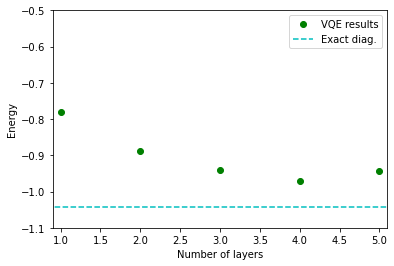

In [36]:
plt.plot(np.array([1,2,3,4,5]),Energy,'o', color = "green",label="VQE results")
plt.plot(np.array([0,1,2,3,4,5,6]),eigenvalues[0]*np.ones(7), ls = "--", color ="c", label = "Exact diag.")
plt.xlabel("Number of layers")
plt.ylabel("Energy")
plt.ylim(-1.1,-0.5)
plt.xlim(0.9,5.1)
plt.legend()

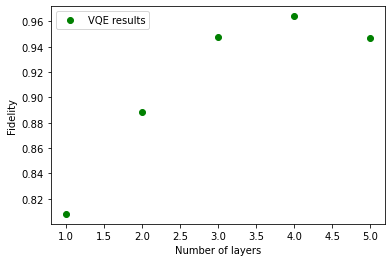

In [37]:
plt.plot(np.array([1,2,3,4,5]),Fidelity,'o', color = "green",label="VQE results")
plt.xlabel("Number of layers")
plt.ylabel("Fidelity")
plt.legend()